## Barghi et al. (2019) Data Processing and Basic EDA

## Setup

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

In [3]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.misc import integerize
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot

In [4]:
# from collections import defaultdict
# import pandas as pd
# import numpy as np
# import numpy.polynomial.polynomial as poly
# import matplotlib.pyplot as plt
# from matplotlib import cm
# import matplotlib as mpl
# from matplotlib import animation
# import re
# import pickle
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats import gaussian_kde



# from cvtk.tempdata import  TemporalFreqs
# import cvtk.variant_files as vf
# from cvtk.covmethods import (cov_matrix_to_dataframe, cov_tensor_to_dataframe, stack_temporal_covariances, 
#                              stack_replicate_covariances, stack_all_covariances, tri_offdiag)
# from cvtk.gintervals import GenomicIntervals
# from cvtk.misc import integerize
# from cvtk.pca import FreqPCA
# from cvtk.plots import rep_plot_pca, subpop_pca_plot, correction_diagnostic_plot

In [5]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

# Data and Annotation Loading and EDA 

### Load in SyncFile

In [6]:
CACHED_SYNC = '../data/barghi_et_al_2019/barghi_et_al_2019.hdf5'
SYNC_FILE = '../data/barghi_et_al_2019/Dsim_F0-F60_Q20_polymorphic_CMH_FET_blockID.sync.gz'

if not os.path.exists(CACHED_SYNC):
    sf = vf.SyncFile(SYNC_FILE)
    sf.dump_hdf5(CACHED_SYNC)
else:
    sf = vf.SyncFile.load_hdf5(CACHED_SYNC)

total time to load HDF5 file: 0.32603868246078493 mins.


In [7]:
sf_gi = sf.build_gintervals()
sf_gi.seqlens = dict()
with open('../data/dsimulans/dsim-M252-seqlens.txt') as f:
    for line in f:
        seqid, length = line.strip().split('\t')
        sf_gi.seqlens[seqid] = int(length)

In [8]:
keep_seqids = ['2L', '2R', '3L', '3R', 'X']
keep_autos = ['2L', '2R', '3L', '3R']

### Design

Next, we parse the sample names  the `README.docx` file (https://datadryad.org/resource/doi:10.5061/dryad.rr137kn/1).

From the readme, the sample name formats are,

```
for the base populations:      species_population_selectionRegime_replicate: e.g. Dsim_Fl_Base_4 
for the evolved populations:   species_population_selectionRegime_generation_replicate: e.g. Dsim_Fl_Hot_F13_1
```

which we parse using regular expressions:

In [9]:
CACHED_DESIGN = '../data/barghi_et_al_2019/barghi_et_al_2019_design.feather'

if not os.path.exists(CACHED_DESIGN):
    RAW_DESIGN_FILE = '../data/barghi_et_al_2019/barghi_et_al_2019_design.txt'
    sample_names = pd.read_csv(RAW_DESIGN_FILE, header=None, names=('col', ))['col'].tolist()
    sample_re = re.compile(r"(?P<species>Dsim)_(?P<pop>Fl)_(?P<selection>Base|Hot)_(F(?P<gen>\d+)_)?(?P<rep>\d+)")
    sample_info = [{'name':d, **re.match(sample_re, d).groupdict()} for d in sample_names]
    design = pd.DataFrame.from_dict(sample_info)
    
    # Barghi et al use base population to refer to generation zero — we set that explicitly here:
    design.loc[design.gen.isnull(), 'gen'] = 0
    design['gen'] = design['gen'].astype('int')
    
    design.to_feather(CACHED_DESIGN)
else:
    design = pd.read_feather(CACHED_DESIGN)

Our `TemporalFreqs()` and `TiledTemporalFreqs()` objects take a list of tuples `(timepoint, replicate)`, which we create via the design DataFrame:

In [10]:
samples = [(int(t), int(r)) for t, r in zip(design['rep'].values, design['gen'].values)]

### Import Annotation
We use the M252 reference genome annotation described by Palmieriet al. (2015).

In [12]:
gtf_file = '../data/dsimulans/dsim-M252-popgen-ann-r1.1.sorted.gtf'
keep_seqids = set('2L 2R 3L 3R 4 X'.split())
dsim = GenomicIntervals.from_gff(gtf_file, filter_type='exon', filter_seqids=keep_seqids, delims=(' ', '; '))

In [13]:
dsim

GenomicIntervals — 6 unique seqids, 169132 features
   GenomicInterval attributes phase   score seqid          source strand  type
0  2L:[3589, 4976)       None     .  1000.0    2L       Cufflinks      -  exon
1  2L:[4846, 4976)       None     1     NaN    2L  protein2genome      -  exon
2  2L:[4846, 4976)       None     1     NaN    2L  protein2genome      -  exon
3  2L:[4846, 4976)       None     1     NaN    2L  protein2genome      -  exon
4  2L:[4941, 4976)       None     2     NaN    2L  protein2genome      -  exon
[ 169127 more GenomicIntervals ]

In [14]:
dsim.infer_seqlens()

Following Signor et al. (2018) and others we exclude centromere and telomere regions — 1Mb on each end.

In [15]:
exon_tiles = GenomicIntervals.from_tiles(dsim.seqlens, width=8e5)
dsim.data['width'] = np.array(dsim.end) - np.array(dsim.start)
exon_tiles.stat_by_coverage(dsim, 'width', colname='width')

GenomicIntervals — 6 unique seqids, 135 features
           GenomicInterval        width
0         2L:[0, 800000.0)  3221.631558
1   2L:[800000, 1600000.0)  1164.362227
2  2L:[1600000, 2400000.0)  1106.177690
3  2L:[2400000, 3200000.0)  1581.527571
4  2L:[3200000, 4000000.0)   939.164470
[ 130 more GenomicIntervals ]

What does exon density look like at a large scale (800Kb)?

## Exon Statistics

### Exons by region

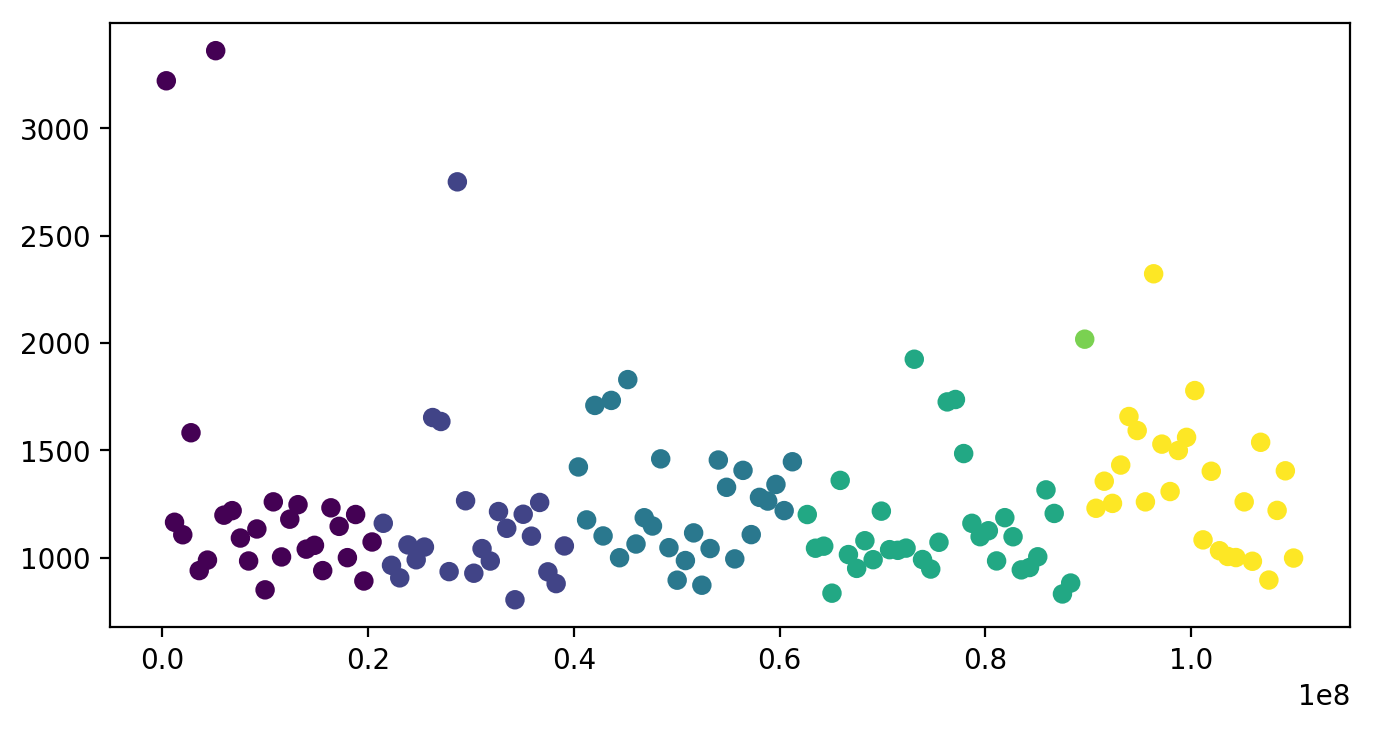

In [28]:
exon_df = exon_tiles.to_df(add_cummidpoint=True)
plt.scatter(exon_df.cummidpoint, exon_df.width, c=integerize(exon_df['seqid']))

## Depth Statistics

Below, we look at the histogram of autosomes depths.

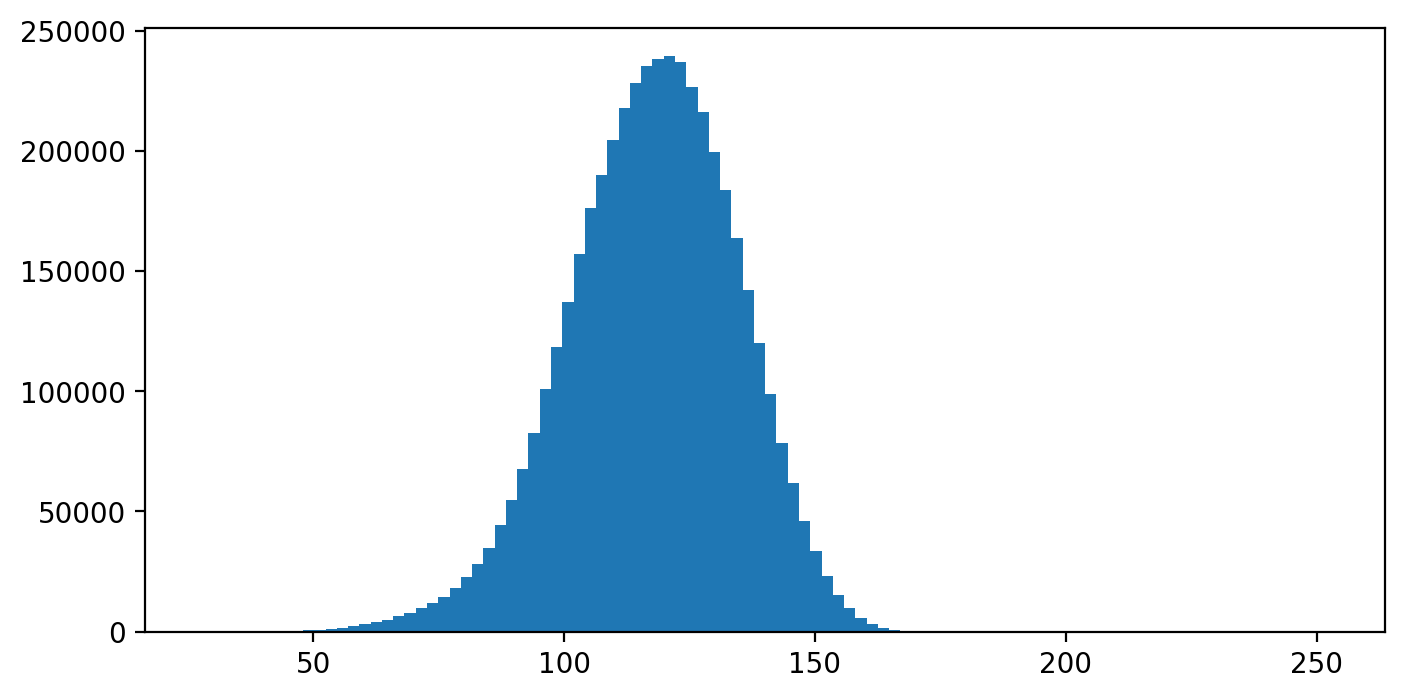

In [29]:
# averaging across samples:
_ = plt.hist(sf.N[np.isin(sf_gi.seqid, keep_autos), :].mean(axis=1), 100)
lower_cutoff, upper_cutoff = 70, 160
plt.show()

### Sequencing Depth by Timepoint
These are total counts by timepoint, showing the heavier sequencing in the earlier timepoints.

<BarContainer object of 10 artists>

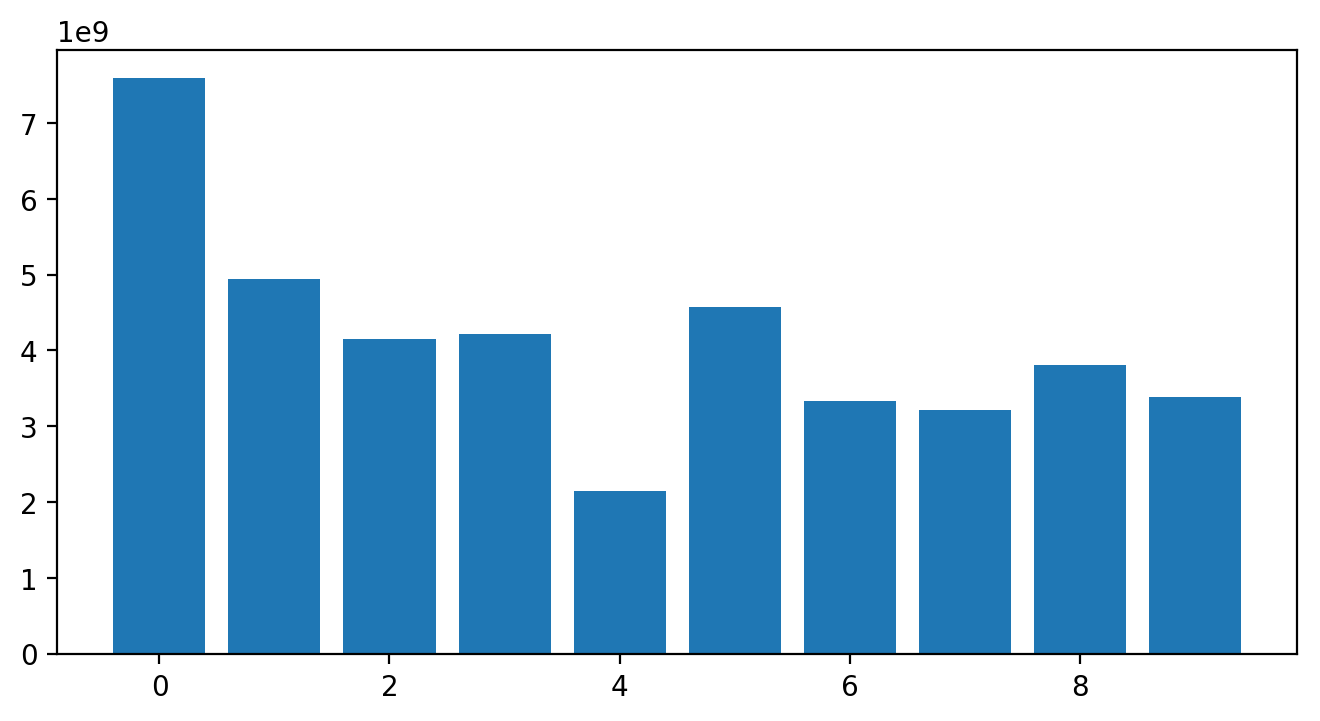

In [30]:
total_counts = sf.N.T.reshape((10, 7, -1)).sum((1, 2))
rank = total_counts.argsort()
plt.bar(np.arange(10), total_counts)

### Sequencing Depth by Region
Depth by 100kb tile:

In [92]:
ntiles = GenomicIntervals.from_tiles(dsim.seqlens, width=1e5)
sf_gi.data['N'] = sf.N.mean(axis=1)
ntiles.stat_by_coverage(sf_gi, 'N', colname='N')

GenomicIntervals — 6 unique seqids, 1106 features
         GenomicInterval           N
0       2L:[0, 100000.0)  135.418155
1  2L:[100000, 200000.0)  128.583428
2  2L:[200000, 300000.0)  122.271621
3  2L:[300000, 400000.0)  121.353718
4  2L:[400000, 500000.0)  118.993646
[ 1101 more GenomicIntervals ]

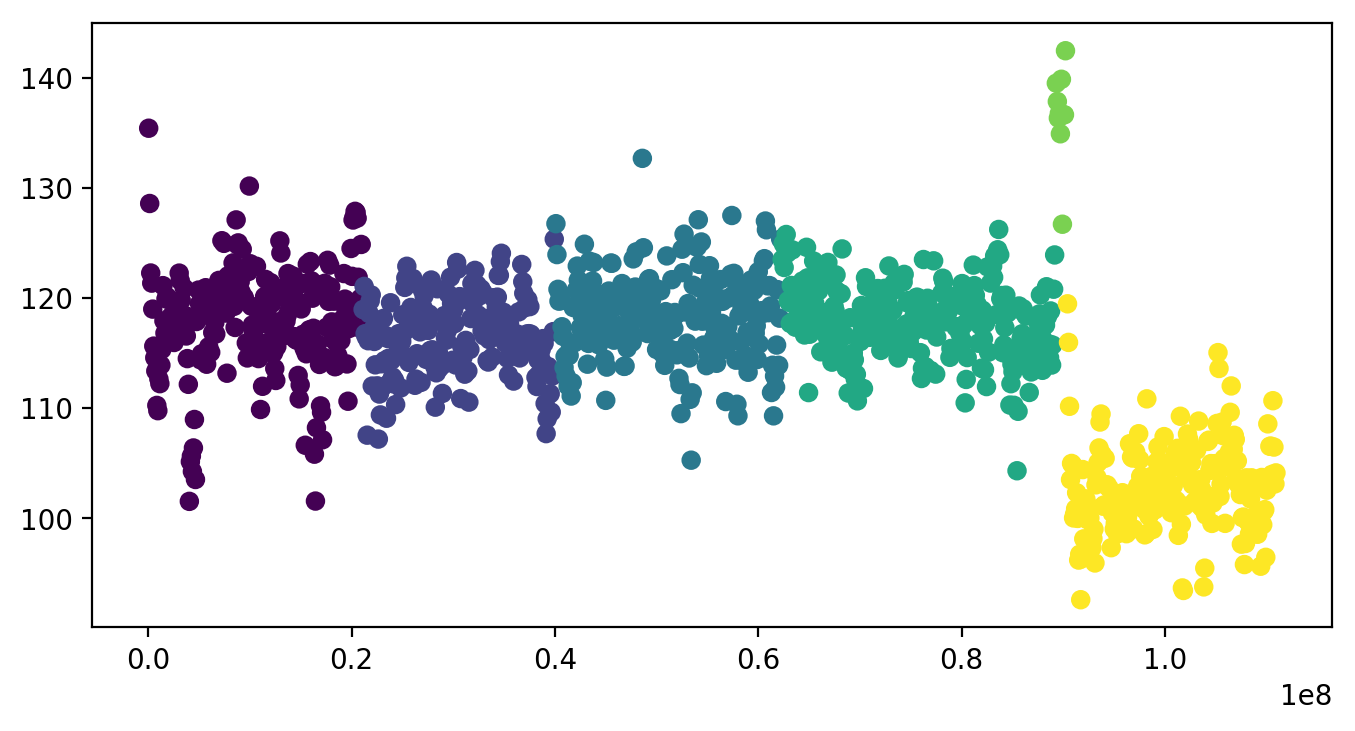

In [32]:
ndf = ntiles.to_df(add_cummidpoint=True)
plt.scatter(ndf.cummidpoint, ndf.N, c=integerize(ndf.seqid))

### PCA of Samples



In [40]:
pca = FreqPCA(sf.freqs)
pc_df= pca.to_df()
# add in the sample info:
pc_df[['rep', 'gen']] = design[['rep', 'gen']]

In [19]:
## This is for an animation of the PCA points growing through the generations
# for gen in np.arange(0, 61, 10):
#     fig, ax = rep_plot_pca(pc_df[pc_df['gen'] <= gen], 1, 2, s=200, figsize=(9, 4.5), dpi=300, label=False, cmap='Set3')
#     ax.set_xlim(-130, 150)
#     ax.set_ylim(-160, 230)
#     #plt.box(on=None)
#     plt.savefig(f'images/pca-{gen}.png')
# plt.show()

<module 'matplotlib.pyplot' from '/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/matplotlib/pyplot.py'>

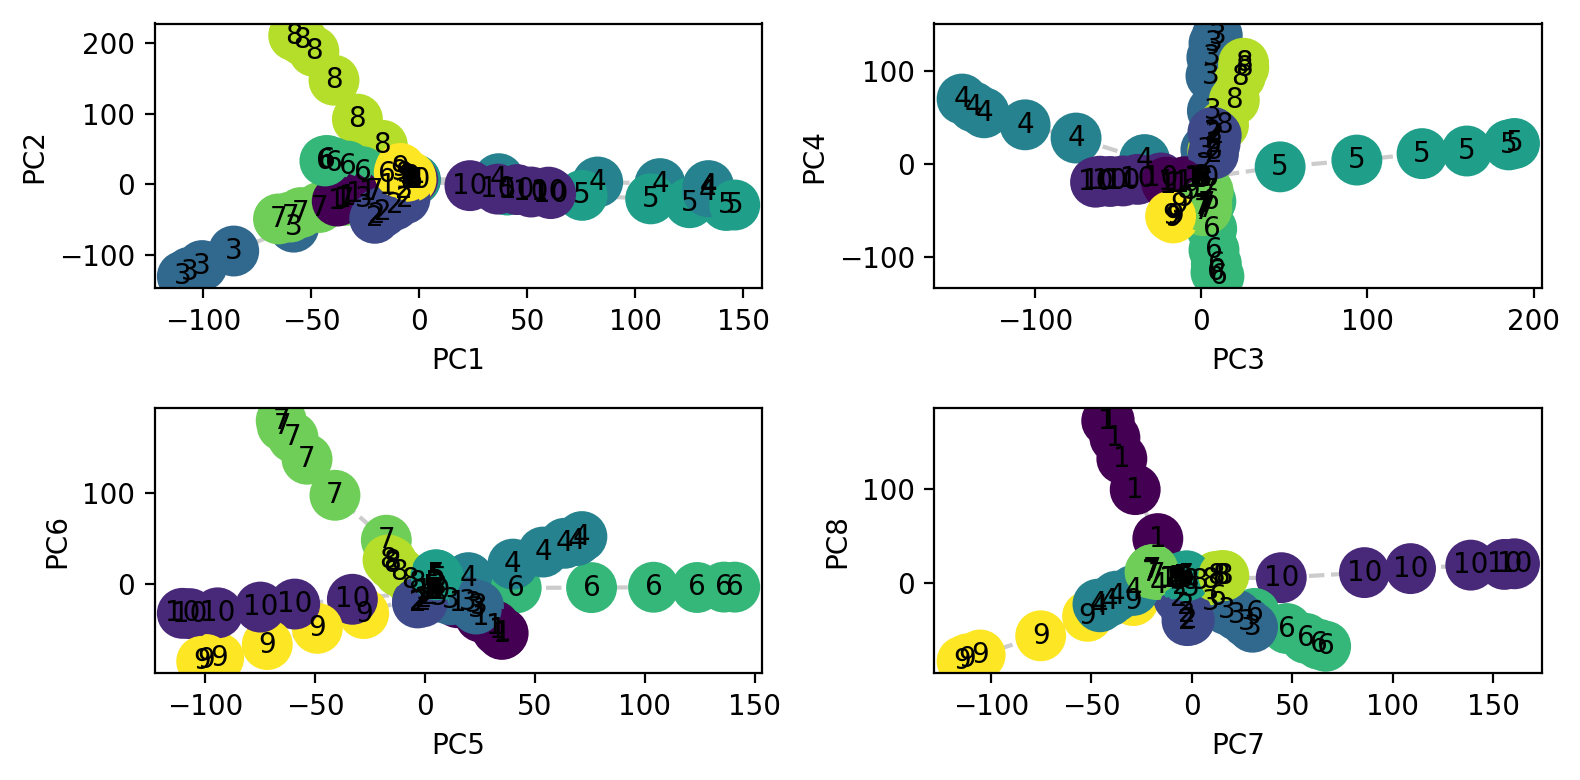

In [42]:
plt.subplot(221)
rep_plot_pca(pc_df, 1, 2)
plt.subplot(222)
rep_plot_pca(pc_df, 3, 4)
plt.subplot(223)
rep_plot_pca(pc_df, 5, 6)
plt.subplot(224)
rep_plot_pca(pc_df, 7, 8)

### Import Linkage Disequilibrium Data from Signor et al. 2018

In [21]:
CACHED_LDTILES = '../data/barghi_et_al_2019/ldtiles_maf0_05.pkl'
if not os.path.exists(CACHED_LDTILES):
    ldtiles = GenomicIntervals.from_tiles(dsim.seqlens, width=1e5)
    # read in ld info
    ld = pd.read_csv('../data/barghi_et_al_2019/ld_means_maf0_05.csv', header=None, names=('seqid', 'pos', 'r2mean'))
    ld_gi = GenomicIntervals()
    r2means = []
    for row in ld.itertuples(index=False):
        seqid, pos, r2mean = row
        ld_gi.append(seqid, pos)
        r2means.append(r2mean)
    ld_gi.set_data(pd.DataFrame(dict(r2mean = r2means)))

    # apply these to our LD tiles, averaging by extent of coverage
    ldtiles.stat_by_coverage(ld_gi, 'r2mean', colname='r2mean')
    ldtiles.dump(CACHED_LDTILES)
else:
    ldtiles = GenomicIntervals.load(CACHED_LDTILES)
    
ldtiles_df = ldtiles.to_df(add_cummidpoint=True, add_midpoint=True)

In [22]:
def smooth_ld(x, y, test_size=0.6, random_state=0):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    mse = []
    fracs = np.arange(0.1, 0.9, 0.05)
    for frac in fracs:
        lowess = sm.nonparametric.lowess(y_train, x_train, frac=frac)
        x_pred, y_pred = list(zip(*lowess))
        mse.append(np.mean((y_train - y_pred)**2))
    mse = np.array(mse)
    best_idx = np.argmin(mse)
    print(f"best MSE: frac = {fracs[best_idx]}, mse = {mse[best_idx]}")
    lowess = sm.nonparametric.lowess(y, x, frac=fracs[best_idx])
    x_pred, y_pred = list(zip(*lowess))
    return x_pred, y_pred

best MSE: frac = 0.8500000000000002, mse = 0.0017554383019112382
best MSE: frac = 0.8500000000000002, mse = 0.002226167452446975
best MSE: frac = 0.8500000000000002, mse = 0.0012159773914295696
best MSE: frac = 0.8500000000000002, mse = 0.0016441182722450795
best MSE: frac = 0.1, mse = 0.009806591669467738
best MSE: frac = 0.7500000000000002, mse = 0.0037361053716071764


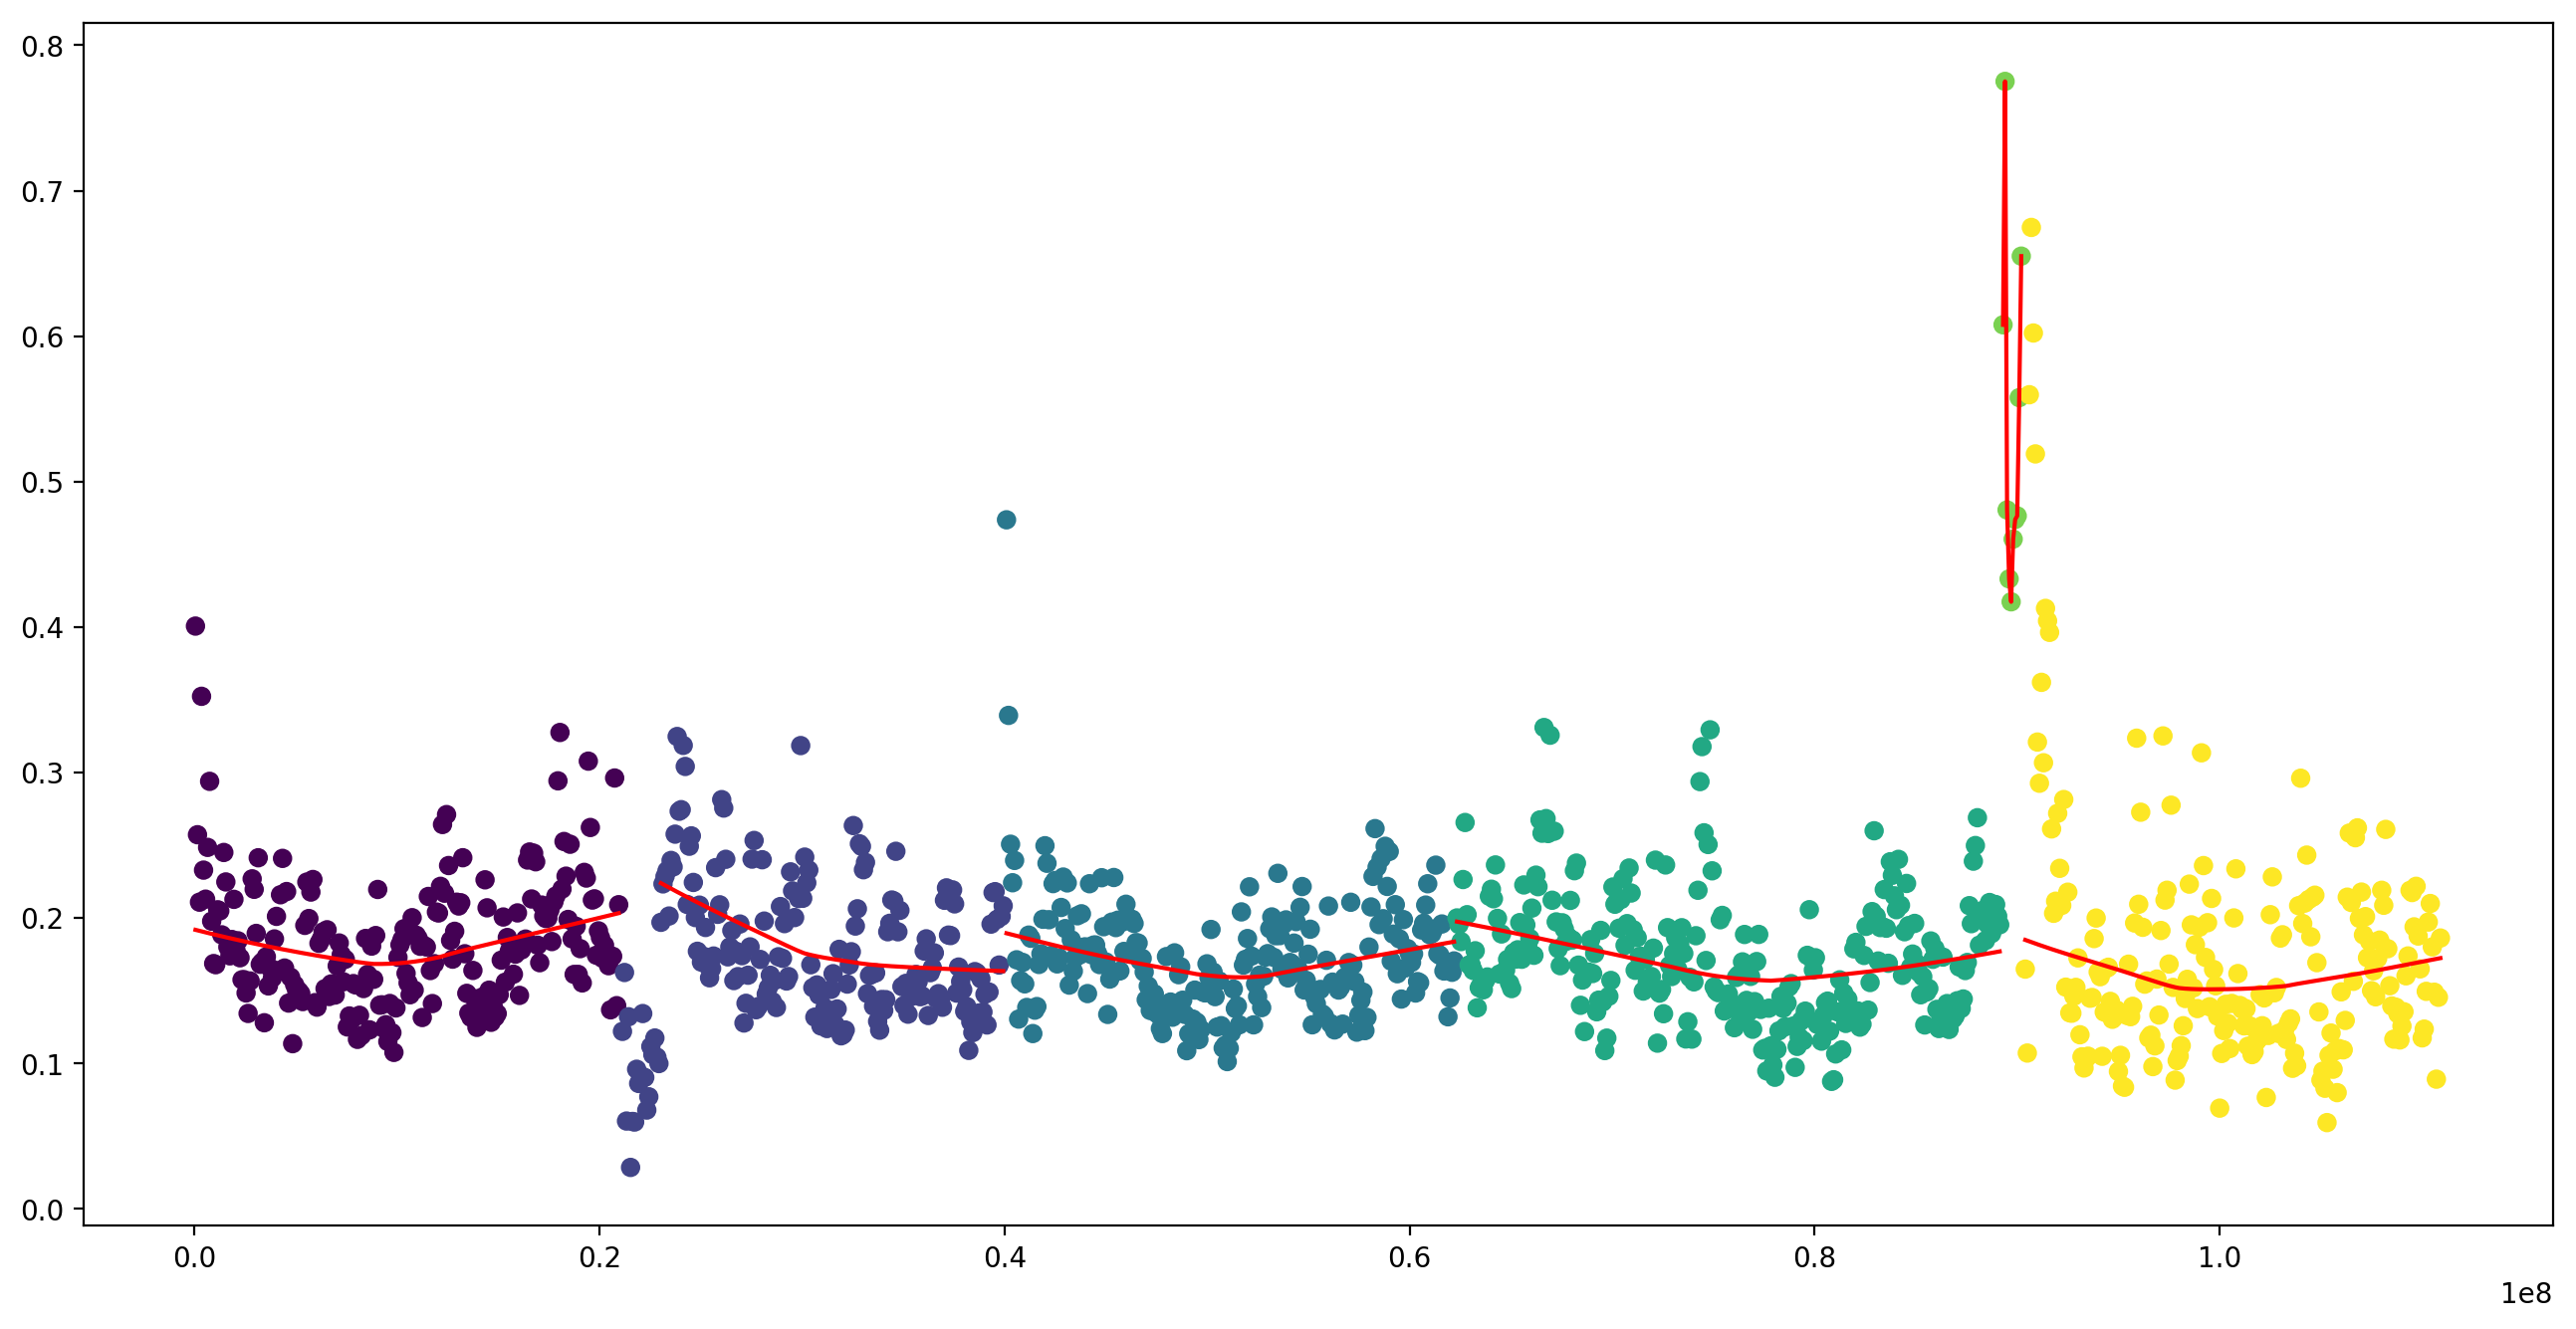

In [23]:
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
ldsmoothers = dict()

plt.scatter(ldtiles_df.cummidpoint, ldtiles_df.r2mean, c=integerize(ldtiles_df.seqid), alpha=1)

for chrom in ldtiles_df['seqid'].unique():
    chr_df = ldtiles_df[ldtiles_df['seqid'] == chrom]    
    if chrom == '2R':
        # there's something wrong with centromere end of these data, so we drop those values
        chr_df = chr_df[chr_df['midpoint'] > 1.9e6]
    lowess_x, lowess_y = smooth_ld(chr_df['cummidpoint'], chr_df['r2mean'])
    f = interp1d(lowess_x, lowess_y, bounds_error=False)
    plt.plot(lowess_x, lowess_y, c='r')
    ldsmoothers[chrom] = f



# Covariance Data Analysis

### Creating TiledTemporalFreqs Object

In [9]:
dd = TemporalFreqs(freqs=sf.freqs.T, depths=sf.N.T, gintervals=sf_gi, samples=samples)

In [113]:
gw_covs = dd.calc_covs()

In [114]:
gw_covs

array([[ 1.68326896e-02,  1.93097881e-03,  4.28993577e-04, ...,
         3.20615722e-04,  1.76174662e-04,  2.38211672e-04],
       [ 1.93097881e-03,  1.97077135e-02,  1.03077337e-03, ...,
         2.64561684e-04, -2.83983594e-05, -4.69795820e-04],
       [ 4.28993577e-04,  1.03077337e-03,  1.22884608e-02, ...,
         5.89840941e-04, -1.36108466e-05,  1.69033800e-04],
       ...,
       [ 3.20615722e-04,  2.64561684e-04,  5.89840941e-04, ...,
         1.74693854e-02,  1.14853320e-03,  2.25923745e-04],
       [ 1.76174662e-04, -2.83983594e-05, -1.36108466e-05, ...,
         1.14853320e-03,  1.31635552e-02,  3.80176735e-04],
       [ 2.38211672e-04, -4.69795820e-04,  1.69033800e-04, ...,
         2.25923745e-04,  3.80176735e-04,  1.24284934e-02]])

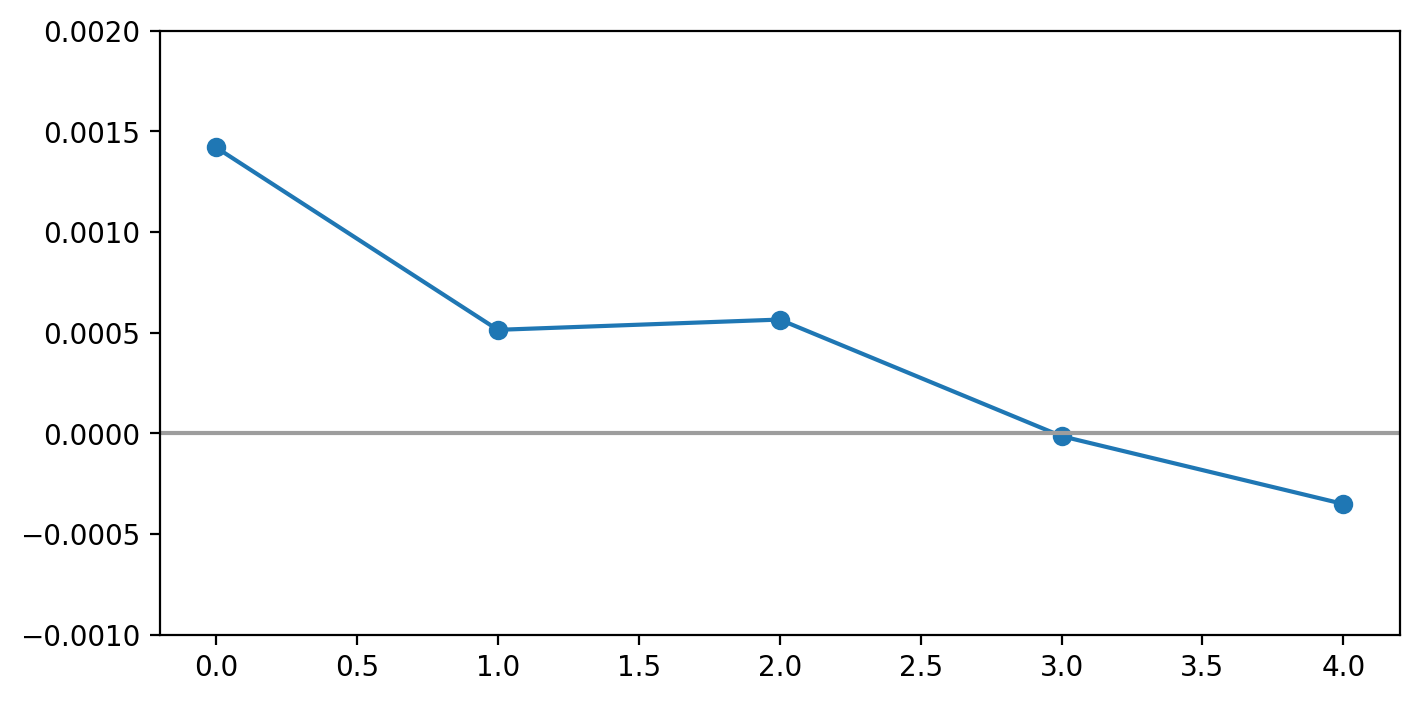

In [121]:
plt.plot(np.arange(5), stack_temporal_covariances(gw_covs, dd.R, dd.T).mean(axis=2)[0, 1:], 'o-')
plt.ylim(-0.001, 0.002)
plt.axhline(0, c='99')

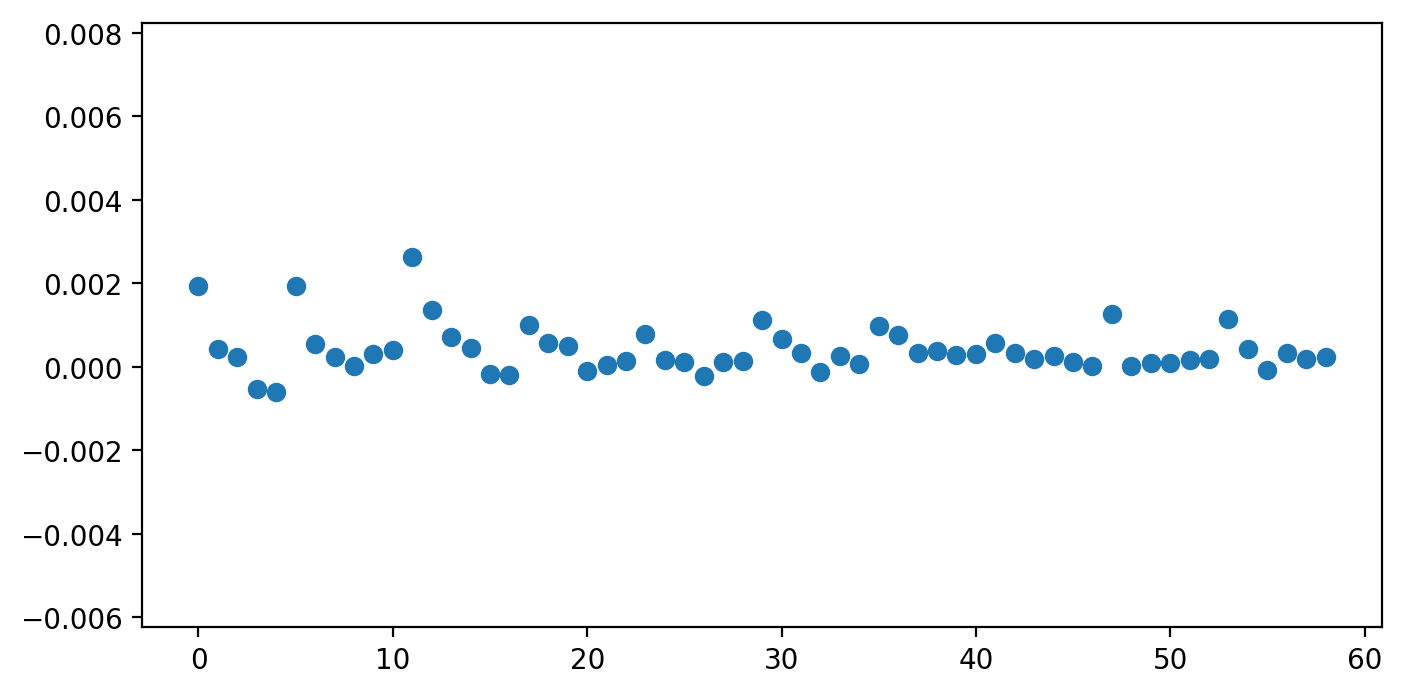

In [122]:
plt.scatter(np.arange(59), gw_covs[0, 1:])

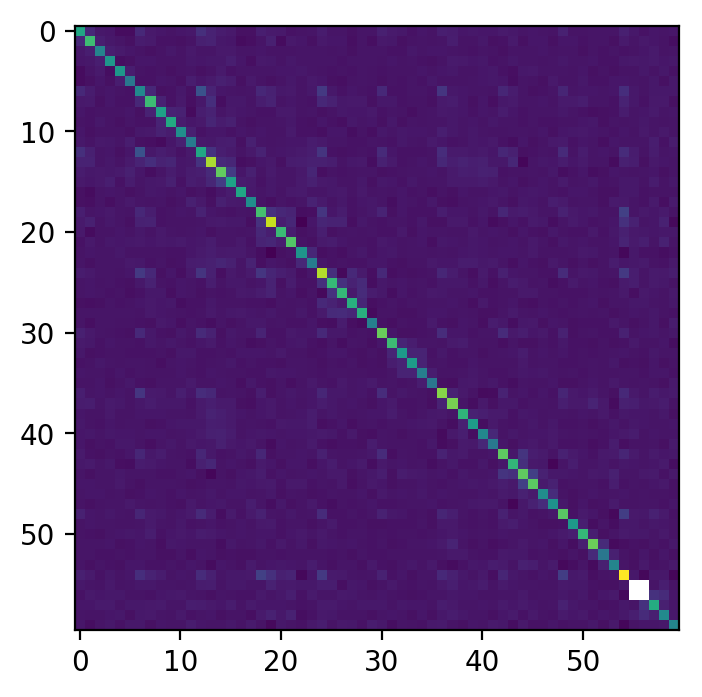

In [124]:
plt.imshow(gw_covs)

In [16]:
tile_width = 1e5
tiles = GenomicIntervals.from_tiles(dsim.seqlens, width=tile_width)
# add in exonic basepairs:
tiles = tiles.overlap_coverage(dsim, colname='exonic_bp')

Find average LD, average number of variants across tiles:

In [17]:
d = TiledTemporalFreqs(tiles, freqs=sf.freqs.T, depths=sf.N.T, gintervals=sf_gi, samples=samples)

In [16]:
tile_covs = d.calc_covs_by_tile()

/home/vinceb/projects/cvtk/cvtk/cov.py:28: RuntimeWarning: divide by zero encountered in true_divide
  het *= depths / (depths-1)
/home/vinceb/projects/cvtk/cvtk/cov.py:28: RuntimeWarning: invalid value encountered in multiply
  het *= depths / (depths-1)


/home/vinceb/projects/cvtk/cvtk/cvtk.py:162: RuntimeWarning: Mean of empty slice.
  het = het.mean()
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(<Figure size 1600x800 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe3a3c9518>,
       dtype=object))

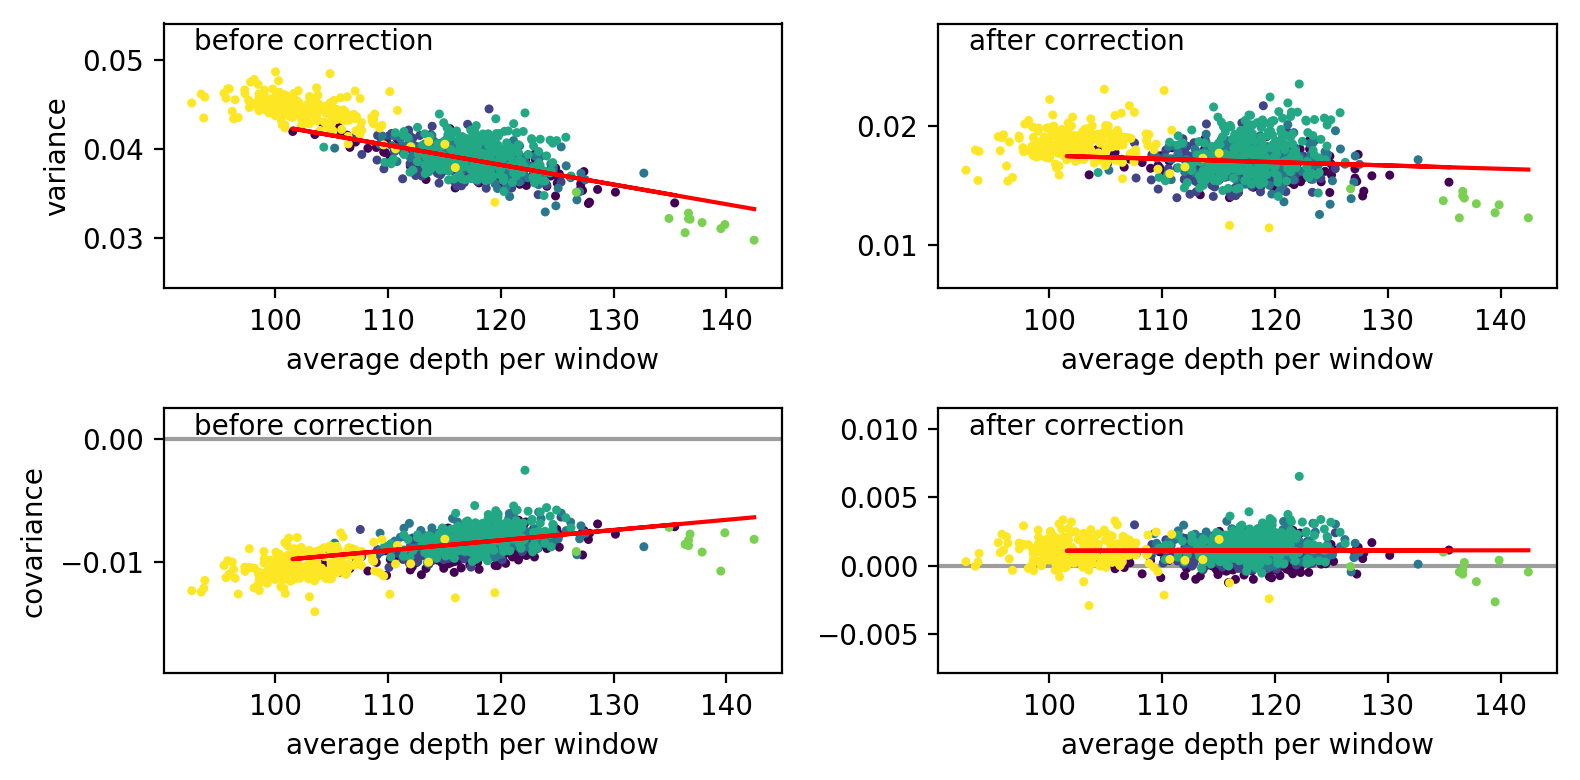

In [17]:
diagnostics = d.correction_diagnostics(exclude_seqids=['X'])
correction_diagnostic_plot(diagnostics)

In [196]:
bs = d.bootstrap_temporal_covs(100, average_replicates=True)

In [ ]:
gs = d.bootstrap_Gs(B=10)

In [ ]:
en = d.empirical_null(by_tile=False, progress_bar=True)

In [44]:
tiles = tiles.stat_by_coverage(ldtiles, 'r2mean', colname='r2mean')
#tiles = tiles.stat_by_coverage(ld_gi, 'n_variants', colname='n_variants')

NameError: name 'ldtiles' is not defined

Supplement the tile dataframe with information on number of loci in each tile, as sell as the smoothed LD.

In [55]:
d.tile_df['nloci'] = [len(tile) for tile in d.tile_indices]
# use smoother interpolation functions, get smoothed R^2 for each tile midpoint
d.tile_df['ld'] = np.stack([ldsmoothers[s](m) for s, m in zip(d.tile_df['seqid'], d.tile_df['midpoint'])])

### Calculate Genome-Wide Covariance

In [69]:
d.calc_covs(min_af=0.05, binomial_correction=True, exclude_seqids=['X'])

NameError: name 'd' is not defined

### Calculate Covariances by Tile

In [104]:
## this includes the X and 4—
covs, covns = d.calc_covs_by_tile(min_af=0.05, suppress_warnings=True)

removing 141150665 (40.0%) loci <= 0.05 or >= 0.95


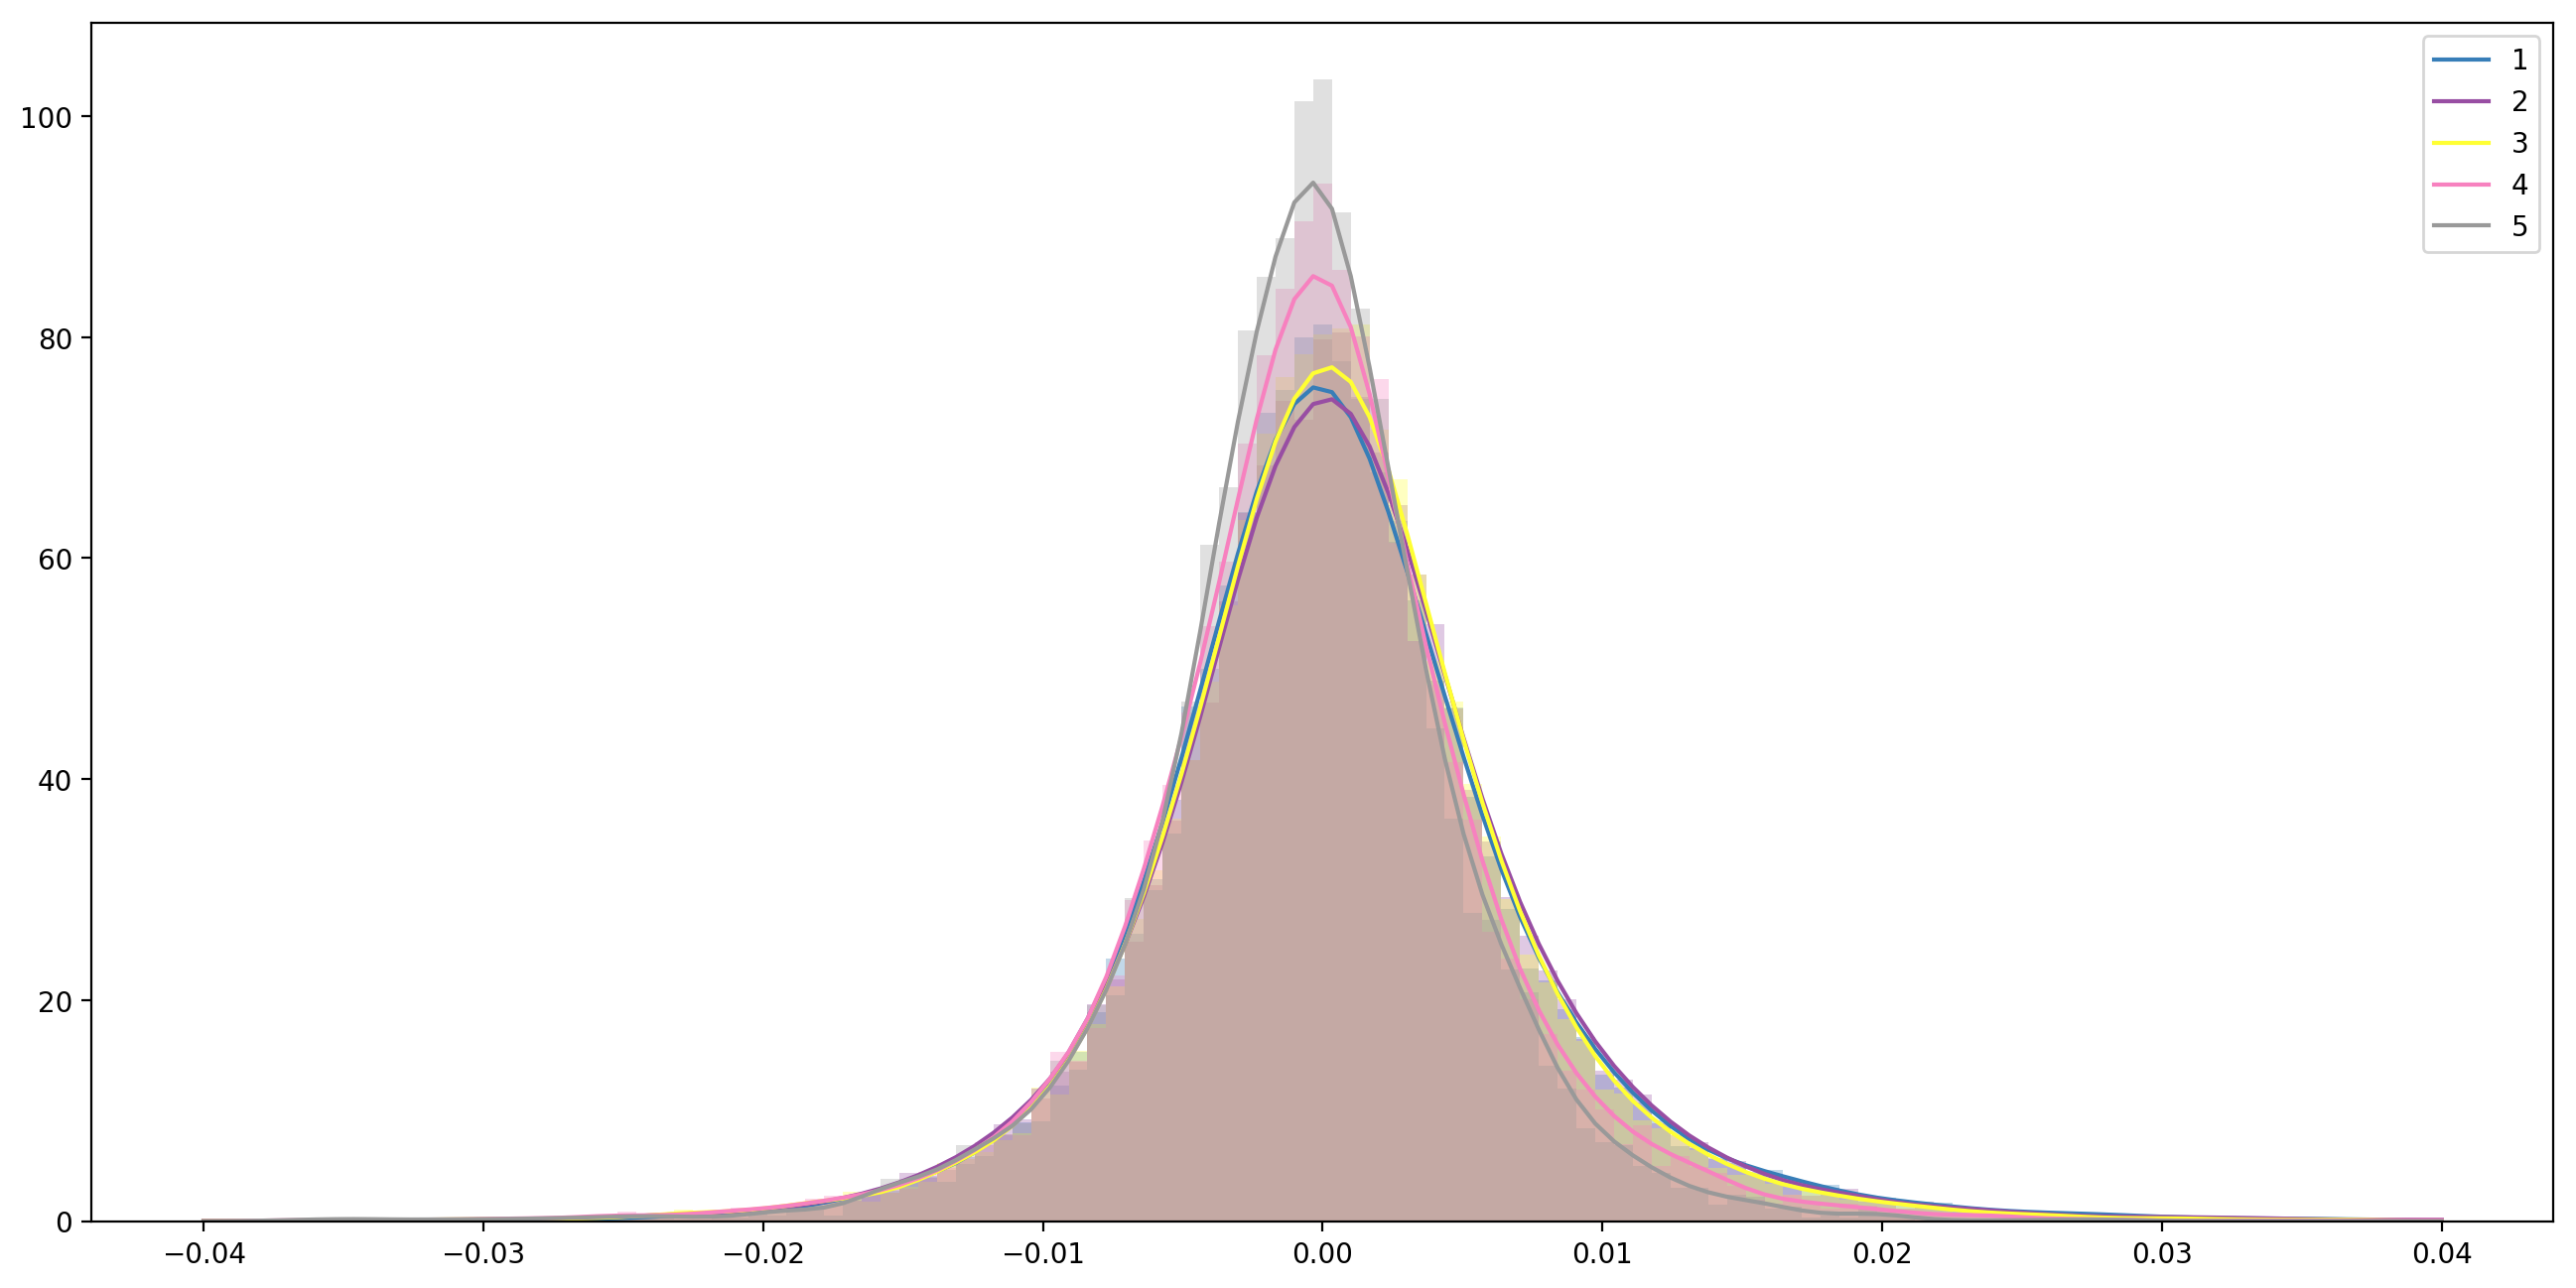

In [58]:
xgrid = np.linspace(-0.04, 0.04, 120)

for i in range(1, 6):
    # iterate over all possible time differences between two timepoints
    # each tile has a covariance matrix with R=10 replicate temporal covariance matrices. We
    # iterate through each temporal covariance matrix for each replicate, grabbing the ith off-diagonal,
    # stacking these, and plotting the histogram of the covarainces with all the replicates pooled 
    vals = np.stack([np.stack([np.diag(c, k=i) for c in stack_temporal_covariances(x, d.R, d.T, as_tensor=False)]) for x in covs]).ravel() 
    cmap = plt.get_cmap('Set1', 6)
    plt.hist(vals, xgrid, alpha=0.3, density=True, color=cmap(i))
    plt.plot(xgrid, gaussian_kde(vals[~np.isnan(vals)], 0.2).evaluate(xgrid), '-', label=i, c=cmap(i))
plt.legend()

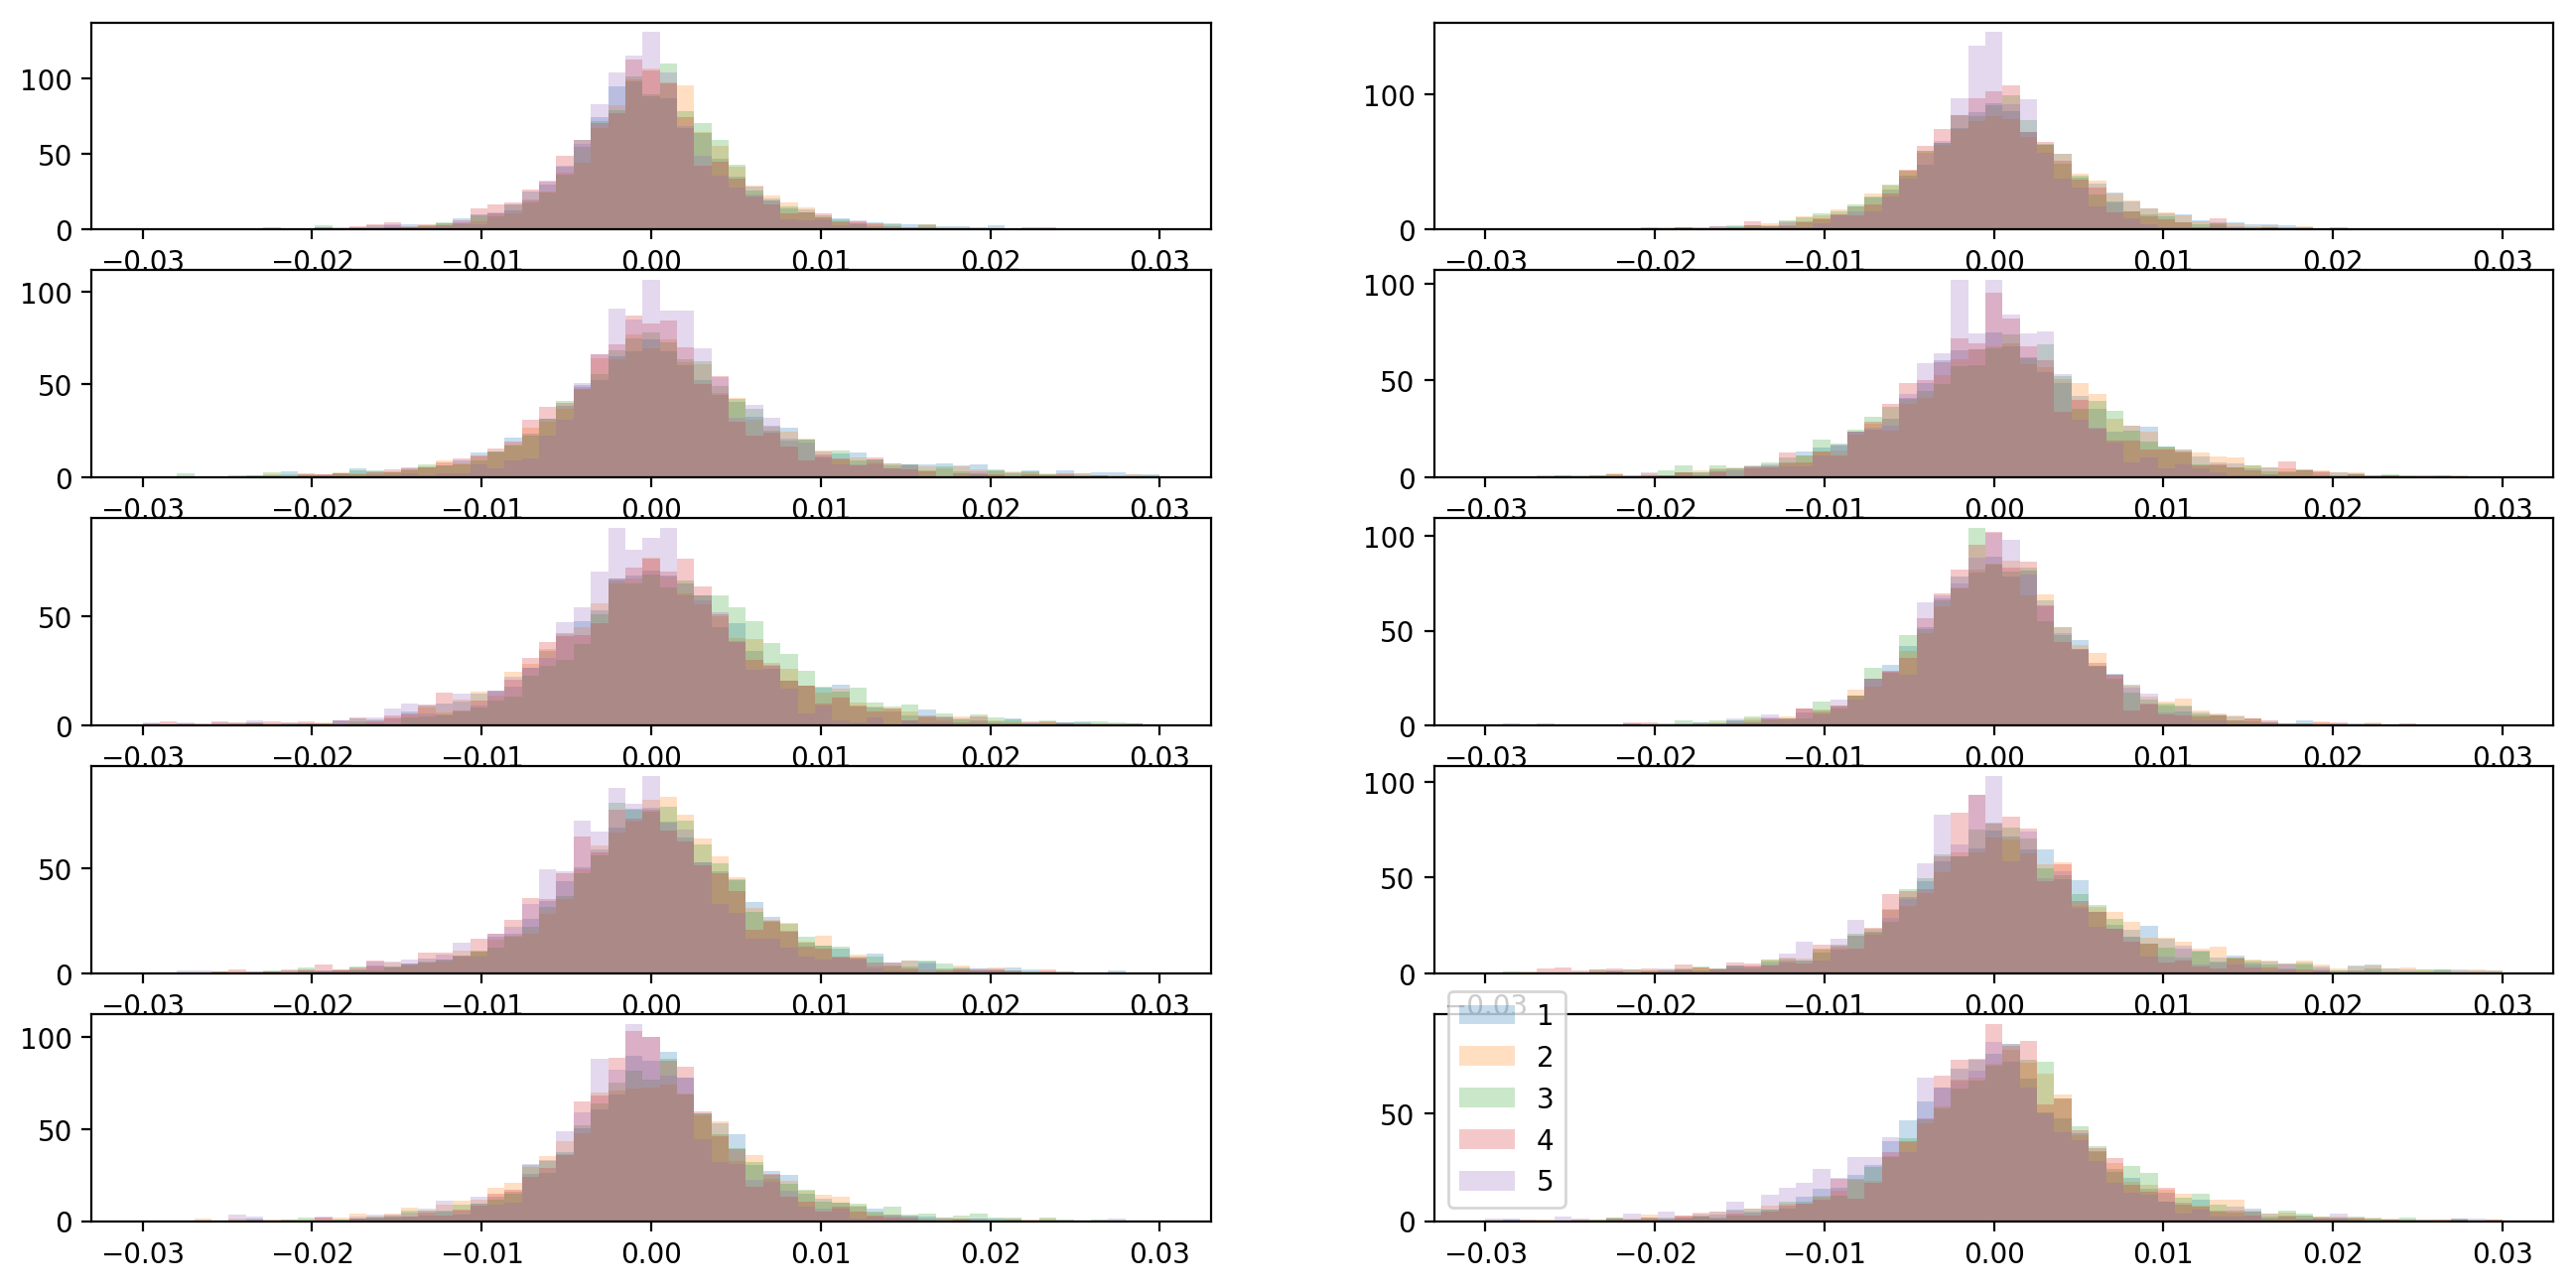

In [59]:
xgrid = np.linspace(-0.03, 0.03, 60)


# map chrs to grid
idx = np.meshgrid(np.arange(2), np.arange(d.R))
cols, rows = idx[0].ravel(), idx[1].ravel()

fig, ax = plt.subplots(ncols=2, nrows=int(d.R/2))

for r in range(d.R):
    for i in range(1, 6):
        # iterate over all possible time differences between two timepoints
        # each tile has a covariance matrix with R=10 replicate temporal covariance matrices. We
        # iterate through each temporal covariance matrix for each replicate, grabbing the ith off-diagonal,
        # stacking these, and plotting the histogram of the covarainces with all the replicates pooled 
        vals = np.stack([np.diag(stack_temporal_covariances(x, d.R, d.T, as_tensor=False)[r], k=i) for x in covs]).ravel() 
        #ax[rows[r], cols[r]].plot(xgrid, gaussian_kde(vals[~np.isnan(vals)], 0.2).evaluate(xgrid), '-', label=i)
        ax[rows[r], cols[r]].hist(vals, xgrid, alpha=0.25, density=True, label=i)
        
plt.legend()

### Empirical Null Distribution

In [60]:
CACHED_EMPCOV_TILE = '../data/barghi_et_al_2019/empnull_reshape_tile.pkl'
CACHED_EMPCOV_TILE_SEQID = '../data/barghi_et_al_2019/empnull_reshape_tile_by_seqid.pkl'
CACHED_EMPCOV_GW = '../data/barghi_et_al_2019/empnull_reshape_gw.pkl'

if not os.path.exists(CACHED_EMPCOV_TILE):
    empcov_tile = d.calc_covs_empirical_null(min_af=0.05, B=1000, by_tile=True, suppress_warnings=True, sign_permute_blocks='tile')
    with open(CACHED_EMPCOV_TILE, 'wb') as f:
        pickle.dump(empcov_tile, f)
else:   
    with open(CACHED_EMPCOV_TILE, 'rb') as f:
        empcov_tile = pickle.load(f)

if not os.path.exists(CACHED_EMPCOV_TILE_SEQID):
    empcov_tile_seqid = d.calc_covs_empirical_null(min_af=0.05, B=1000, by_tile=True, suppress_warnings=True, sign_permute_blocks='seqid')
    with open(CACHED_EMPCOV_TILE_SEQID, 'wb') as f:
        pickle.dump(empcov_tile_seqid, f)
else:   
    with open(CACHED_EMPCOV_TILE_SEQID, 'rb') as f:
        empcov_tile_seqid = pickle.load(f)
        
if not os.path.exists(CACHED_EMPCOV_GW):
    empcov_gw = d.calc_covs_empirical_null(min_af=0.05, B=1000, by_tile=False, suppress_warnings=True)
    with open(CACHED_EMPCOV_GW, 'wb') as f:
        pickle.dump(empcov_gw, f)
else:
    with open(CACHED_EMPCOV_GW, 'rb') as f:
        empcov_gw = pickle.load(f)


In [61]:
# genome-wide sign permutations
empcov_gw_stacked = np.stack([stack_temporal_covariances(strap, d.R, d.T) for strap in empcov_gw])

# tile sign-permutations
empcov_tile_stacked = np.stack([np.stack([strap[tile_idx, :, :, :] for tile_idx in np.arange(strap.shape[0])]) for strap in empcov_tile])

# tile sign-permutations, but using seqids as blocks (more conservative)
empcov_tile_seqid_stacked =  np.stack([np.stack([strap[tile_idx, :, :, :] for tile_idx in np.arange(strap.shape[0])]) for strap in empcov_tile_seqid])

We save the objects below into a numpy format, which can be read by numpy or into R with `reticulate`.

In [62]:
with open('../data/barghi_et_al_2019/tidy/empcov_gw.npy', 'wb') as f:
    np.save(f, empcov_gw_stacked)
    
with open('../data/barghi_et_al_2019/tidy/empcov_tile_tile_blocks.npy', 'wb') as f:
    np.save(f, empcov_tile_stacked)    

with open('../data/barghi_et_al_2019/tidy/empcov_tile_seqid_blocks.npy', 'wb') as f:
    np.save(f, empcov_tile_seqid_stacked)    

In [63]:
gw_covs = d.calc_covs(min_af=0.05)

removing 141150665 (40.0%) loci <= 0.05 or >= 0.95


In [35]:
plt.style.use('buffalo.mplstyle')
bins = np.linspace(-0.004, 0.004, 30)

mpl.rcParams['text.latex.preview'] = True

# average over all replicates
rep = slice(None)

# empirical null
k=2
empnull_k2 = list()
for row in range(0, d.T-k):
    empnull_k2.append(empcov_gw_stacked[:, row, row+k, :].ravel())

real_covs_diag_k2 = np.stack([np.diag(x, k=2) for x in  stack_temporal_covariances(gw_covs, d.R, d.T, as_tensor=False)]).ravel()


darj1 = [(1, 0, 0), (0, 0.627450980392157, 0.54117647058823), (0.949019607843137, 0.67843137254902, 0), (0.976470588235294, 0.517647058823529, 0), (0.356862745098039, 0.737254901960784, 0.83921568627451)]

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(real_covs_diag_k2, bins, alpha=0.3, density=True, label='observed covariances\ncov($\Delta p_t, \Delta p_{{t+%s}}$)' % k, color=darj1[0])
#ax.hist(real_covs_diag_k3, bins, alpha=0.3, density=True, label='observed covariances k=3', color=darj1[0])
ax.hist(np.stack(empnull_k2).ravel(), bins, alpha=0.4, density=True, label='sign-permutation\nneutral null', color=darj1[1])
#ax.hist(np.stack(empnull_k3).ravel(), bins, alpha=0.4, density=True, label='sign-permutation\nneutral null', color=darj1[2])
ax.legend(loc=(0.6, 0.7), mode='expand')
#plt.savefig('images/barghi_et_al_2019/gw-averaged-rep-covdist.pdf')
plt.show()

NameError: name 'empcov_gw_stacked' is not defined

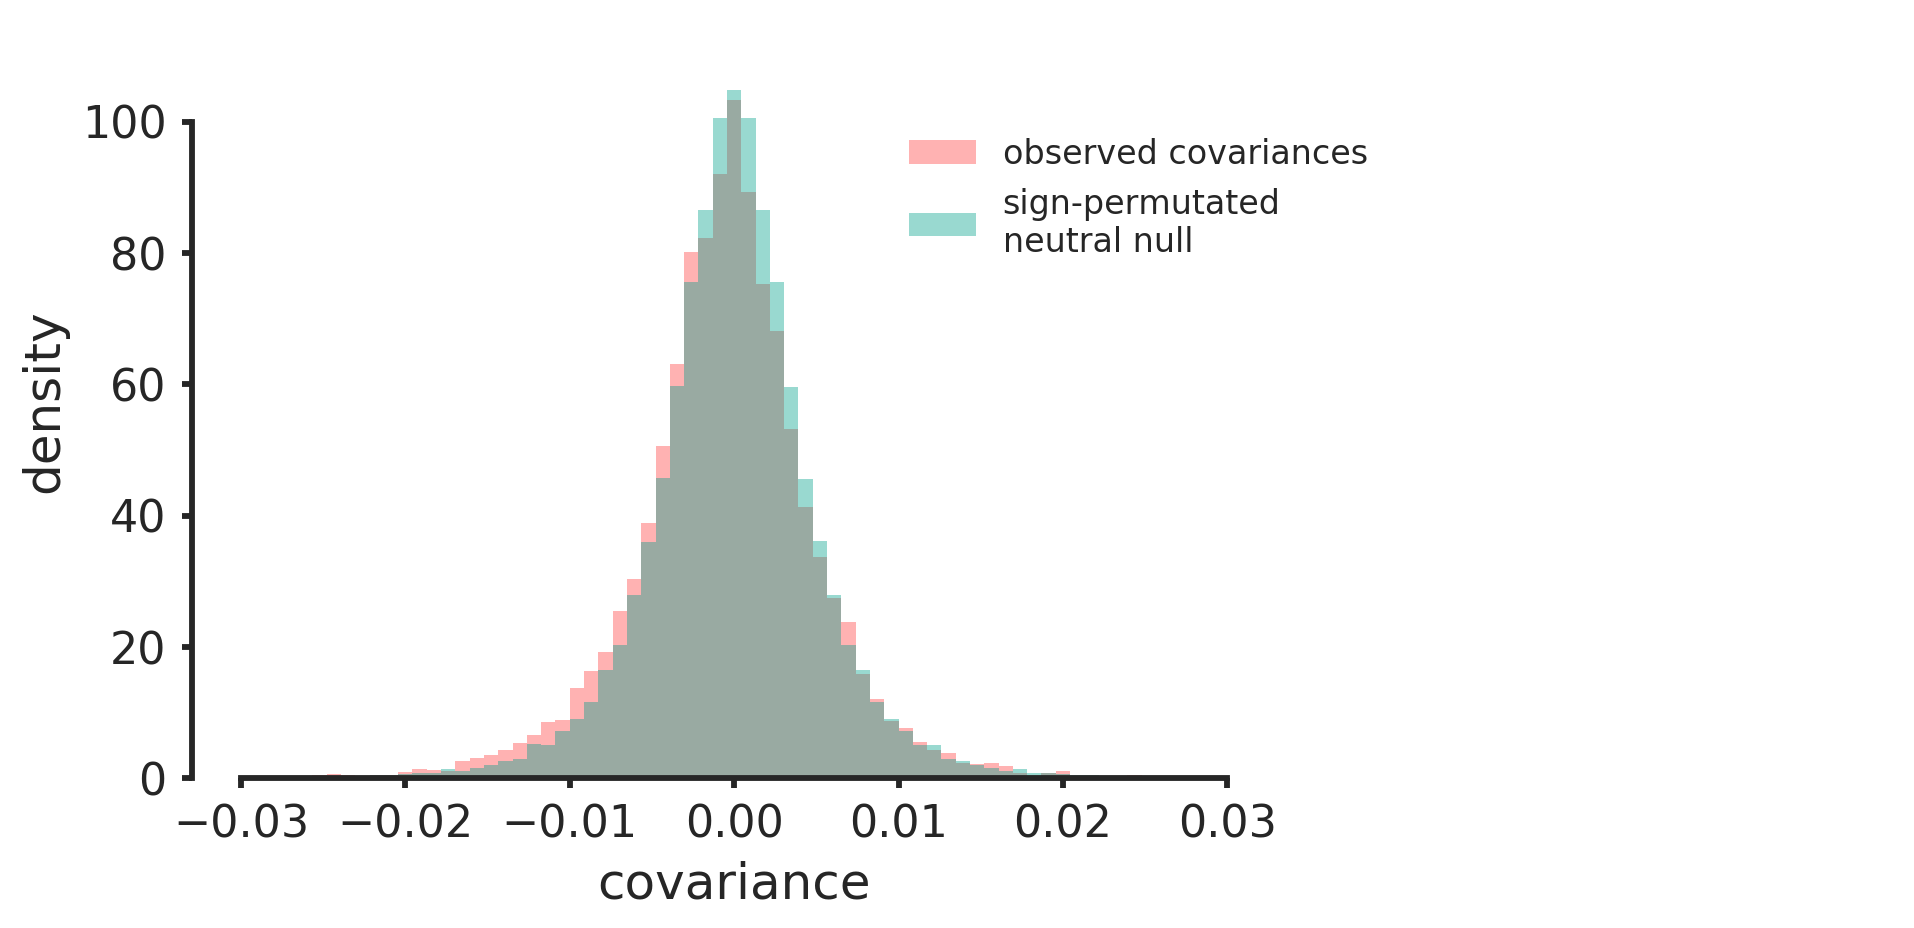

In [297]:
bins = np.linspace(-0.03, 0.03, 70)

# empirical null
k = 5
empnull_k2 = list()
for row in range(0, d.T-k):
    empnull_k2.append(empcov_tile_stacked[:, :, row, row+k, :].ravel())
    
real_covs_diag_k2 = np.stack([[np.diag(stack_temporal_covariances(x, d.R, d.T, as_tensor=False)[rep], k=k) for rep in np.arange(d.R)] for x in covs]).ravel()


fig, ax = plt.subplots(figsize=(7, 5))
#ax.hist(real_covs_diag_k2, bins, alpha=0.3, density=True, label='observed covariances\ncov($\Delta p_t, \Delta p_{t+%s}$)' % k, color=darj1[0])
ax.hist(real_covs_diag_k2, bins, alpha=0.3, density=True, label='observed covariances', color=darj1[0])

ax.hist(np.stack(empnull_k2).ravel(), bins, alpha=0.4, density=True, label='sign-permutated\nneutral null', color=darj1[1])
ax.spines['bottom'].set_bounds(-0.03, 0.03)
ax.spines['left'].set_bounds(0, 100)
plt.ylim(0, 115)
plt.ylabel('density')
plt.xlabel('covariance')
ax.legend(loc=(0.6, 0.6), mode='expand', fontsize=12)
plt.savefig(f"images/barghi_et_al_2019/gw-averaged-rep-covdist-k{k}-both.pdf")
plt.show()

Let's compare two sign-permutation blocking approaches: blocking by whole chromosomes (`seqid`) and tiles:

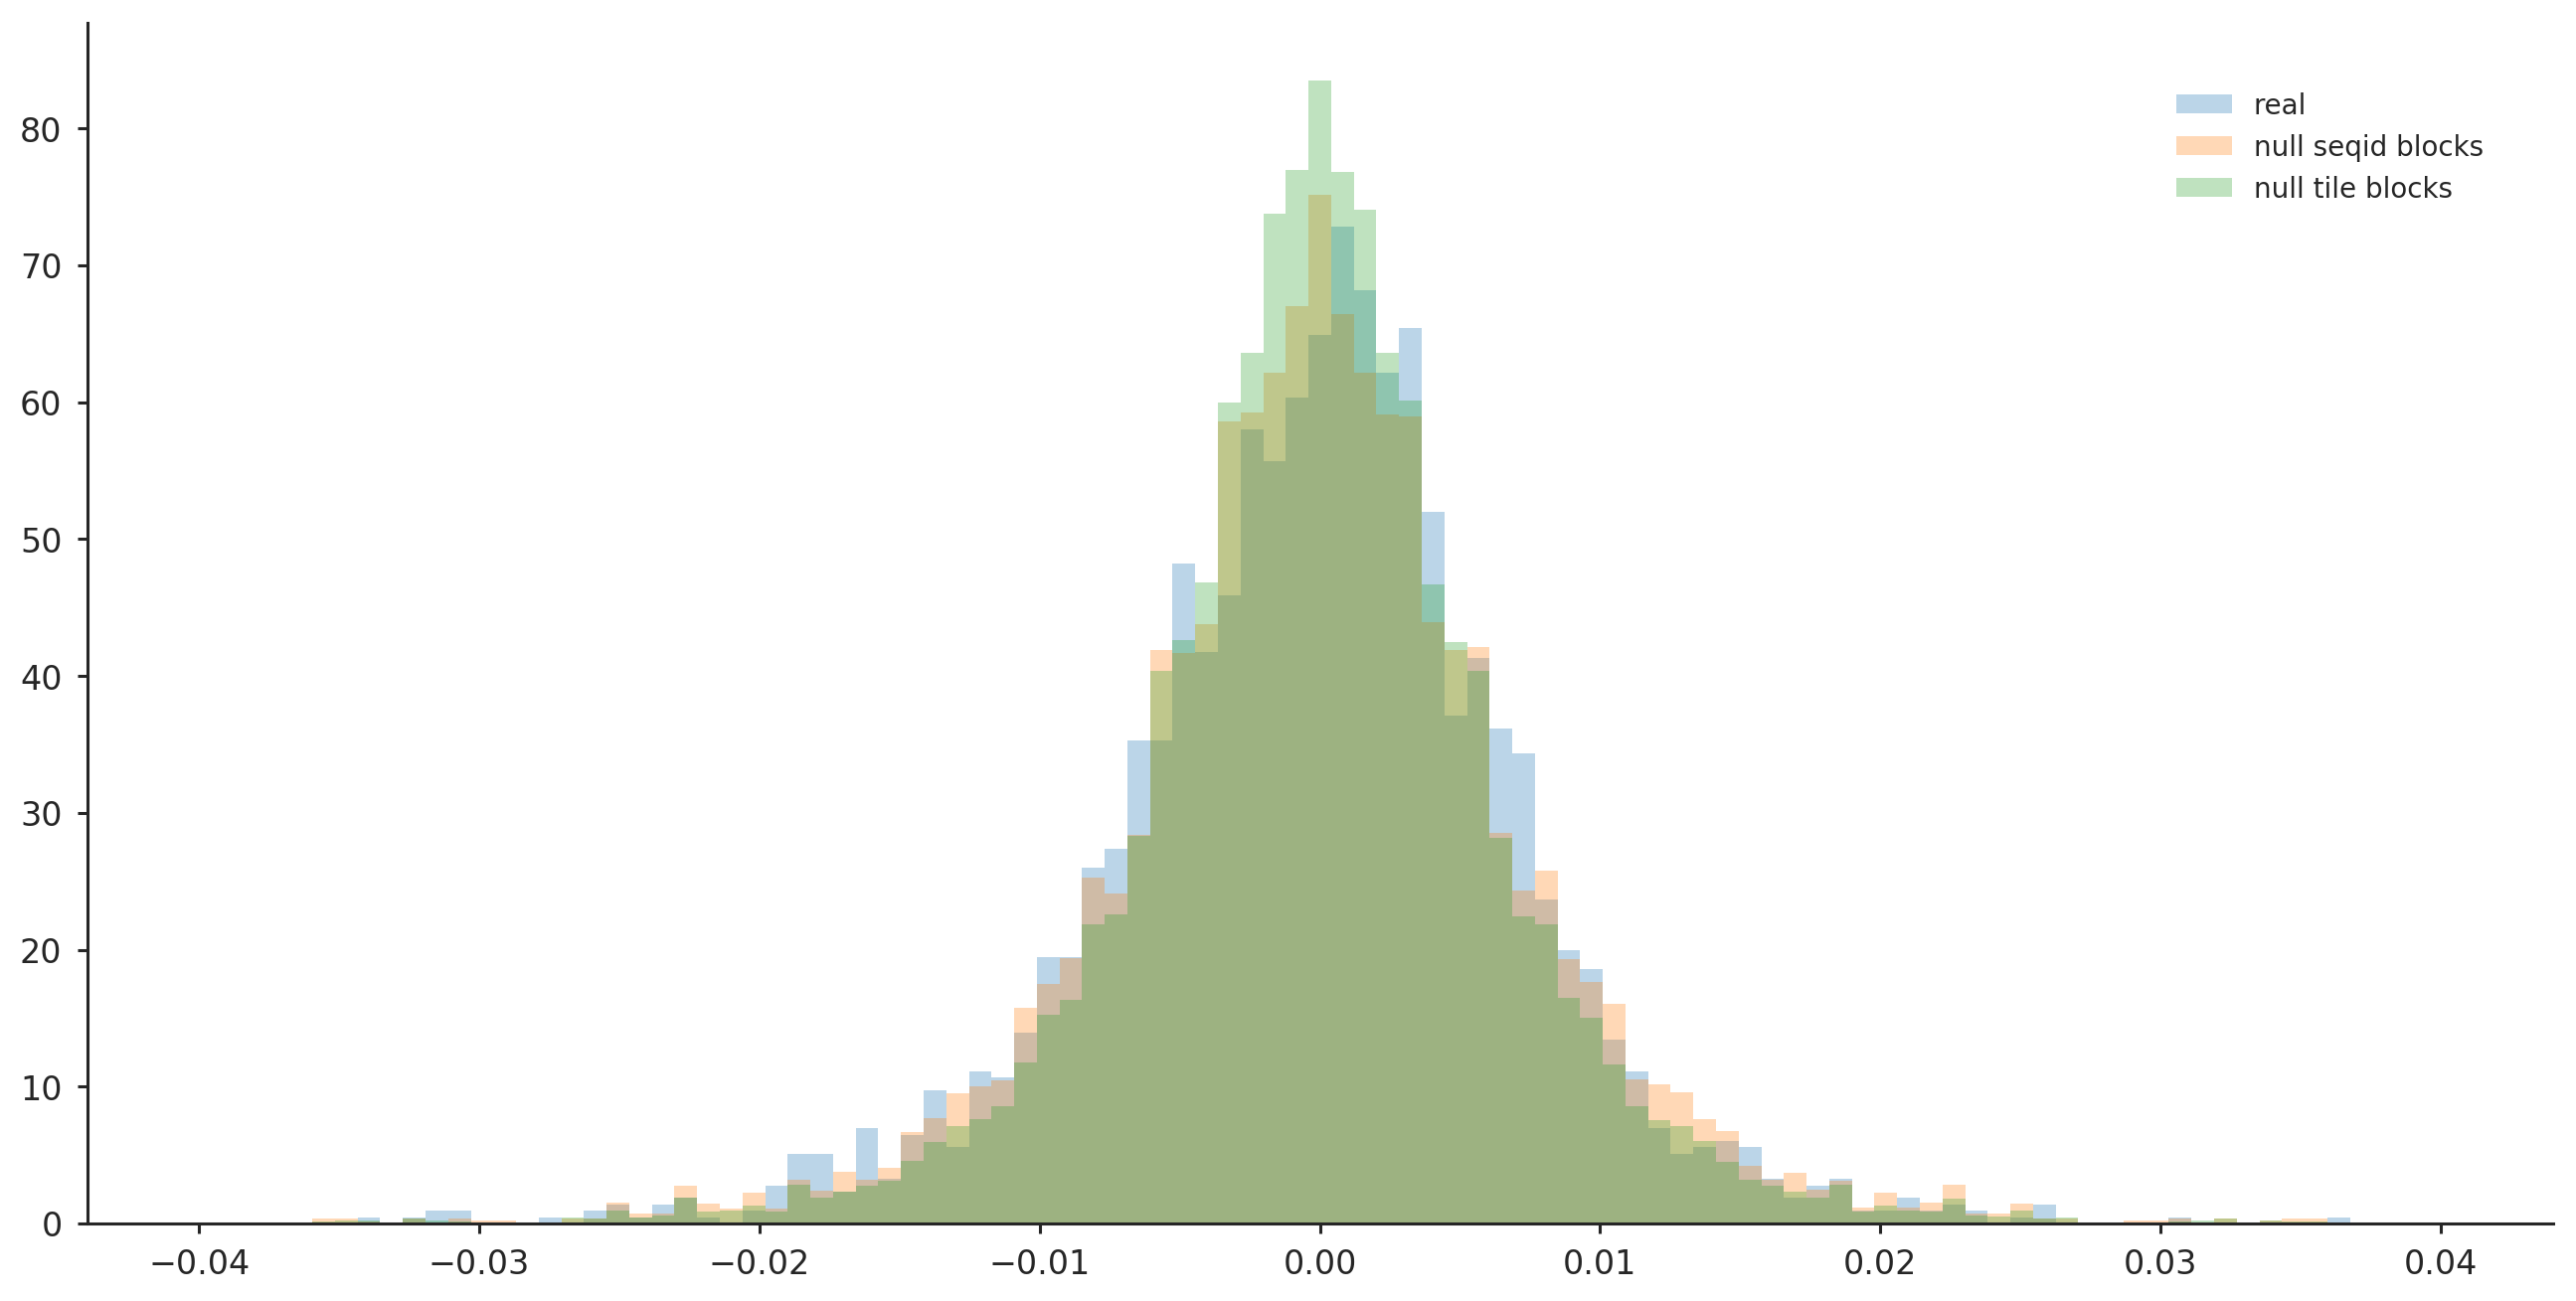

In [66]:
bins = np.linspace(-0.04, 0.04, 100)


k = 3
rep = 3

cc = list()
for row in range(0, d.T-k):
    cc.append(empcov_tile_seqid_stacked[:, :, row, row+k, rep].ravel())

bc = list()
for row in range(0, d.T-k):
    bc.append(empcov_tile_stacked[:, :, row, row+k, rep].ravel())

#real_covs_diag = np.stack([np.stack([np.diag(c, k=k) for c in stack_temporal_covariances(x, d.R, d.T, as_tensor=False)]) for x in covs]).ravel()

real_covs_diag = np.stack([np.diag(stack_temporal_covariances(x, d.R, d.T, as_tensor=False)[rep], k=k) for x in covs]).ravel()
_ = plt.hist(real_covs_diag, bins, alpha=0.3, density=True, label='real')
_ = plt.hist(np.stack(cc).ravel(), bins, alpha=0.3, density=True, label='null seqid blocks')
_ = plt.hist(np.stack(bc).ravel(), bins, alpha=0.3, density=True, label='null tile blocks')

plt.legend()
plt.show()

### Tile covariance annotation

Bring in the number of data points used in each covariance calculation `covn`, the average depth by tile, and the tile names into the tile dataframe.

In [105]:
d.tile_df['covn'] = np.stack(d.tile_covns).mean(axis=(1, 2))
d.tile_df['depth'] = d.depth_by_tile()
d.tile_df['tile'] = [f"{c}:{s}-{e}" for c, s, e in d.tile_df[['seqid', 'start', 'end']].itertuples(index=False)]

Save the entire (rather large) covariances-by-tile dataframe as a feather binary file.

In [ ]:
d.tile_cov_df(feather_file='../data/barghi_et_al_2019/barghi-covariances-0.05.feather', min_af=0.05, suppress_warnings=True)
#d.tile_cov_df(feather_file='../data/barghi_et_al_2019/barghi-covariances-0.00.feather', min_af=0.00, suppress_warnings=True)

Dump a pickled version of the object:

In [ ]:
tile_tempcovs = np.stack([stack_temporal_covariances(x, d.R, d.T) for x in covs])
tile_repcovs =  np.stack([stack_replicate_covariances(x, d.R, d.T) for x in covs])

In [ ]:
### CLEAN
# ld tiles were 1e3, cov tiles 1e6
x = d.tile_df.cummidpoint.values
y = tile_tempcovs

refgen = 0
i = 1
# averaging over replicates
plt.scatter(x, np.nanmean(y[:, refgen, refgen+i, :], axis=1), c=integerize(d.tile_df['seqid']), zorder=2)
plt.axhline(np.nanmean(y[:, refgen, refgen+i, :]), c='r', zorder=3, alpha=0.1)

#plt.scatter(x, y[:, 1, 2, 7], s=2, alpha=0.3, zorder=2)
#plt.axhline(np.nanmean(y[:, 1, 2, 7]), c='r', zorder=3, alpha=0.6)
plt.axhline(y=0, c='k', zorder=1)
#plt.ylim(-0.5, 0.5)
plt.legend()

In [ ]:
## CLEAN

x = d.tile_df['r2mean']
y = tile_tempcovs.mean(axis=3)[:, 0, 1]

X= plt.scatter(x, y)

### Binomial Correction Diagonistics

removing 141150140 (40.0%) loci <= 0.05 or >= 0.95
0.0003040064159077357
0.0003087186874017197
0.0003434931860162084
0.00028590920370413536
0.0003437385730483454
0.0004131241705398807
0.0003323860964942585
0.0003748616257407902
0.0004603325960538031
0.0004077166221600665
0.00038914498501414893
0.00039839681641357745
0.00038693004141413965
0.0003186028204111906
0.0002996278723910732
0.00036901236666611825
0.00040498980571423537
0.0004943446064755943
0.00035166188160690225
0.00035596037022481456
0.0004131035822366147
0.00031826296322661987
0.0003661137777641864
0.0003762353086473756
0.00036552114757550824
0.00034987005000484283
0.000421299937315089
0.00043819356106359757
0.000406316732739541
0.0003806455926207039
0.0003619367755171192
0.00033970183266096484
0.0003719796359055705
0.0003909534040753161
0.0003876005181309656
0.00039317233696495855
0.00037701796546559224
0.0003740808163700511
0.0007109199232514272
0.0007576029690190797
0.0009185411929770801
0.0007705396992855654
0.0008920923

(<Figure size 3200x1600 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f21cf1a9b00>,
       dtype=object))

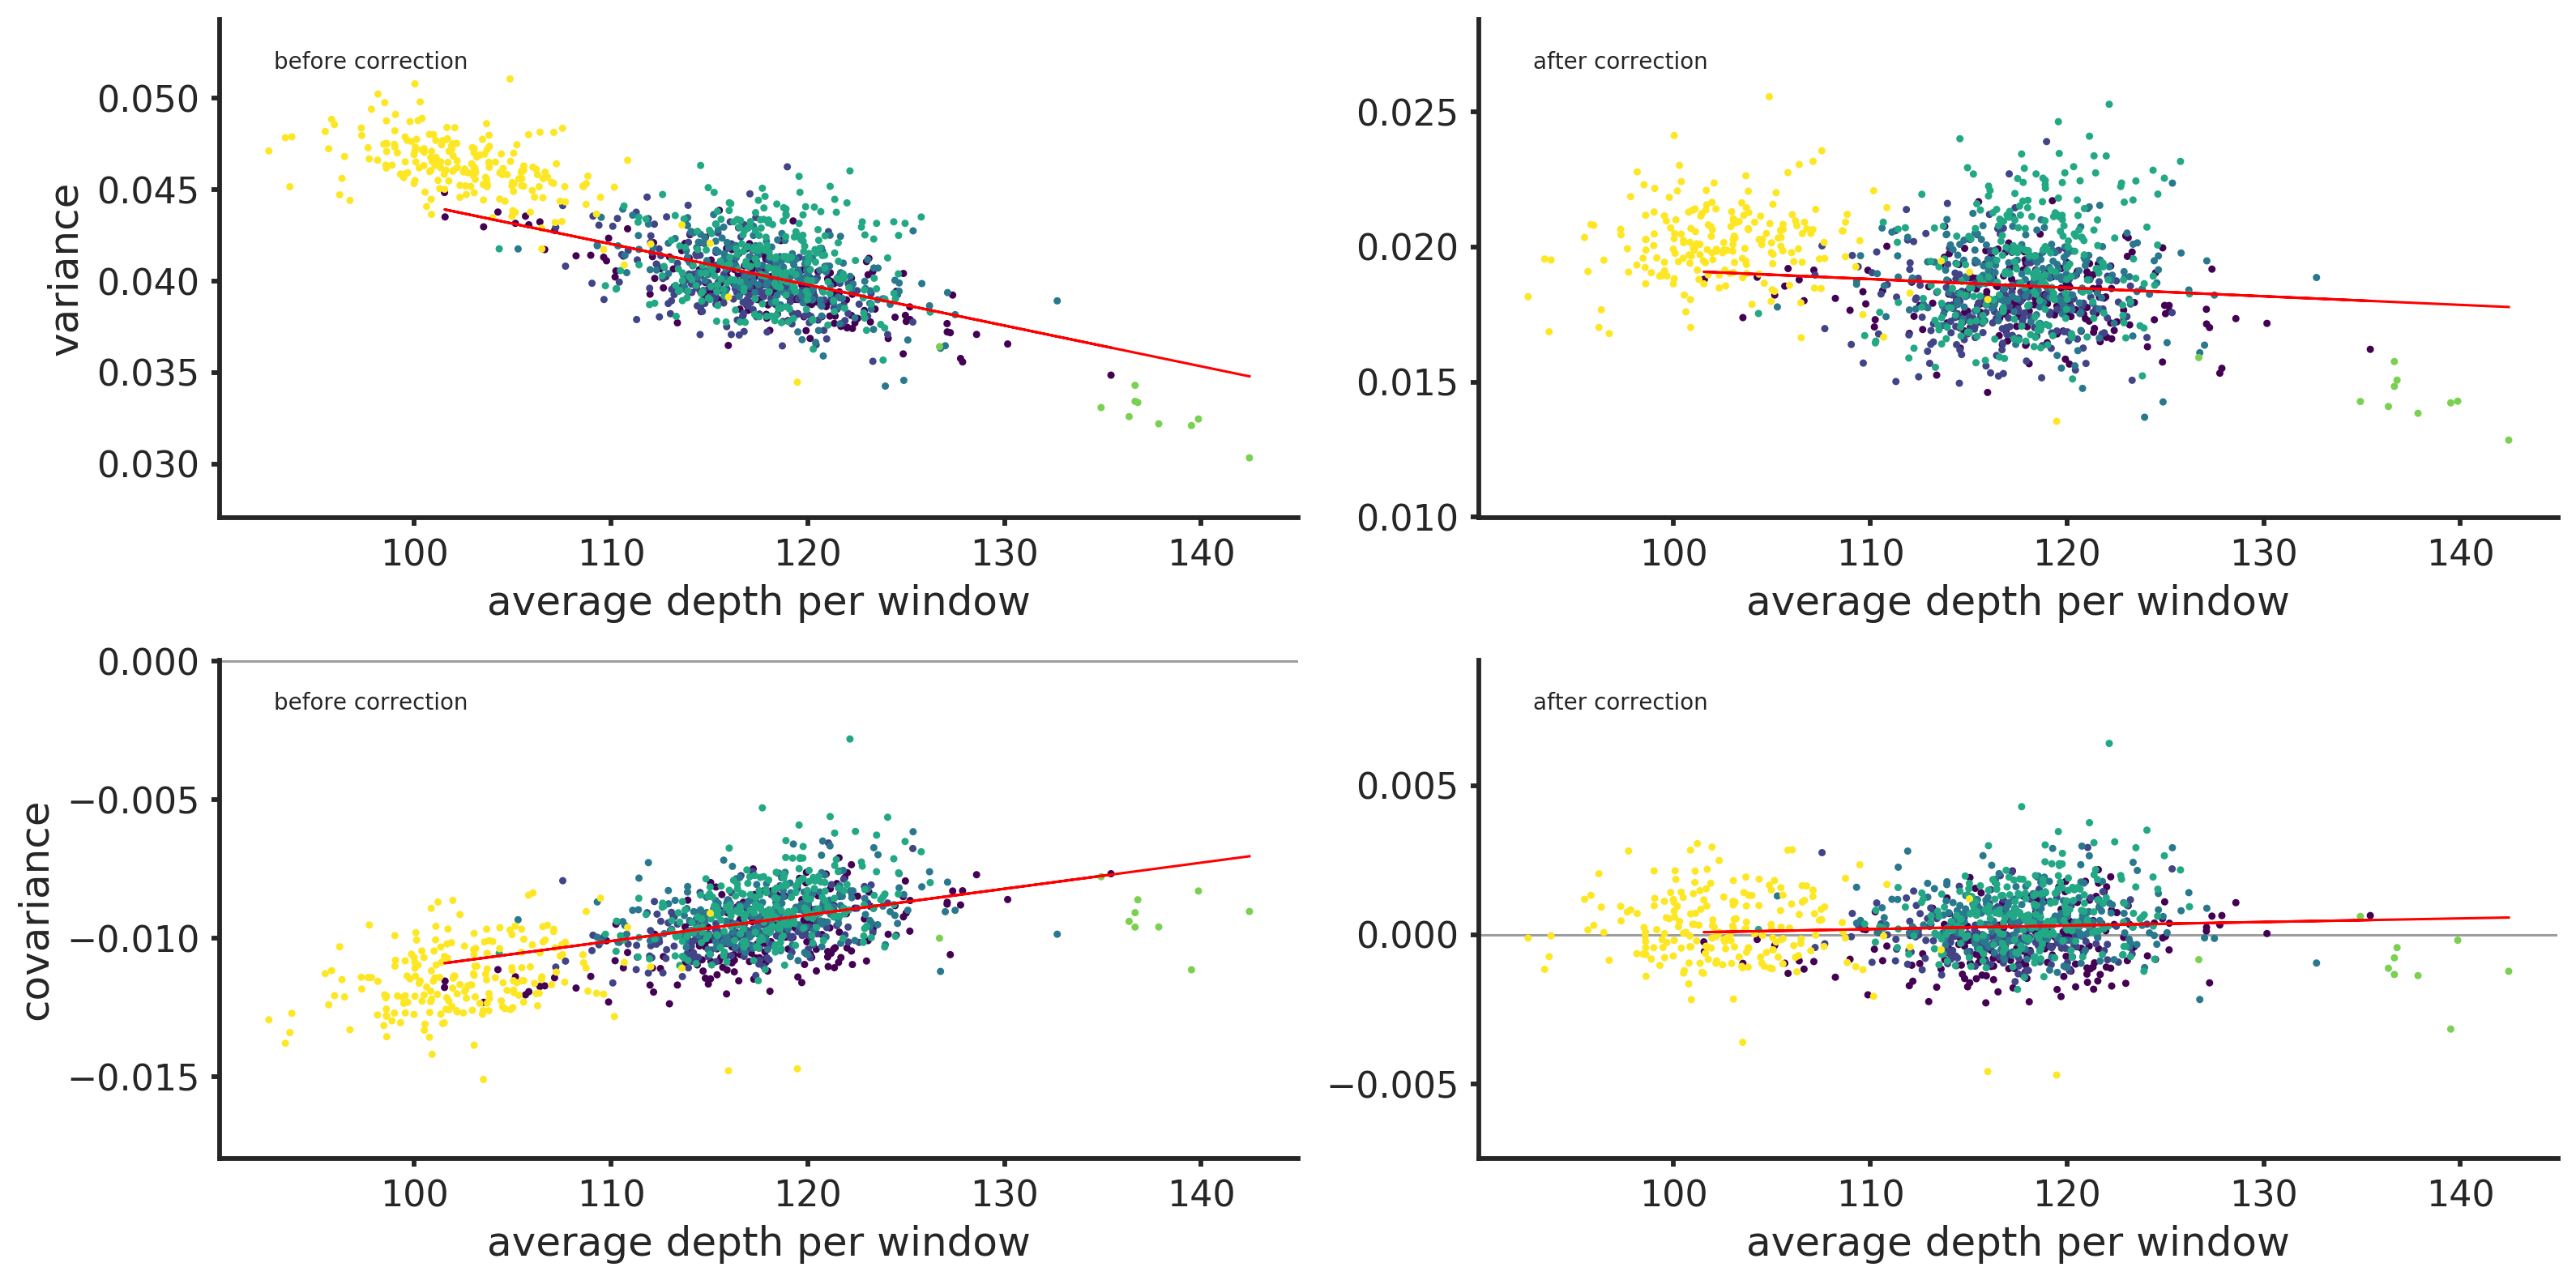

In [130]:
diagnostics = d.correction_diagnostics(min_af=0.05, offdiag_k=1, suppress_warnings=True, exclude_seqids=['X'])
correction_diagnostic_plot(diagnostics)

### Sample sizes for tiled covariance calculations 

Not these are lower in lower recombination regions — making things potentially harder, as the variance around the covariance estimate is higher.

In [ ]:
plt.scatter(d.tile_df['cummidpoint'], np.stack(d.tile_covns).mean(axis=(1,2)), c=integerize(d.tile_df['seqid']))

### Covariances Averaged Across Replicates

In [137]:
CACHED_CIS_AVE_REP = '../data/barghi_et_al_2019/cis_ave_rep_bootstraps.pkl'
FORCE = True
if FORCE or not os.path.exists(CACHED_CIS_AVE_REP):
    cis_ave_rep = d.bootstrap_tempcov(keep_seqids=keep_autos, bootstrap_replicates=False, 
                                      average_replicates=True, alpha=0.05,
                                      B=10000, min_af=0.05, suppress_warnings=True)

    with open(CACHED_CIS_AVE_REP, 'wb') as f:
        pickle.dump(cis_ave_rep, f)
else:
    with open(CACHED_CIS_AVE_REP, 'rb') as f:
        cis_ave_rep = pickle.load(f)

removing 141150140 (40.0%) loci <= 0.05 or >= 0.95


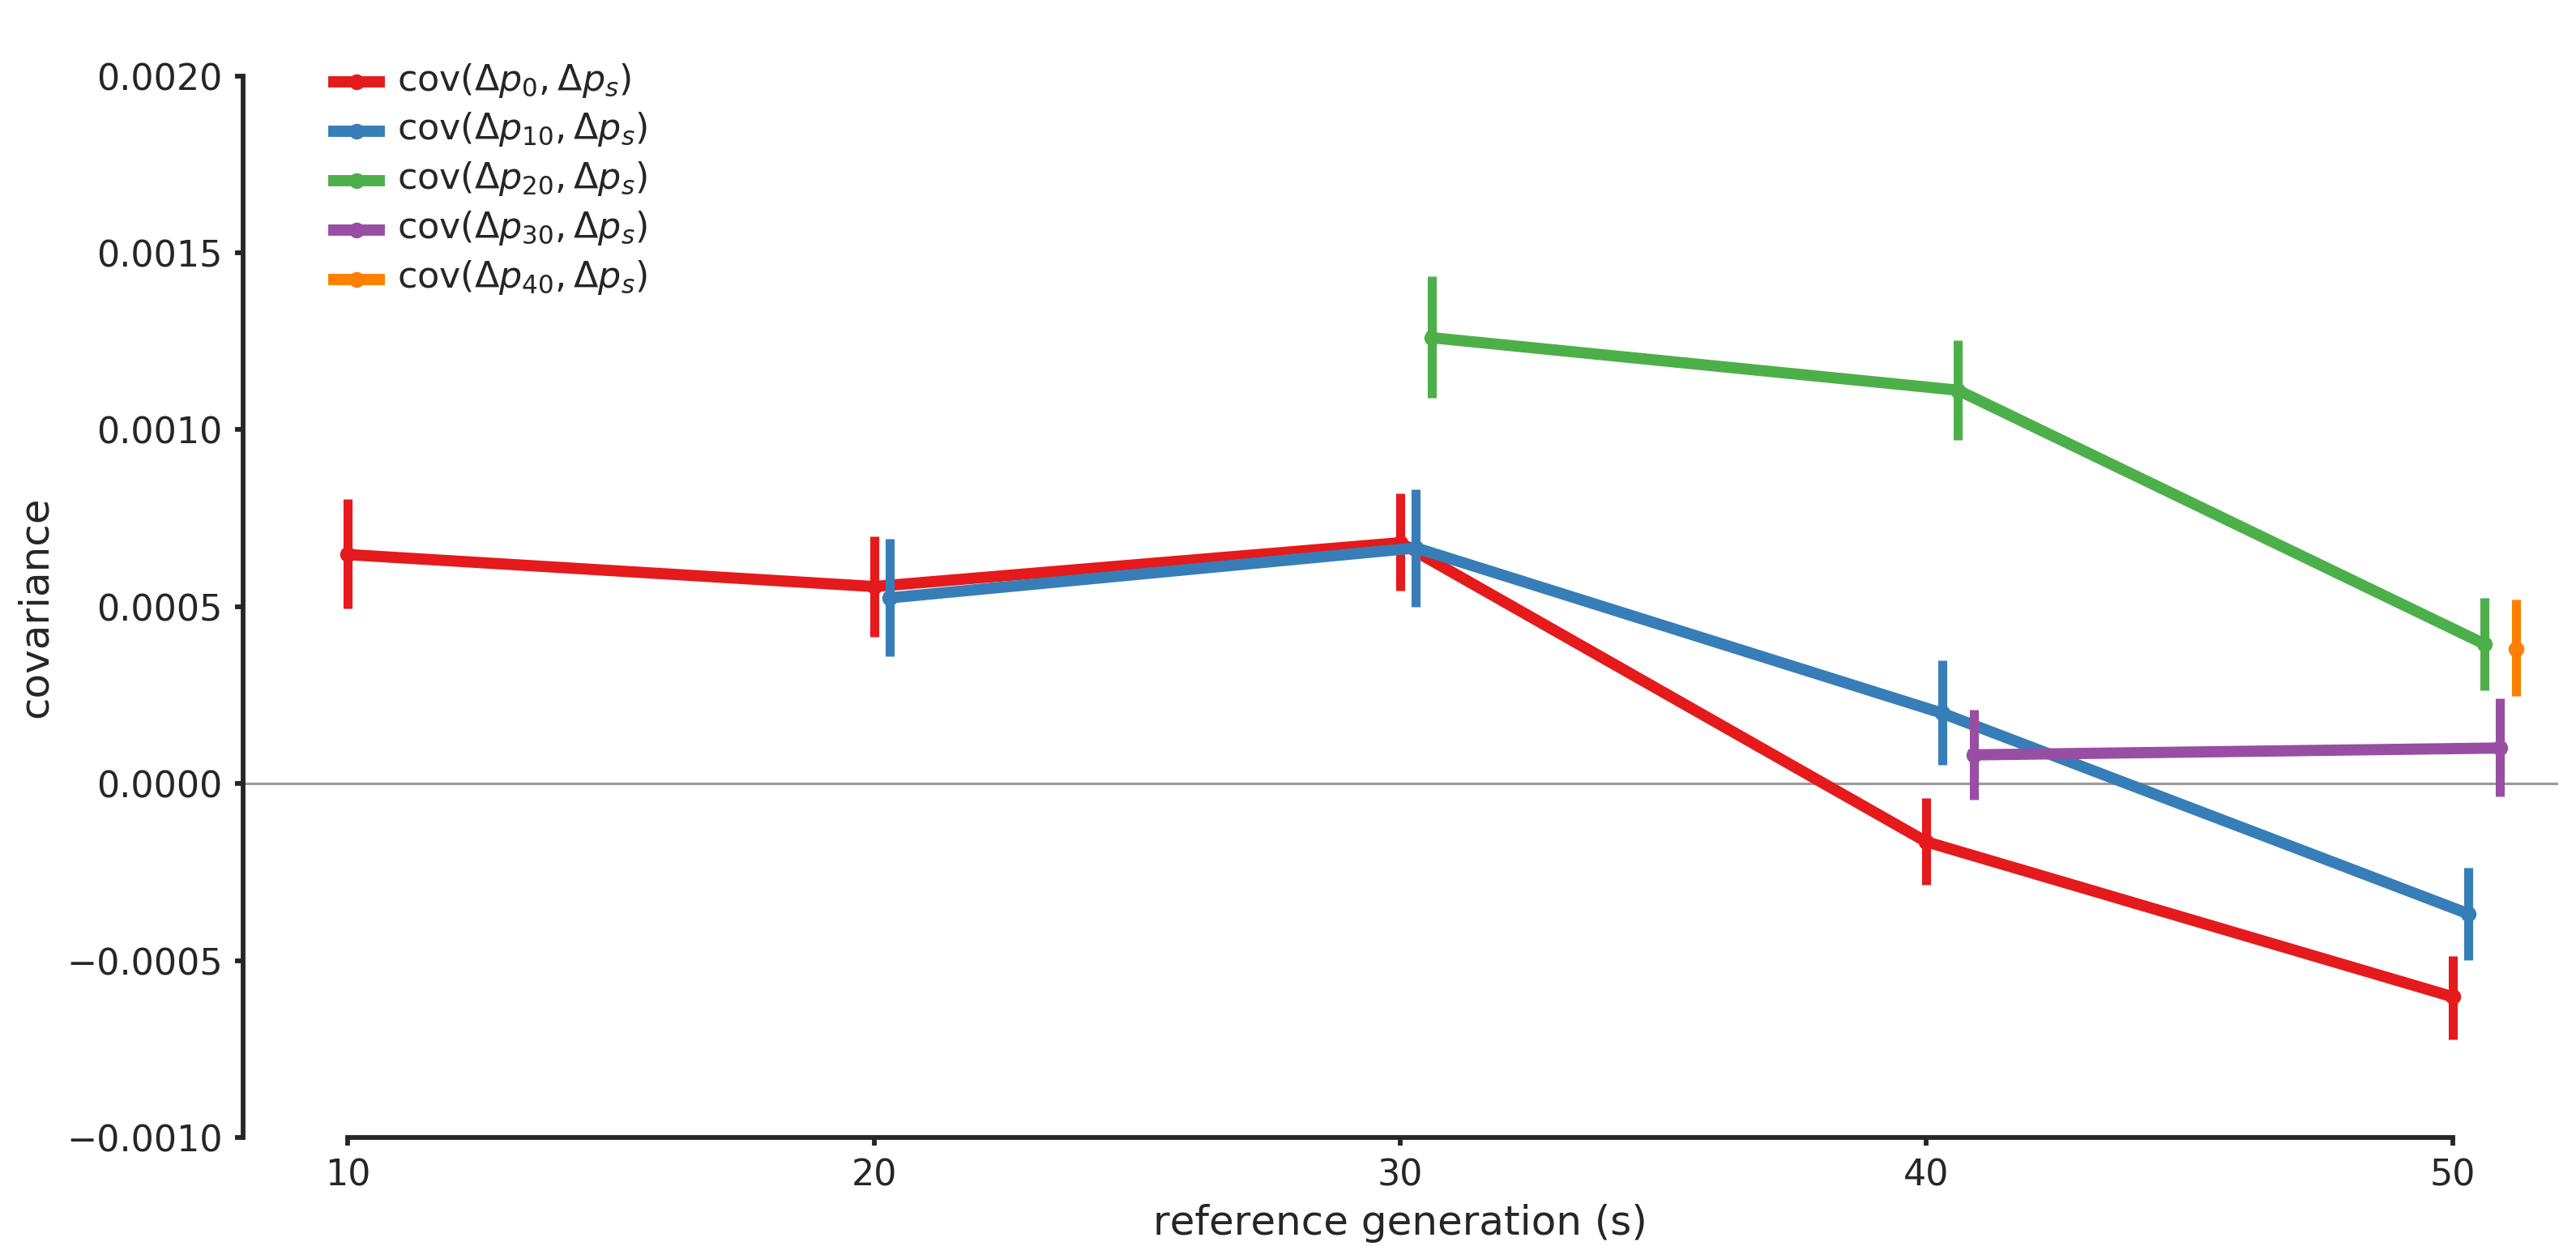

In [138]:
plt.style.use('buffalo-slide.mplstyle')

fig, ax = plt.subplots()
linewidth = 5

def tuple2rgb(x):
    return np.array(x)/255

COLS = [tuple2rgb(x) for x in [(197,27,125), (233,163,201), (253,224,239), (230,245,208), (161,215,106), (77,146,33)]]

cmap = cm.Set1
offset = 0.2
refgens = np.arange(d.T-1)

for refgen in refgens:
    mean = cis_ave_rep[1][refgen, (refgen+1):]
    lower, upper = cis_ave_rep[0][refgen, (refgen+1):]-mean, mean-cis_ave_rep[2][refgen, (refgen+1):]
    x = (np.arange(refgen, refgens.max()+1) +1) * 10
    
    # each x value has refgen datapoints that share an X
    # to disperse these evenly, we center the x positions around 
    offset_x_val = -np.median(range(refgen+1)) + x + 4*refgen/max(x/10)
    
    ax.errorbar(offset_x_val,
                mean.ravel(), yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                capsize=0, elinewidth=linewidth-1, #markeredgewidth=linewidth,
                zorder=refgen, alpha=1, c=cmap(refgen), label=None)
    ax.plot(offset_x_val, 
            mean.ravel(), '-o', linewidth=linewidth, markersize=6,
            label=f"cov($\Delta p_{{{refgen*10}}}, \Delta p_s$)", c=cmap(refgen), zorder=refgen)
    
    ax.axhline(y=0, c='0.6', zorder=-1, alpha=0.5)
    
    #ax.margins(x=1)
    #ax.set_xlim(0.8, 5)
    ax.spines['bottom'].set_bounds(10, 50)

    plt.xlabel("reference generation (s)", fontsize='18')
    plt.ylabel("covariance", fontsize='18')
    plt.ylim((-0.001, 0.002))
    
    plt.xlim((8, 52))
    plt.xticks(np.arange(10, 51, 10))

    plt.legend(loc=(0.02, 0.75))
    plt.setp(plt.gca().get_legend().get_texts(), fontsize='16')
    #plt.savefig(f'images/barghi_et_al_2019/averepg_gw_covs-refgen{refgen}.pdf')
    
    
plt.tight_layout()    
#plt.savefig('images/barghi_et_al_2019/averepg_gw_covs.pdf')
plt.show()


### Covariances by Chromosome

The procedure below averages replicates together, but does not resample the replicates as part of the bootstrap procedure. 

In [ ]:
chrom_cis = dict()
cov_chrs = ['2L', '2R', '3L', '3R', 'X']
for chrom in cov_chrs:
    chrom_cis[chrom] = d.bootstrap_tempcov(keep_seqids=[chrom], bootstrap_replicates=False, 
                                           average_replicates=True, alpha=0.05,
                                           B=10000, min_af=0.05, suppress_warnings=True)

In [ ]:

fig, ax = plt.subplots(ncols=2, nrows=int(np.ceil(len(cov_chrs) / 2)))

# map chrs to grid
idx = np.meshgrid(np.arange(2), np.arange(3))
cols, rows = idx[0].ravel(), idx[1].ravel()

for i, chrom in enumerate(sorted(cov_chrs)):
    dci = np.stack(chrom_cis[chrom])
    refgens = np.arange(5)

    for refgen in refgens:
        mean = dci[1, refgen, (refgen+1):]
        lower, upper = dci[0, refgen, (refgen+1):]-mean, mean-dci[2, refgen, (refgen+1):]
        ax[rows[i], cols[i]].errorbar(np.arange(refgen, refgens.max()+1), mean, yerr=np.column_stack([lower, upper]).T, label=refgen, capsize=2)
        ax[rows[i], cols[i]].axhline(y=0, c='k')
        ax[rows[i], cols[i]].annotate(f"chrom: {chrom}", xy=(0.05, 0.90), xycoords='axes fraction')
plt.show()

### Temporal Covariances by Replicate


In [ ]:
cis = d.bootstrap_tempcov(average_replicates=False, alpha=0.05, keep_seqids=keep_autos, B=10000, min_af=0.05, suppress_warnings=True)
# stack these the CIs in multidimensional array 
dci = np.stack(cis)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=int(d.R/2))

# map chrs to grid
idx = np.meshgrid(np.arange(2), np.arange(int(d.R/2)))
cols, rows = idx[0].ravel(), idx[1].ravel()

refgens = np.arange(5)
for rep in np.arange(d.R):
    for refgen in refgens:
        mean = dci[1, refgen, (refgen+1):, rep]
        lower, upper = dci[0, refgen, (refgen+1):, rep]-mean, mean-dci[2, refgen, (refgen+1):, rep]
        ax[rows[rep], cols[rep]].errorbar(np.arange(refgen, refgens.max()+1), mean, yerr=np.column_stack([lower, upper]).T, label=(rep), capsize=2)
    ax[rows[rep], cols[rep]].axhline(y=0, c='k')
    ax[rows[rep], cols[rep]].annotate(f"rep: {rep}", xy=(0.05, 0.90), xycoords='axes fraction')
plt.show()


### G — the fraction of allele frequency change driven by linked selection

In [78]:
G_cis = d.bootstrap_G(alpha = 0.05, B=1000, min_af=0.05, suppress_warnings=True)

removing 141150665 (40.0%) loci <= 0.05 or >= 0.95


/home/vinceb/projects/optimshifttemp/cvtk/covmethods.py:123: RuntimeWarning: invalid value encountered in double_scalars
  df = cov_matrix_to_dataframe(this_mat)
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


removing 141150665 (40.0%) loci <= 0.05 or >= 0.95
removing 141150665 (40.0%) loci <= 0.05 or >= 0.95
removing 141150665 (40.0%) loci <= 0.05 or >= 0.95
removing 141150665 (40.0%) loci <= 0.05 or >= 0.95
removing 141150665 (40.0%) loci <= 0.05 or >= 0.95
removing 141150665 (40.0%) loci <= 0.05 or >= 0.95


In [79]:
G_cis_averep = d.bootstrap_G(alpha = 0.05, B=1000, min_af=0.05, average_replicates=True, suppress_warnings=True)

removing 141150665 (40.0%) loci <= 0.05 or >= 0.95


/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


removing 141150665 (40.0%) loci <= 0.05 or >= 0.95
removing 141150665 (40.0%) loci <= 0.05 or >= 0.95
removing 141150665 (40.0%) loci <= 0.05 or >= 0.95
removing 141150665 (40.0%) loci <= 0.05 or >= 0.95
removing 141150665 (40.0%) loci <= 0.05 or >= 0.95
removing 141150665 (40.0%) loci <= 0.05 or >= 0.95


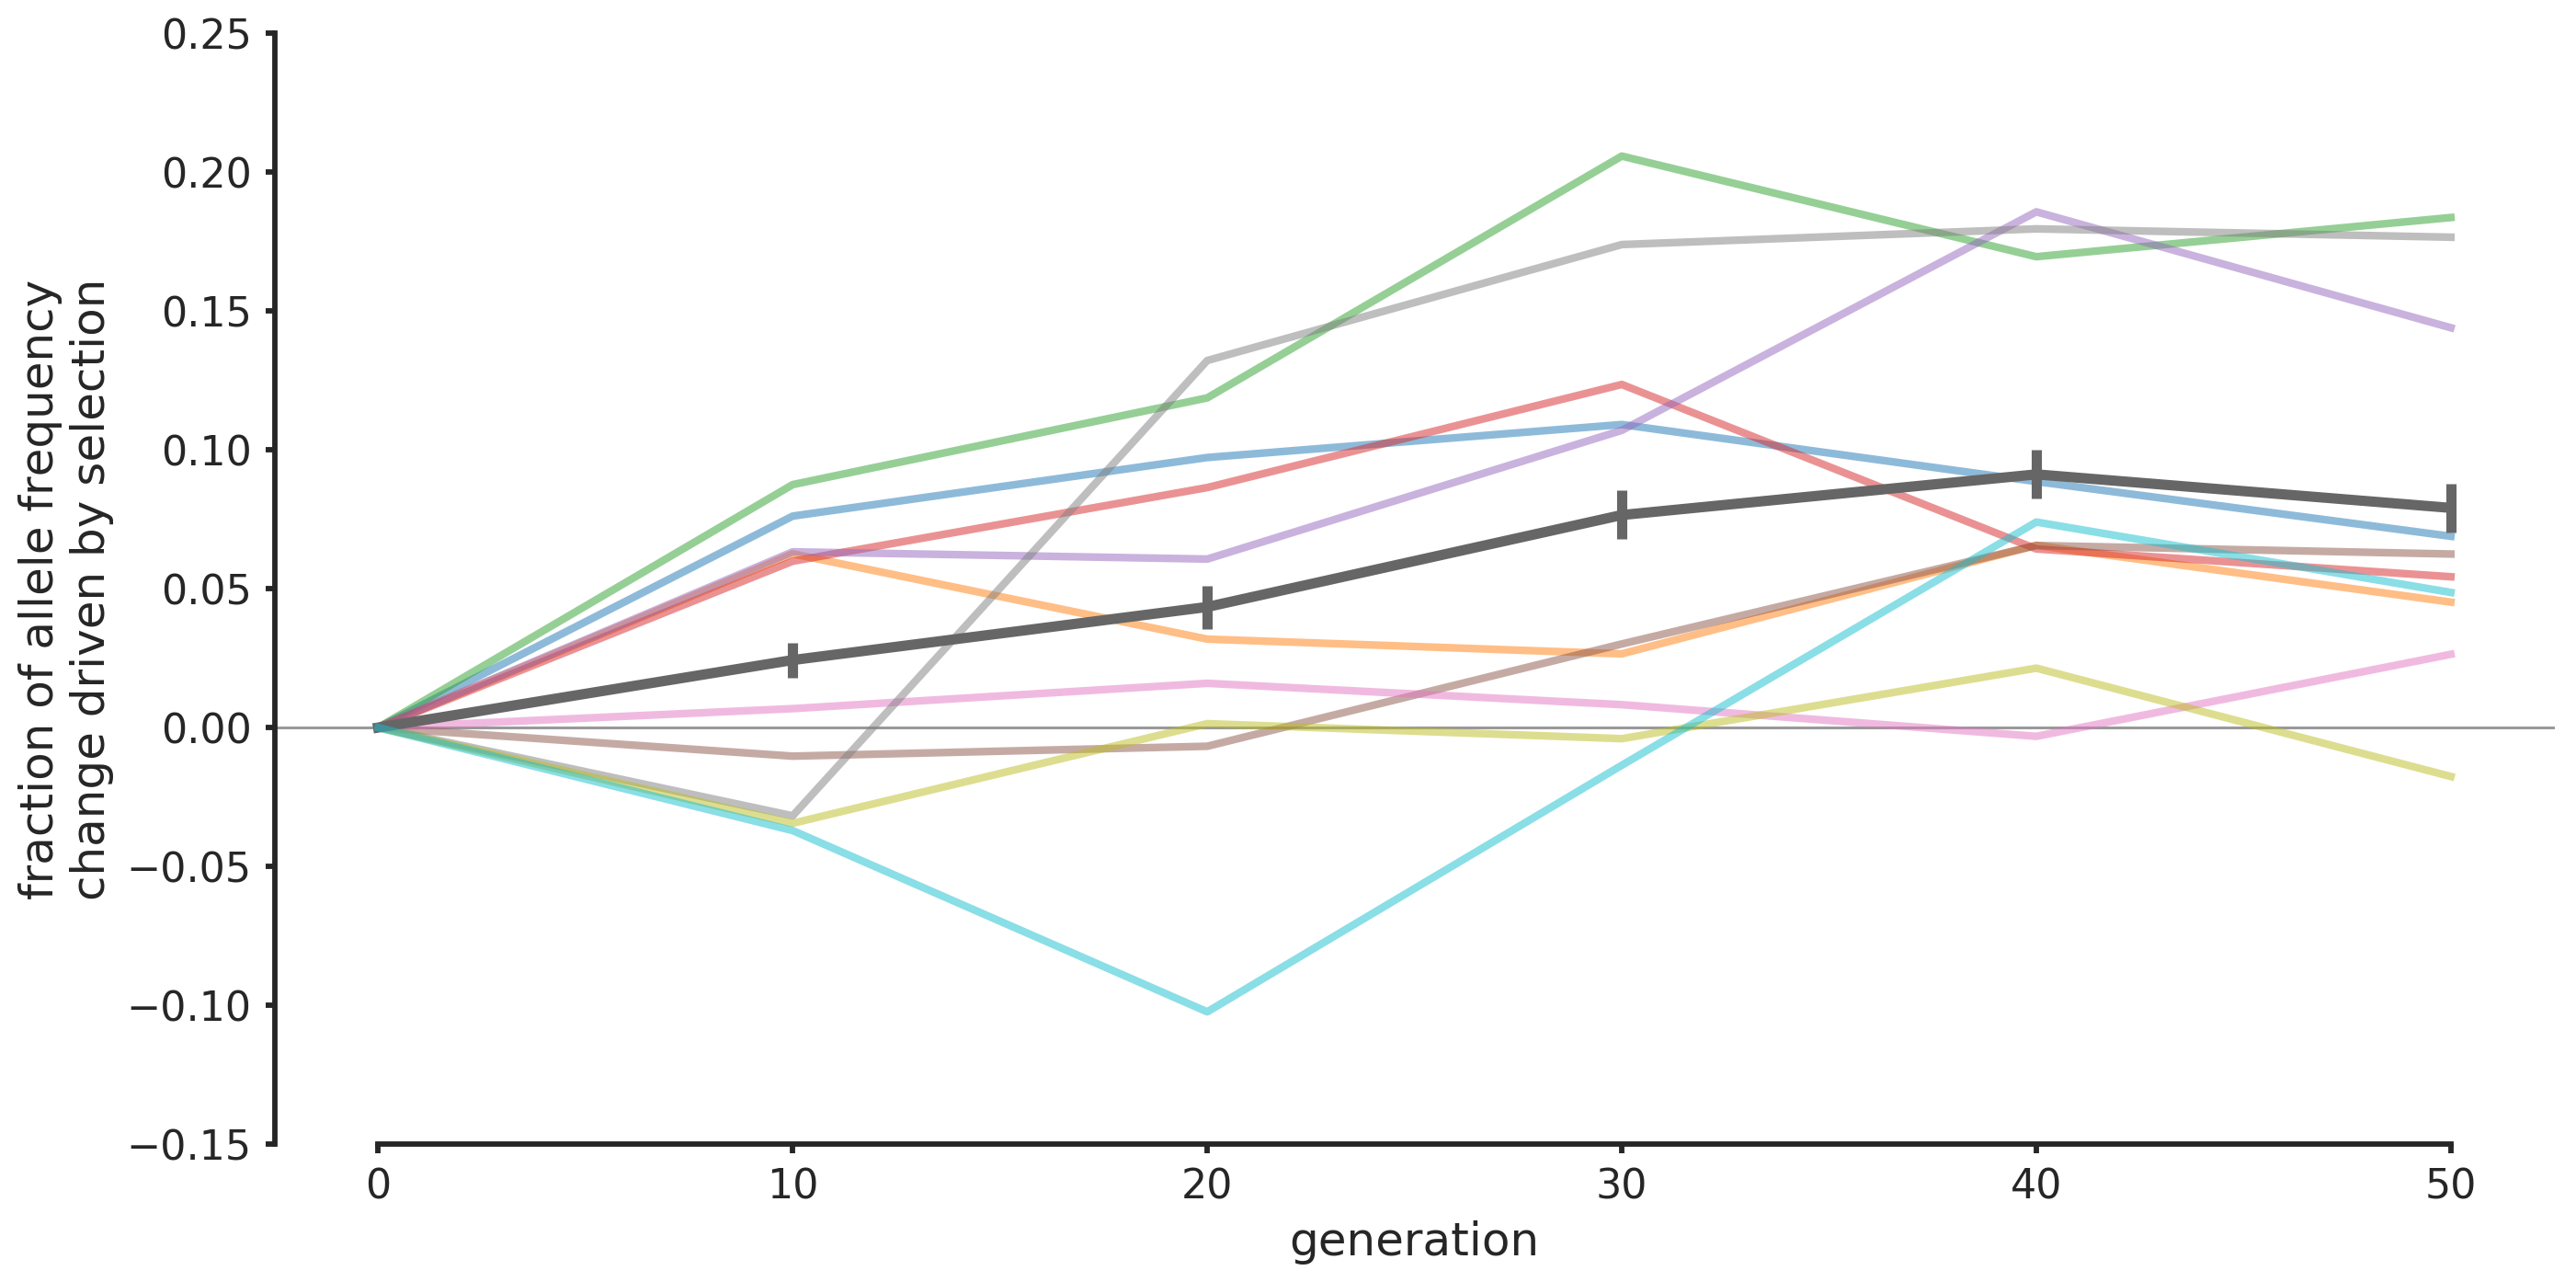

In [272]:
plt.style.use('buffalo-slide.mplstyle')

fig, ax = plt.subplots()

cols = plt.get_cmap('tab10')
alpha = 0.5
G_cis[1, -1, :]


for i, rep in enumerate(np.argsort(G_cis[1, -1, :])[::-1]):
    mean = G_cis[1, 1:, rep]
    lower, upper = G_cis[0, 1:, rep]-mean, mean-G_cis[2, 1:, rep]
    x = np.arange(0, d.T)

    #xp = [-0.08 + y + i * 0.02 if y != 1 else 1 for y in x]
    xp = x * 10
    ax.plot(xp, mean.ravel(), '-o', linewidth=3, 
            #c='k',
            c=cols(rep), alpha=alpha,
            zorder=rep, markersize=0)
#     ax.errorbar(xp, mean.ravel(),
#                 yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
#                 label=rep, capsize=0, linewidth=2,
#                 #c='k', 
#                 c=cols(rep), 
#                 zorder=rep, alpha=alpha)

    
# average G (across replicates)
mean = G_cis_averep[1, 1:]
lower, upper = G_cis_averep[0, 1:]-mean, mean-G_cis_averep[2, 1:]
x = np.arange(1, d.T+1) * 10

# ax.plot(x, mean.ravel(), '-o', linewidth=3, 
#         c='k',
#         zorder=rep, markersize=2)
ax.errorbar(xp, mean.ravel(),
            yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
            label=rep, capsize=0, linewidth=4, elinewidth=4,
            c='0.4', 
            zorder=rep)

ax.spines['bottom'].set_bounds(0, 50)
#ax.spines['left'].set_bounds(-0.0832, 0.21)
ax.spines['left'].set_bounds(-0.15, 0.25)
# ax.set_xlim(0.5, 6.5)
ax.set_ylim(-0.15, 0.25)
ax.axhline(y=0, c='0.6')
plt.xlabel("generation", fontsize='18')
#plt.ylabel(r"G = $\frac{\sum_{i \ne j} \mathrm{cov}(\Delta p_i, \Delta p_j)}{\mathrm{var}(p_{60} - p_0)}$", fontsize='18')
plt.ylabel("fraction of allele frequency\nchange driven by selection", fontsize='18')
#plt.legend()
plt.savefig('images/barghi_et_al_2019/rep_G_ave_G.pdf')
plt.show()

In [ ]:
d.calc_covs(min_af=0.05)
reps = np.broadcast_to(np.arange(10), (7, 10))
G = np.stack([d._G(t) for t in np.arange(d.T+1)])

x = np.repeat(np.arange(7), 10).reshape((7, 10))
for rep in np.arange(d.R):
    plt.plot(x[:, rep], G[:, rep], '-', label=rep)
    plt.axhline(y=0, c='k')
plt.legend(loc='upper left')
plt.show()

## Covariances Between Replicates

In [167]:
repcis = d.bootstrap_repcov(alpha=0.05, keep_seqids=keep_autos, B=10000, min_af=0.05, suppress_warnings=True)

removing 141150658 (40.0%) loci <= 0.05 or >= 0.95


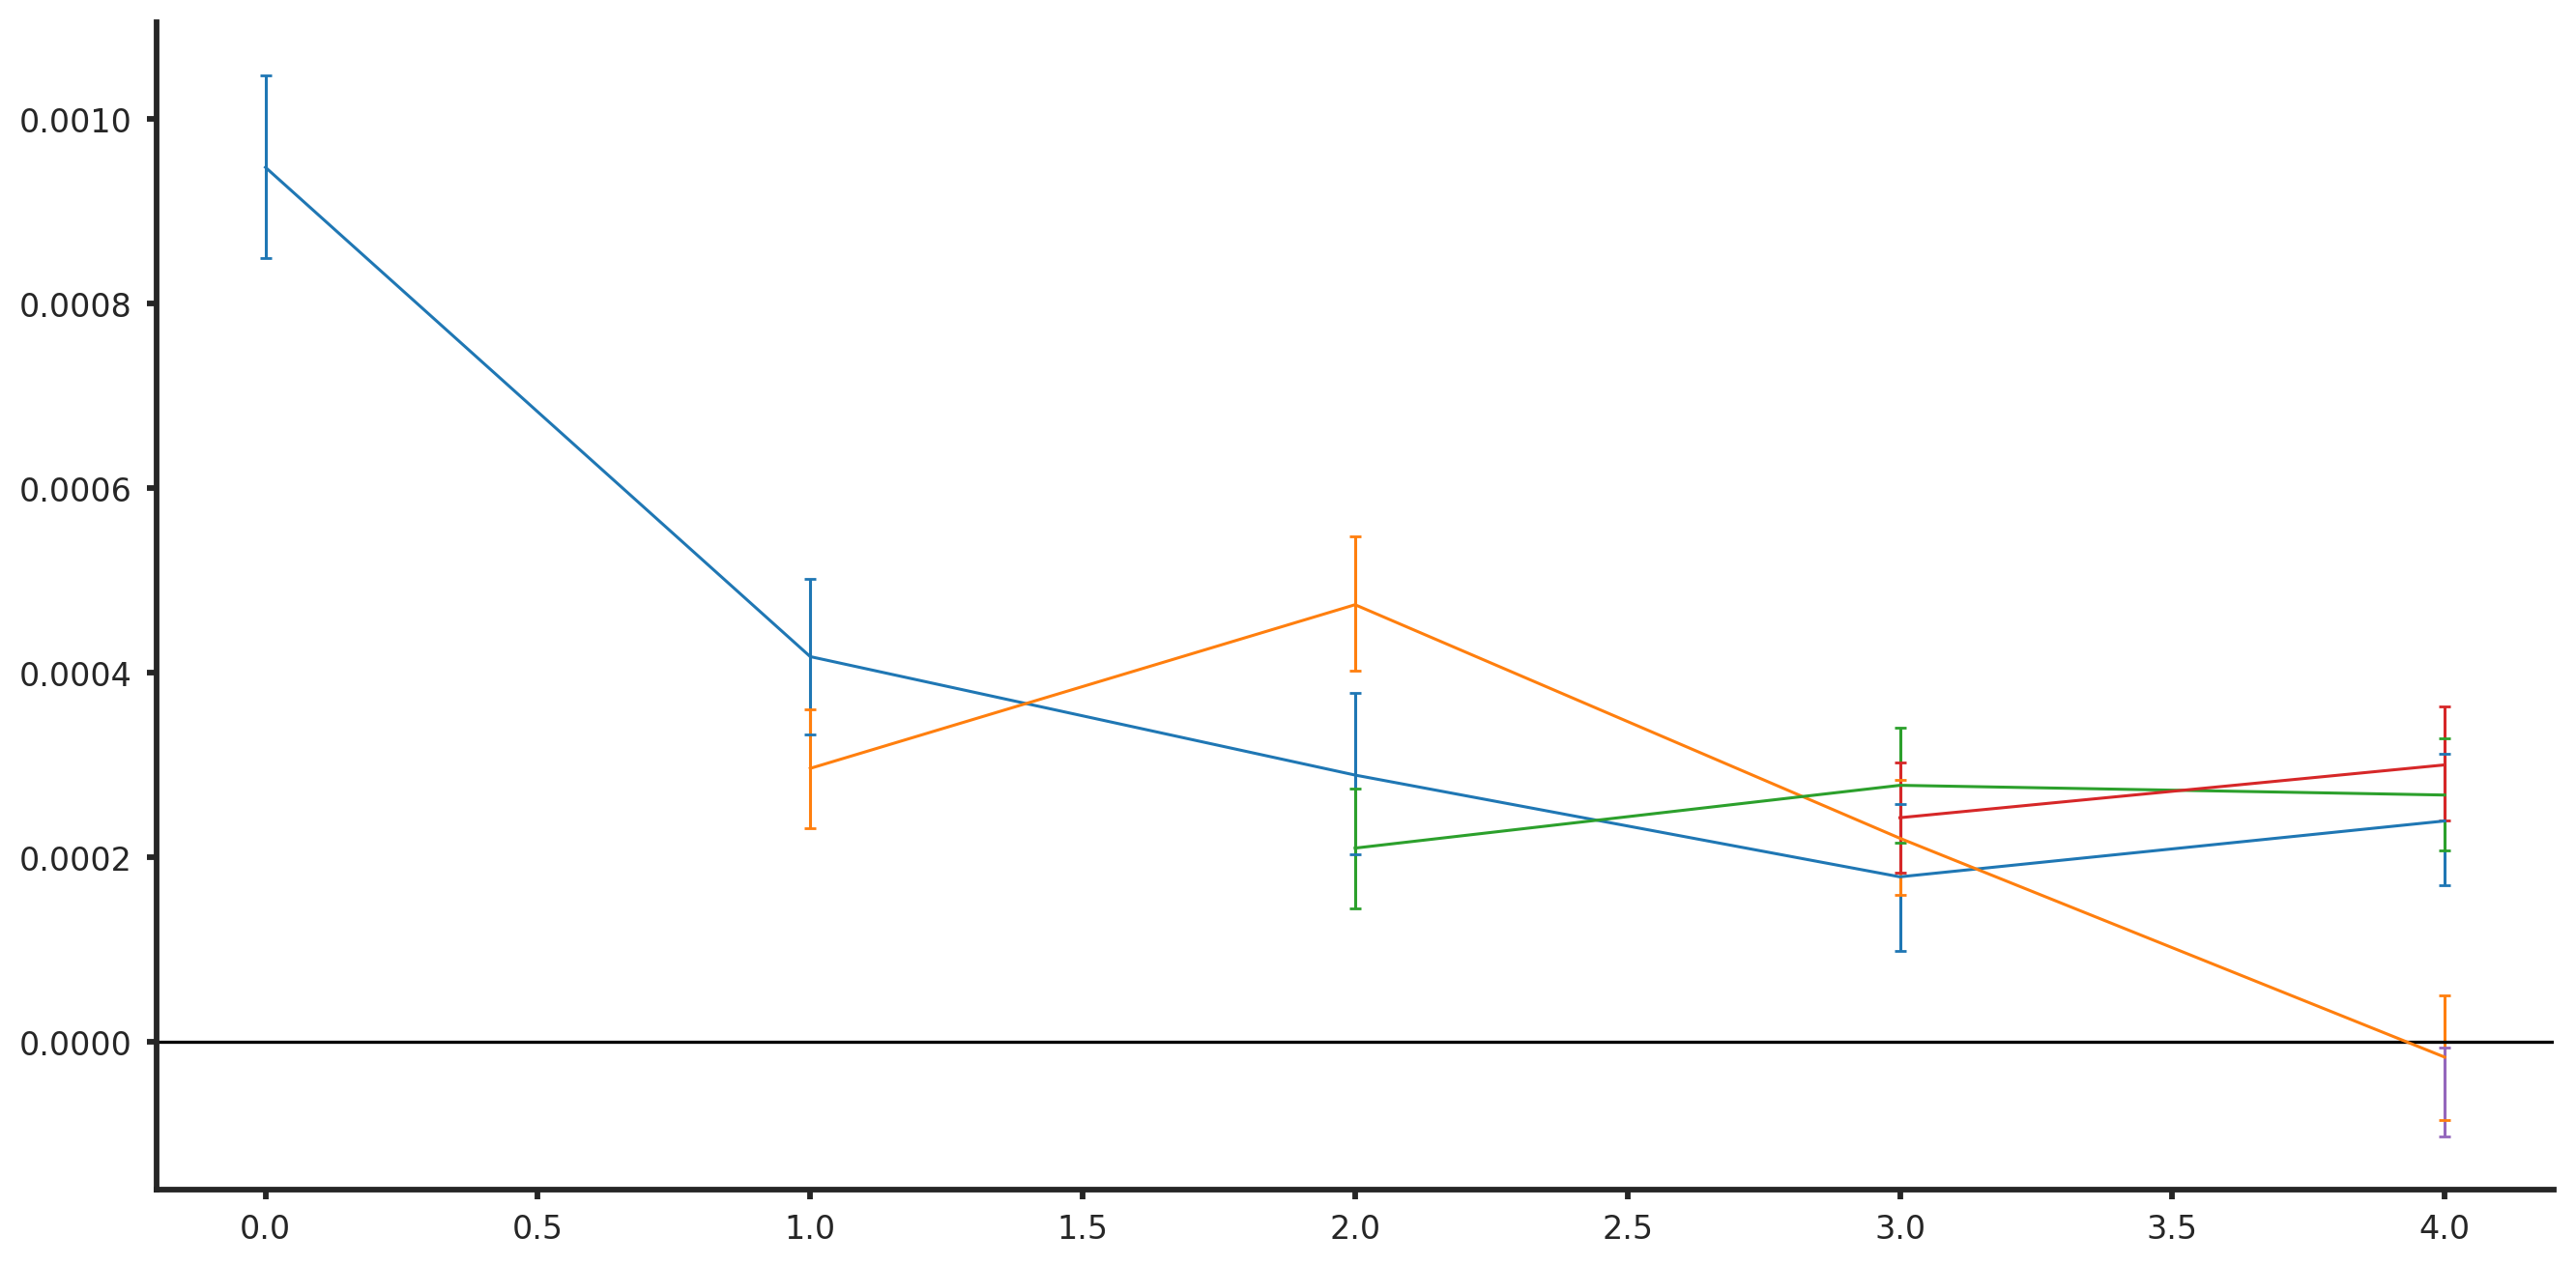

In [485]:
rdci = np.stack(repcis)

refgens = np.arange(5)
for refgen in refgens:
    mean = rdci[1, refgen, (refgen+1):]
    lower, upper = rdci[0, refgen, (refgen+1):]-mean, mean-rdci[2, refgen, (refgen+1):]
    plt.errorbar(np.arange(refgen, refgens.max()+1), mean, yerr=np.column_stack([lower, upper]).T, label=(rep), capsize=2)

    plt.axhline(y=0, c='k')
plt.show()
# plt.xticks(np.arange(1, 6), [f"$cov(\Delta p_{{t}}, \Delta p_{{{10*(i+1)}}})$" for i in np.arange(1, 6)])
# plt.legend()
# plt.show()


## Tile Covariance Figures

In [615]:
td = pd.read_feather('../data/barghi_et_al_2019/barghi-covariances-0.05.feather')
# remove chr 4 and X
td = td[td['seqid'].isin(keep_autos)]
# keep only adjacent measures
td = td[np.abs(td['t'] - td['s']) <= 1]
td['comp'] = ['var' if t == s else 'cov' for t, s in zip(td['t'], td['s'])]
td['label'] = [f'Var($\Delta p_{t}$)' if t == s else f'Cov($\Delta p_{t}, \Delta p_{s}$)' for t, s in zip(td['t'], td['s'])]

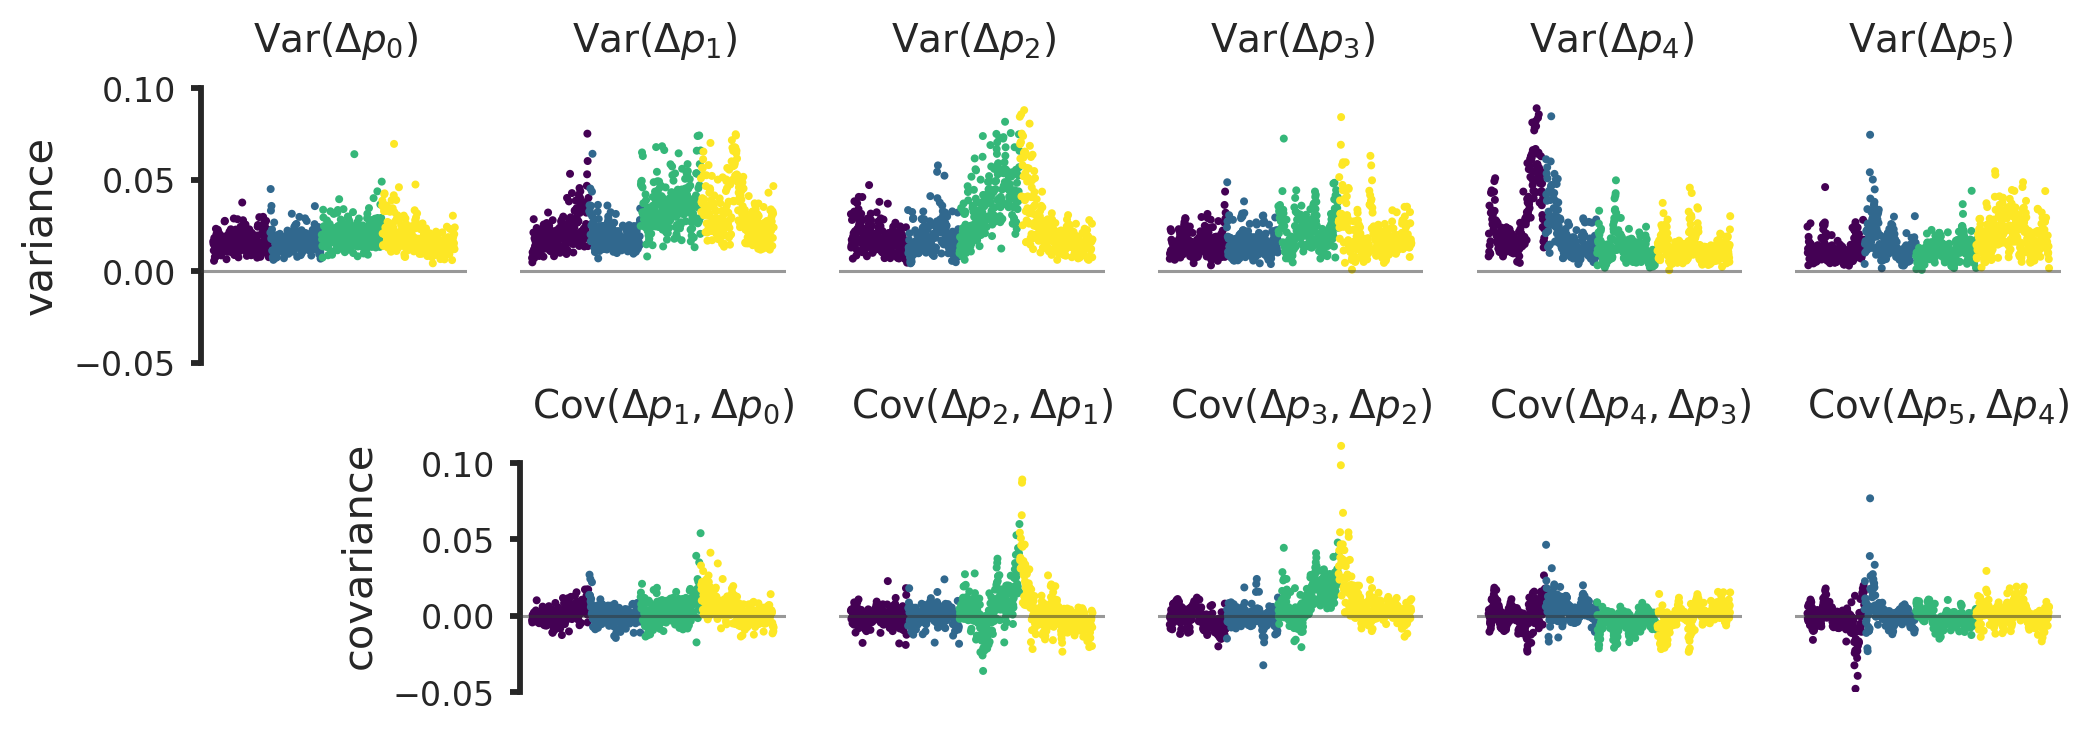

In [662]:
# = set([(t, s) for t, s in zip(td['t'], td['s'])])
cs = np.array((215,25,28))/255, np.array((253,174,97))/255, np.array((171,221,164))/255, np.array((43,131,186))/255
cols = td['t'].unique()
fig, ax = plt.subplots(ncols=len(cols), nrows=2, figsize=(12, 4))
for i, t in enumerate(cols):
    for j in range(2):
        panel_df = td[(td['t'] == t) & (td['rep_a'] == 2)]
        if (j == 0):
            panel_df = panel_df[panel_df['s'] == panel_df['t']]
        else:
            panel_df = panel_df[panel_df['s'] != panel_df['t']]
        if i != 0 or j != 1:
            ax[j, i].axhline(0, zorder=10, c='0.20', alpha=0.5)
            
        ax[j, i].scatter(panel_df['cummidpoint'], panel_df['cov'], c=integerize(panel_df['seqid']), s=3.5, cmap='viridis')

        if i > 0:
            ax[j, i].yaxis.set_visible(False)
            ax[j, i].spines['left'].set_visible(False)
            
        try:
            lab = panel_df['label'].unique()[0]
        except:
            pass
        mid = np.max(panel_df['cummidpoint'])

        # ignore the variance we don't have
        if i == 0 and j == 1:
            ax[j, i].yaxis.set_visible(False)
            ax[j, i].spines['left'].set_visible(False)
            ax[j, i].spines['bottom'].set_visible(False)
        if j > 0:
            # covaraince row
            ax[j, i].xaxis.set_visible(True)
            #ax[j, i].set_xticks(['2L', '3L', '2R', '3R'])
            ax[j, i].set_xticks([])
            ax[j, i].set_ylim((-0.05, 0.13))
            ax[j, i].spines['bottom'].set_visible(False)
            if i > 0:
                ax[j, i].text(0, 0.13, lab, fontsize=14)
            ax[j, i].set_ylabel('covariance')
        else:
            # variance row
            ax[j, i].set_ylim((-0.05, 0.1))
            ax[j, i].spines['bottom'].set_visible(False)
            ax[j, i].xaxis.set_visible(False)
            ax[j, i].text(mid/6, 0.12, lab, fontsize=14)
            ax[j, i].set_ylabel('variance')
            
        if j == 1 and i == 1:
            ax[j, i].yaxis.set_visible(True)
            ax[j, i].spines['left'].set_visible(True)
            ax[j, i].set_ylim((-0.05, 0.13))
            ax[j, i].spines['left'].set_bounds(-0.05, 0.10)
        if j == 1 and i == 0:
            pass
            #ax[j, i].legend()
            
plt.savefig('images/barghi_et_al_2019/rep-2-vars-covs.pdf')        
#plt.tight_layout()
plt.show()

## Tile-specific linked selection effect estimation

In [333]:
a = np.stack([np.stack([repcov for repcov in stack_temporal_covariances(x, d.R, d.T)]) for x in d.tile_covs])
res = optimal_N_svd(a, 0)

# SCRATCH

In [ ]:
## per tile
a = optimal_N_svd(tile_tempcovs, 0)
plt.scatter(d.tile_df['cummidpoint'], [1 / (2*np.diag(tile_tempcovs[i, :, :, 0]).mean()) for i in np.arange(0, tile_tempcovs.shape[0])], c=integerize(d.tile_df['seqid']))

In [27]:
repcis = d.bootstrap_repcov(average_replicates=True, alpha=0.05, keep_seqids=keep_autos, B=10000, min_af=0.05, suppress_warnings=True)

removing 141149031 (40.0%) loci <= 0.05 or >= 0.95


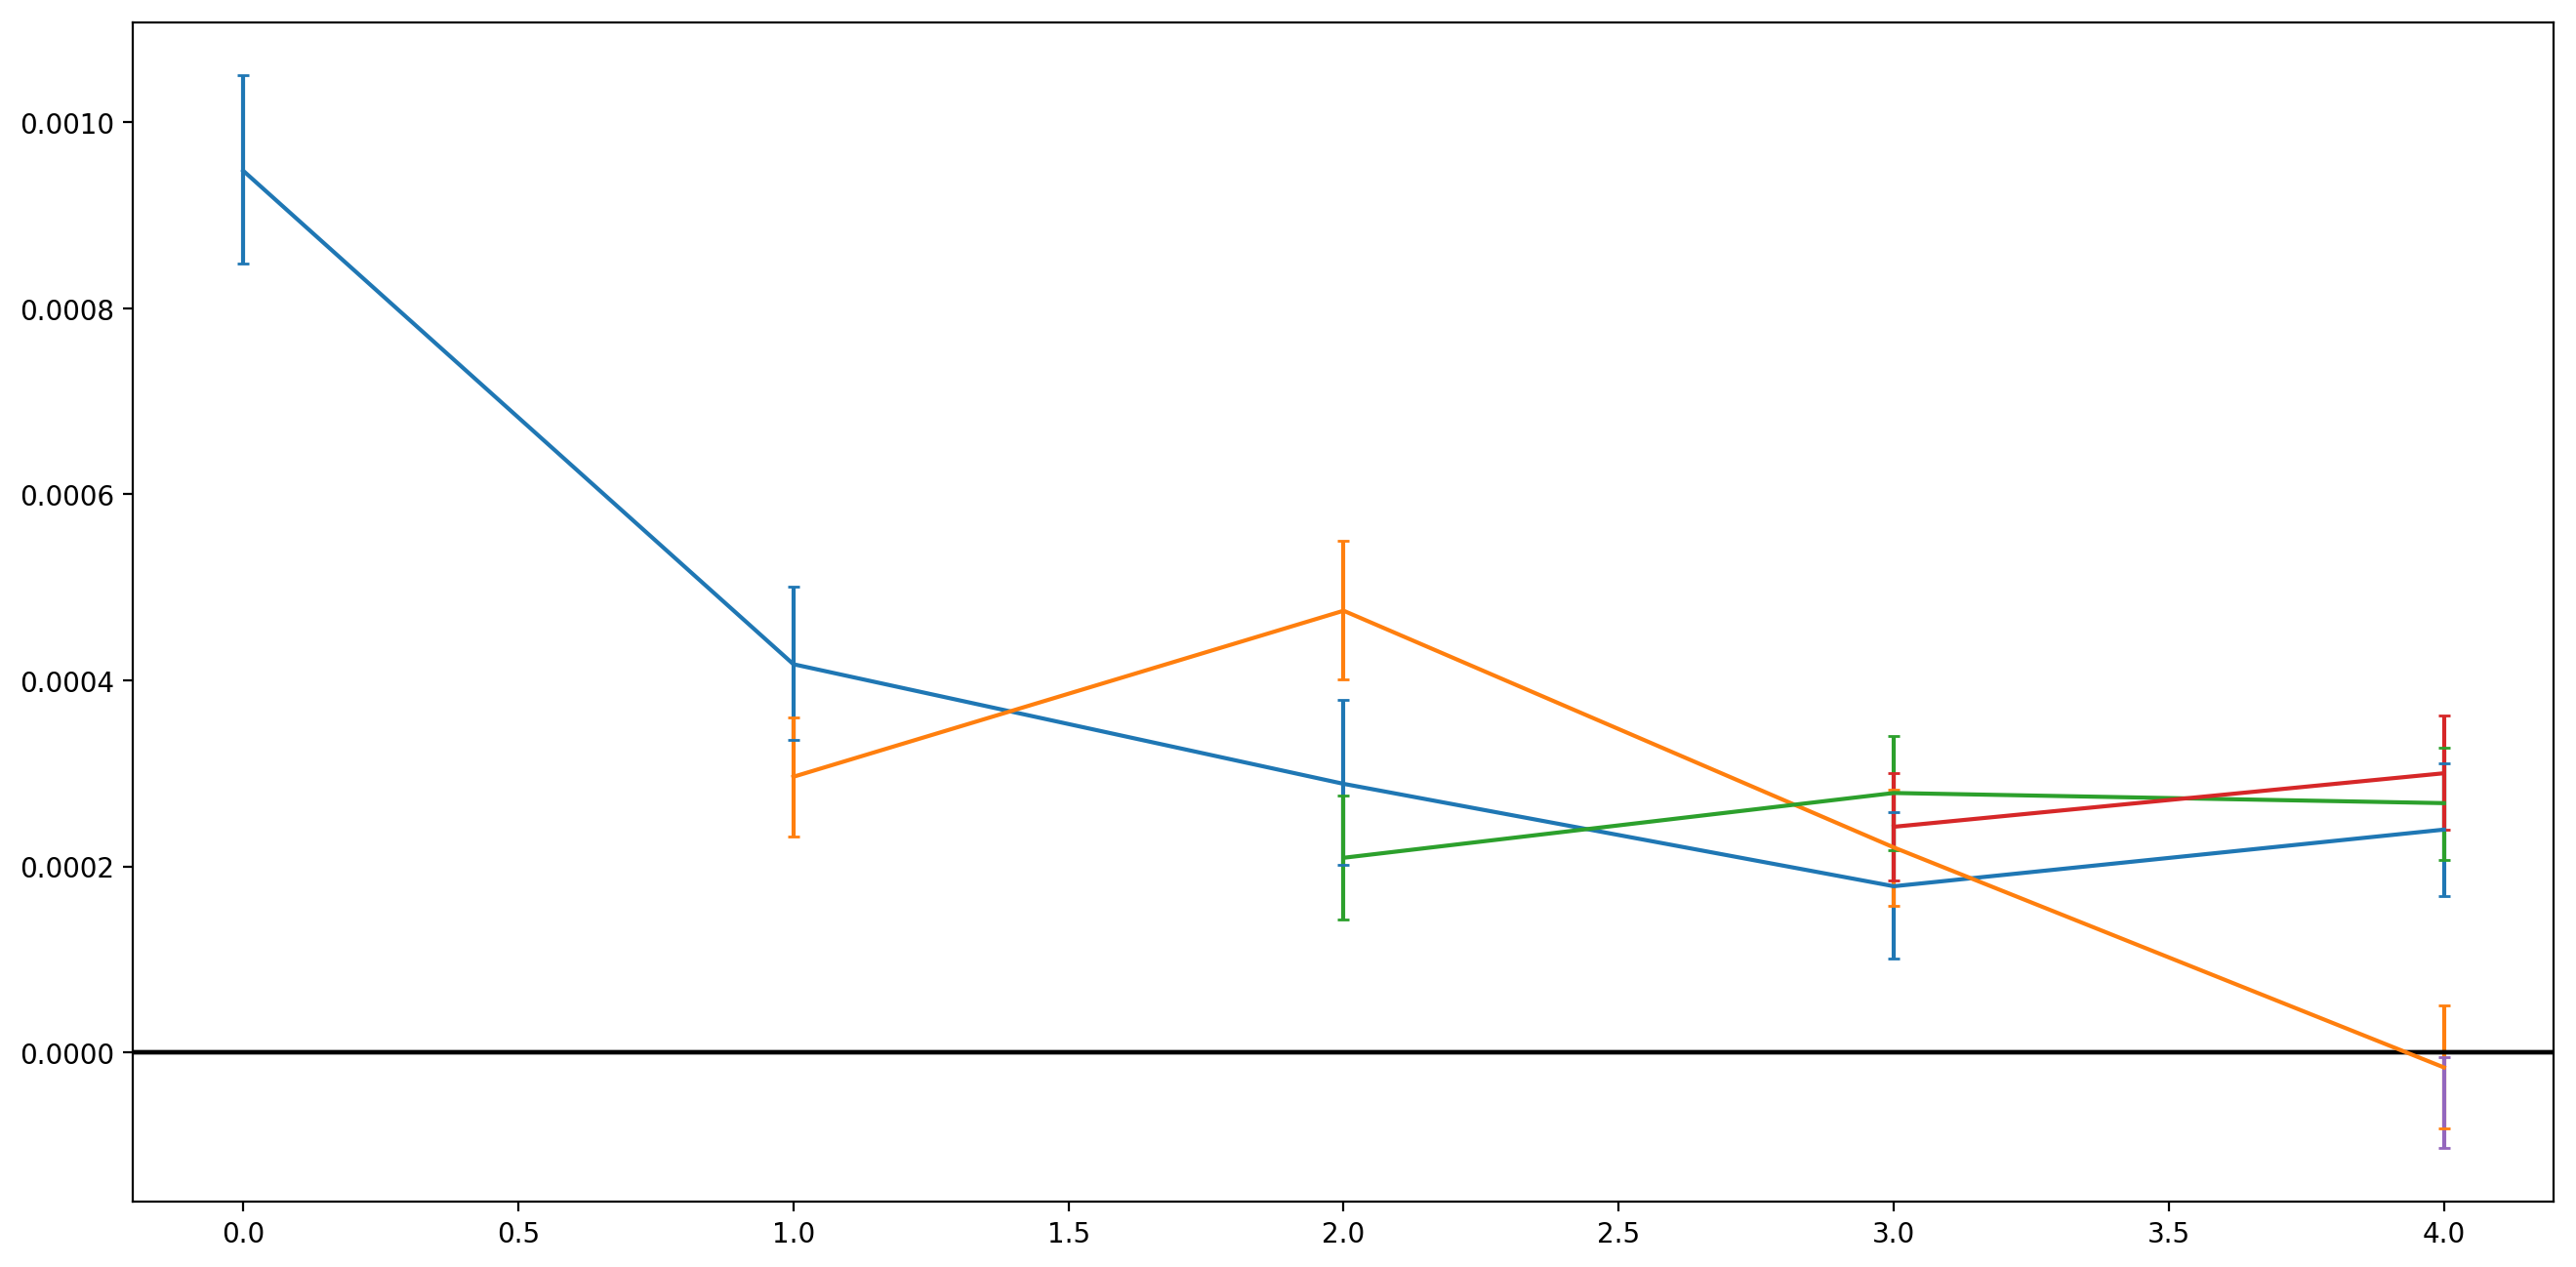

In [28]:
rdci = np.stack(repcis)

refgens = np.arange(5)
for refgen in refgens:
    mean = rdci[1, refgen, (refgen+1):]
    lower, upper = rdci[0, refgen, (refgen+1):]-mean, mean-rdci[2, refgen, (refgen+1):]
    plt.errorbar(np.arange(refgen, refgens.max()+1), mean, yerr=np.column_stack([lower, upper]).T, label=(refgen), capsize=2)

    plt.axhline(y=0, c='k')
plt.show()
# plt.xticks(np.arange(1, 6), [f"$cov(\Delta p_{{t}}, \Delta p_{{{10*(i+1)}}})$" for i in np.arange(1, 6)])
# plt.legend()
# plt.show()


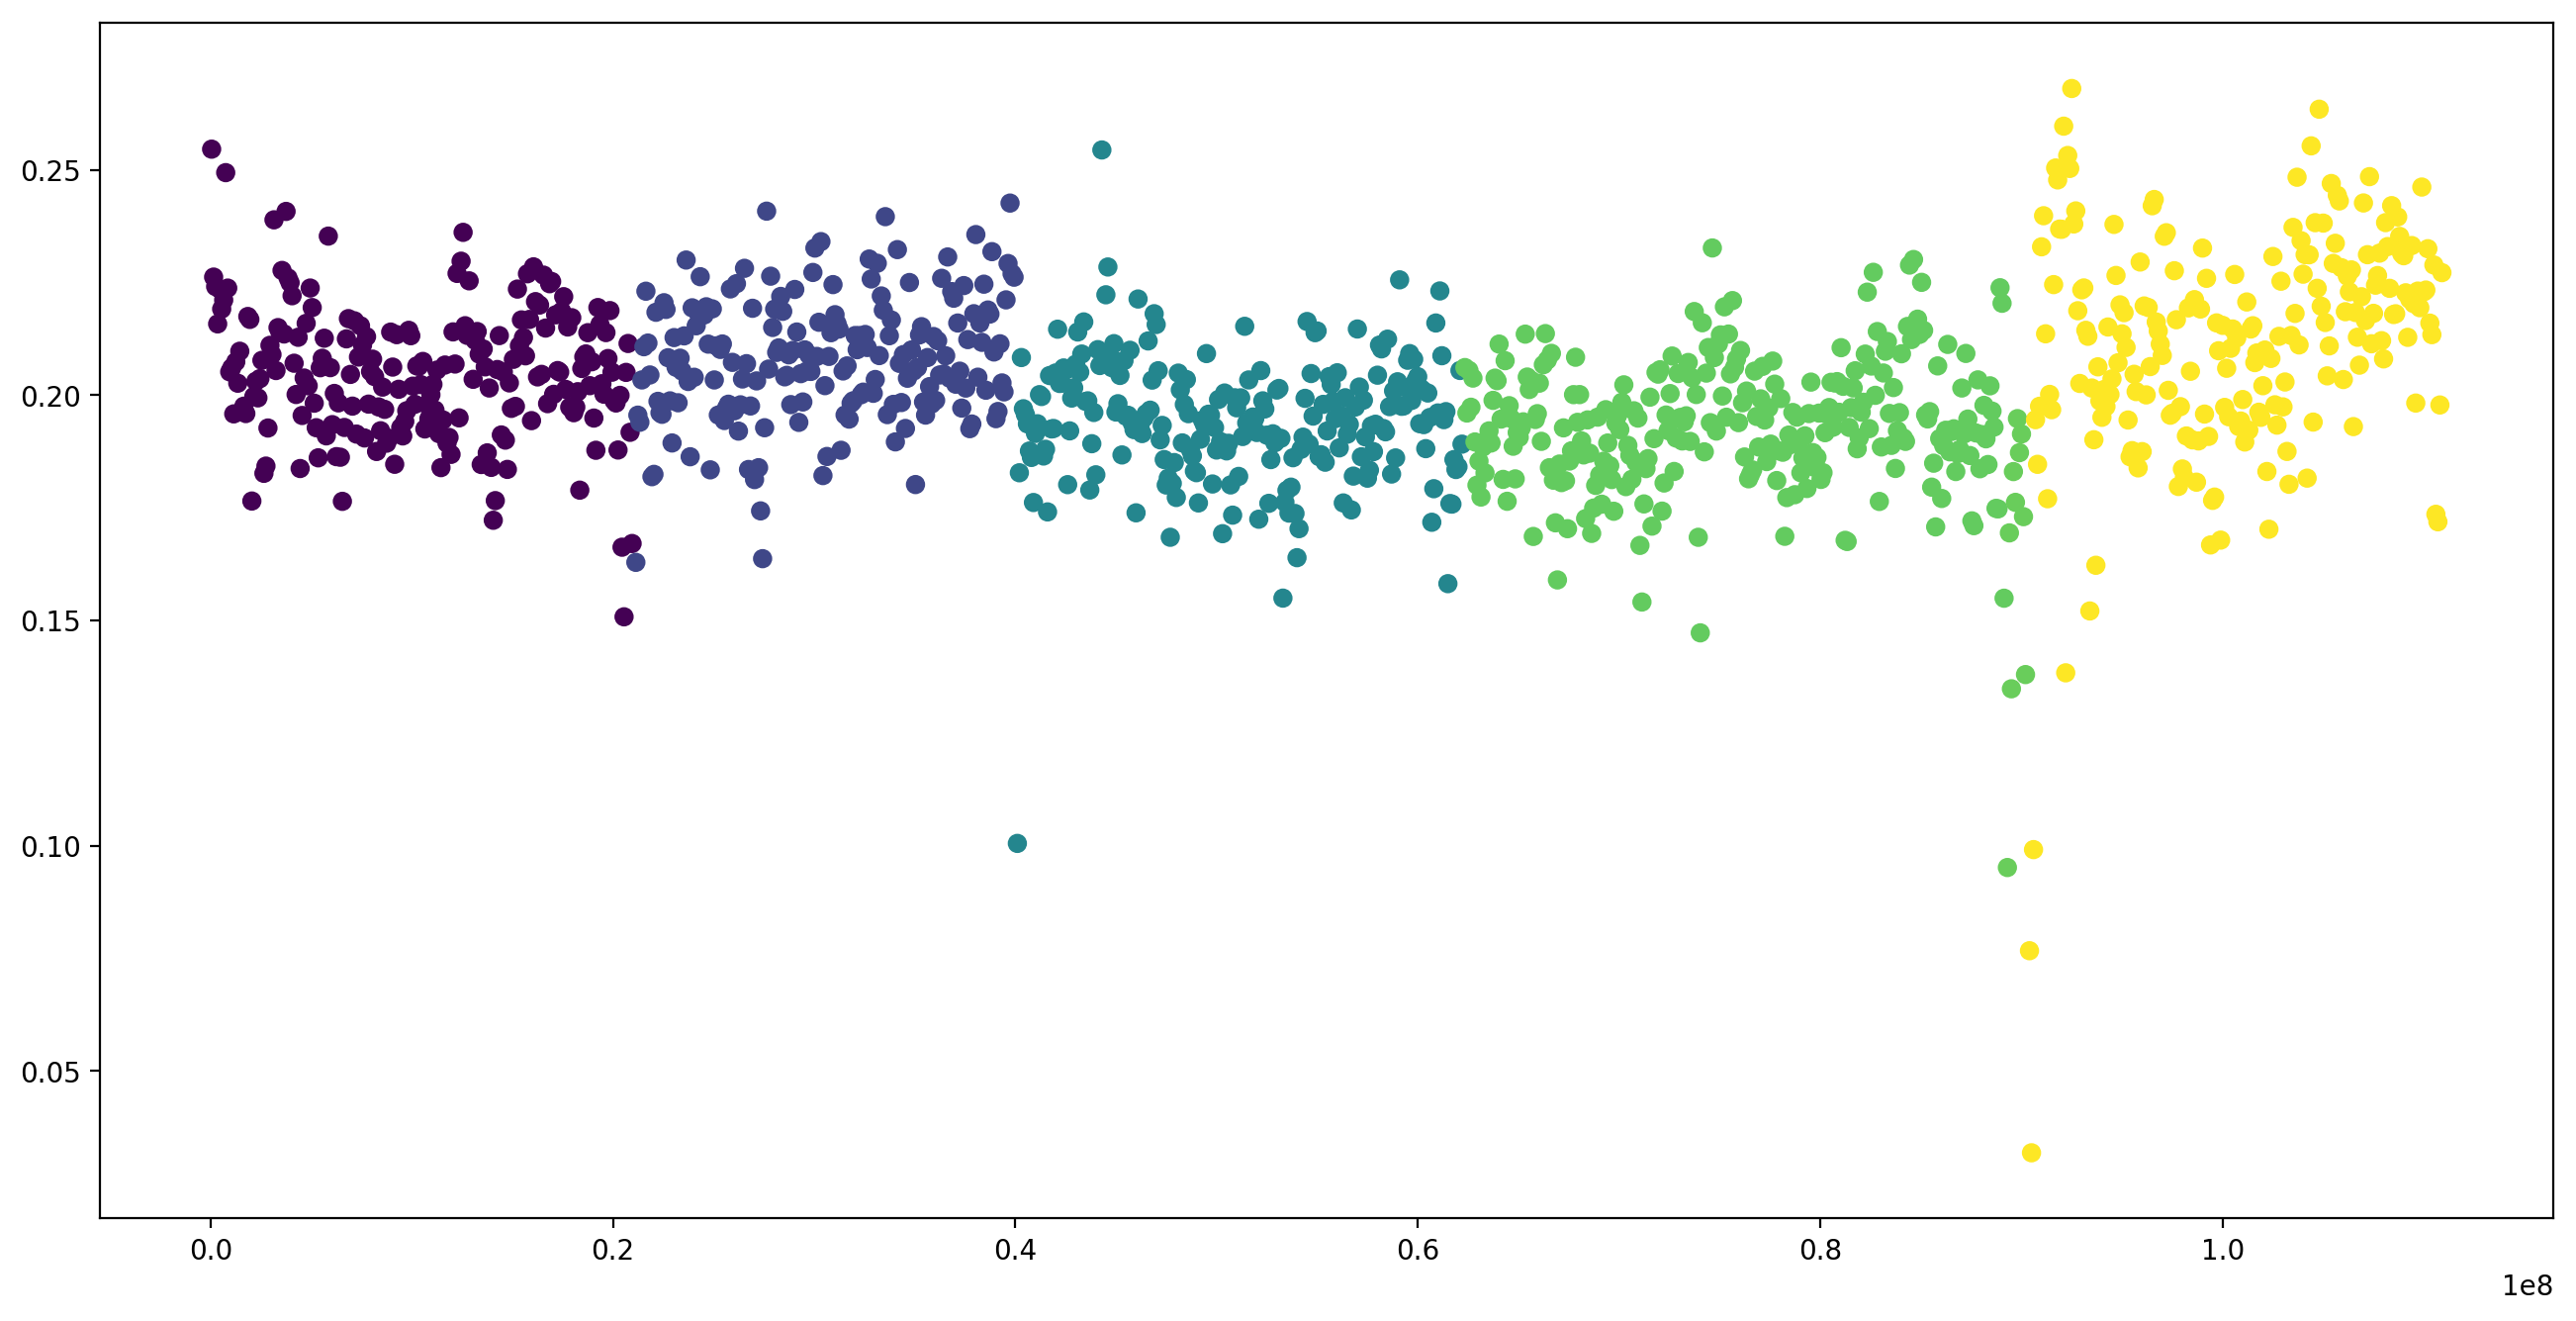

In [43]:
plt.scatter(d.tile_df['cummidpoint'], d.avehet_by_tile(), c=integerize(d.tile_df['seqid']))

In [104]:
depth_het_df = pd.DataFrame(dict(depth=d.depth_by_tile(), het=d.avehet_by_tile(), nloci=d.nloci_by_tile(), seqid=d.tile_df['seqid']))

Text(0, 0.5, 'het')

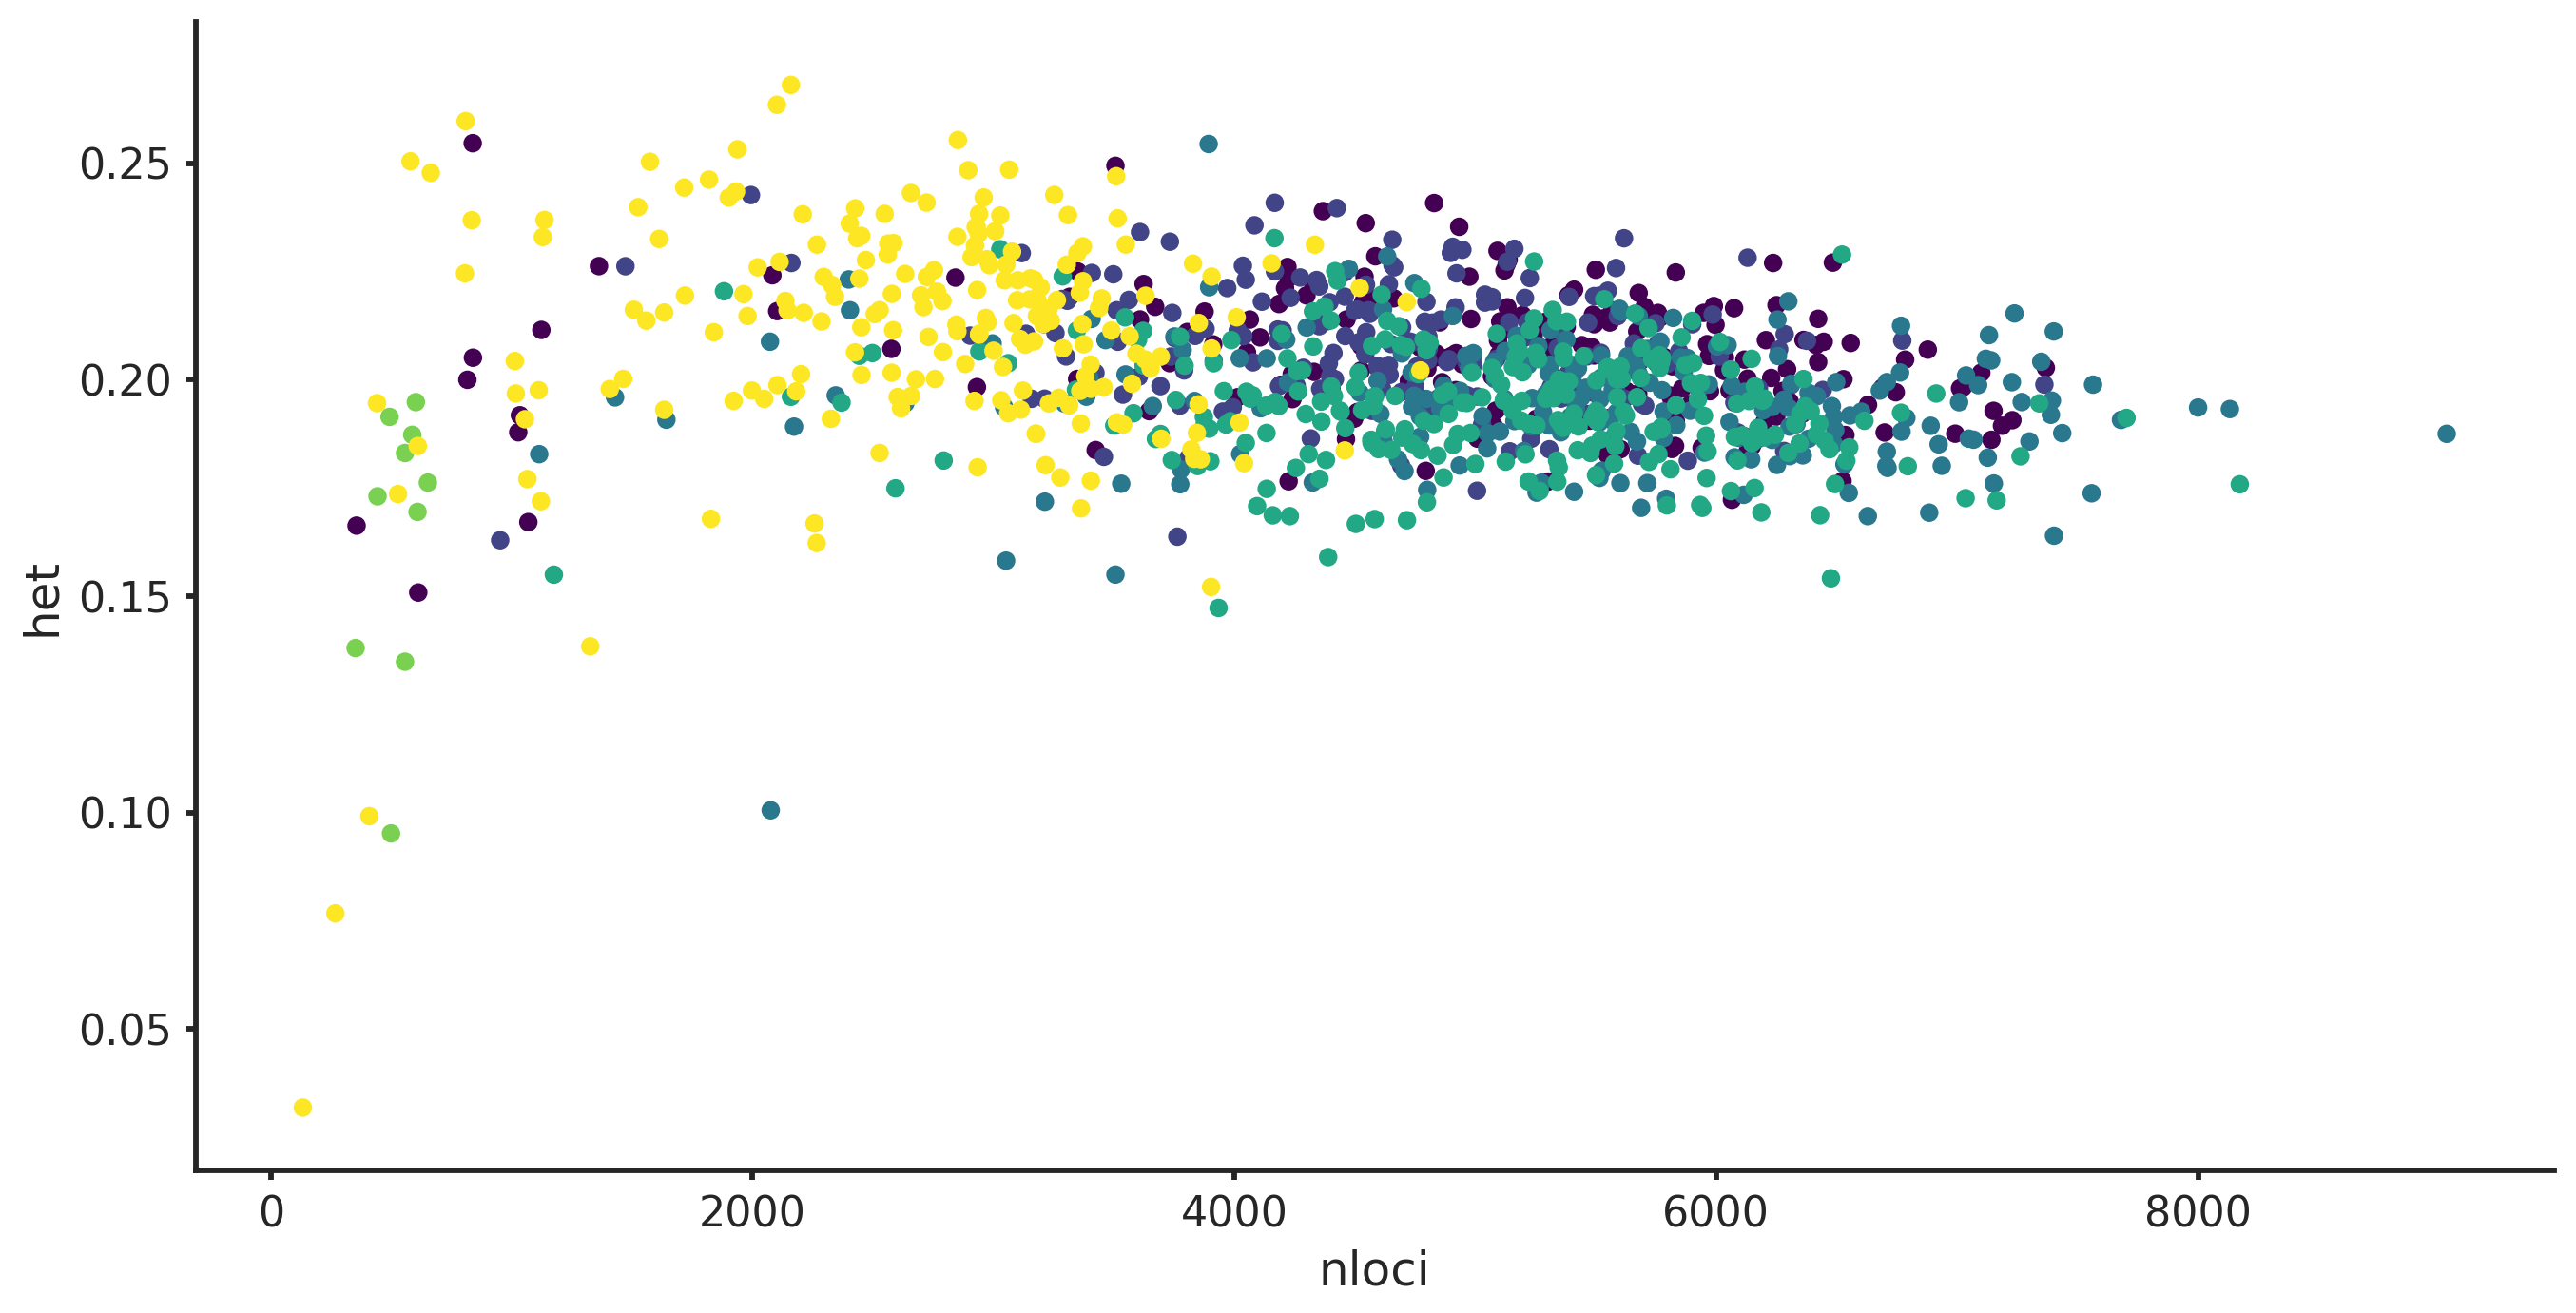

In [106]:
plt.scatter(depth_het_df['nloci'], depth_het_df['het'], c=integerize(depth_het_df['seqid']))
plt.xlabel('nloci')
plt.ylabel('het')

Text(0, 0.5, 'het')

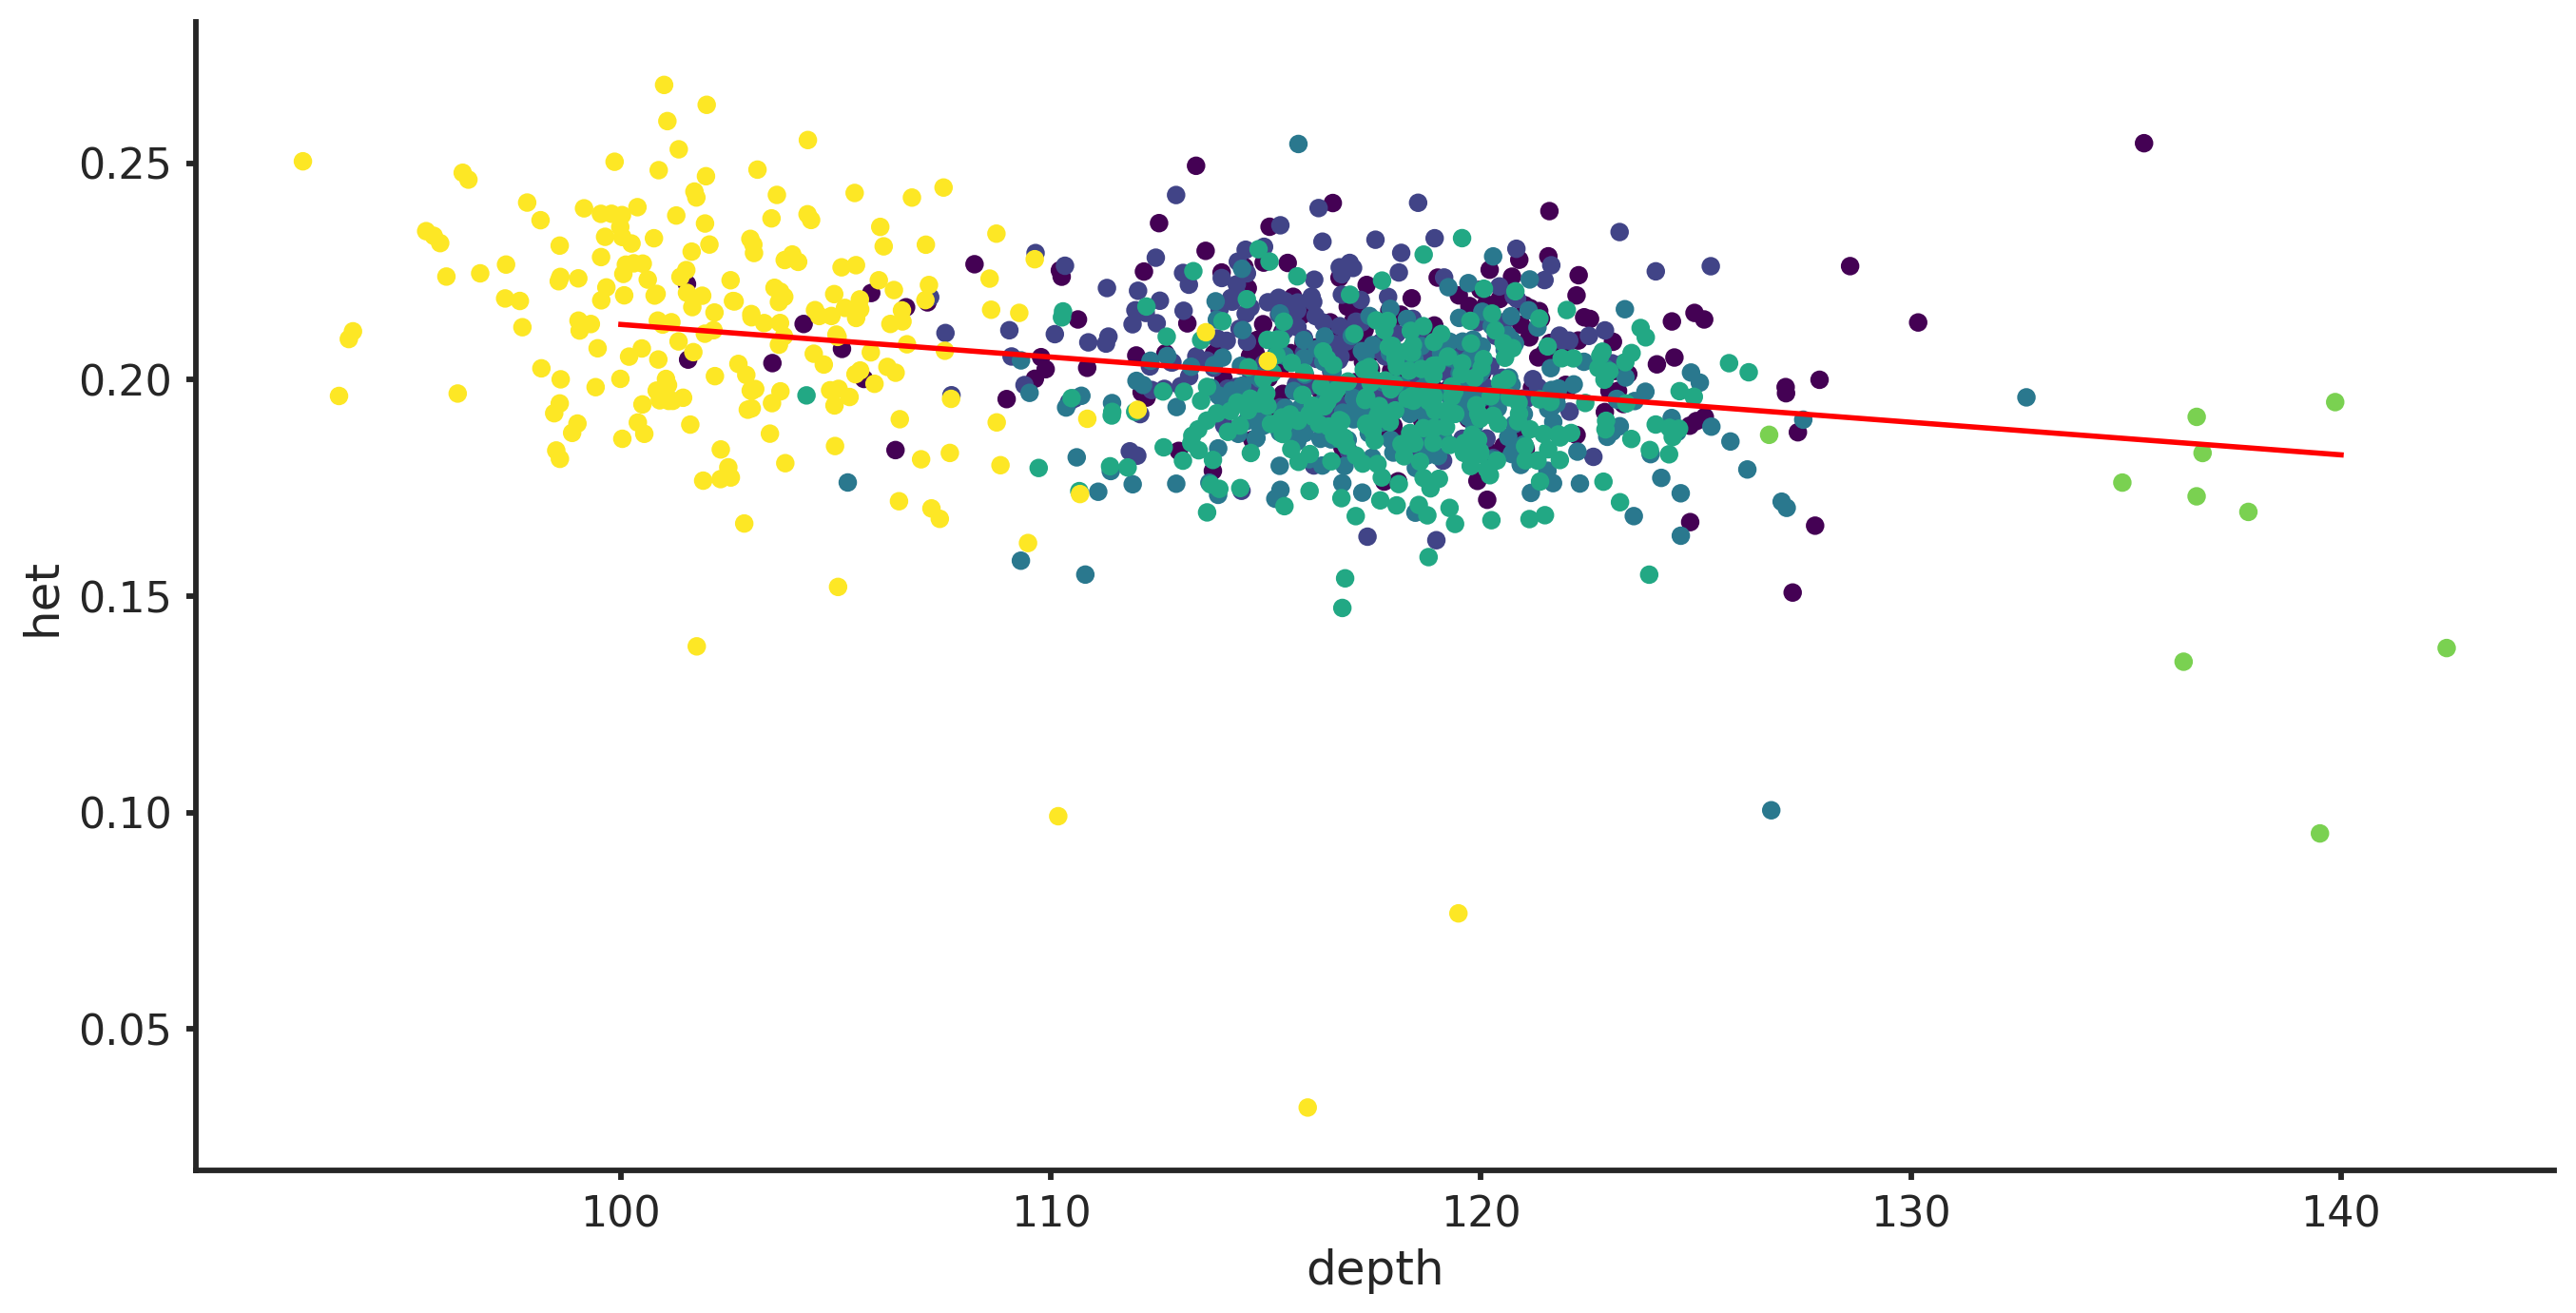

In [101]:
plt.scatter(depth_het_df['depth'], depth_het_df['het'], c=integerize(depth_het_df['seqid']))


fit = smf.ols('het ~ depth', depth_het_df[depth_het_df['seqid'] != 'X']).fit()
x = np.linspace(100, 140, 100)
plt.plot(x, fit.predict(dict(depth=x)), '-', c='r', linewidth=2)
plt.xlabel('depth')
plt.ylabel('het')

### Tiles with the Least Covariances

To estimate $N_e$, we look at tiles with the least covariance.



In [225]:
covs, covns = d.calc_covs_by_tile(keep_seqids=keep_autos, min_af=0.1)

removing 187441201 (53.0%) loci <= 0.1 or >= 0.9
removing 187441201 (53.0%) loci <= 0.1 or >= 0.9


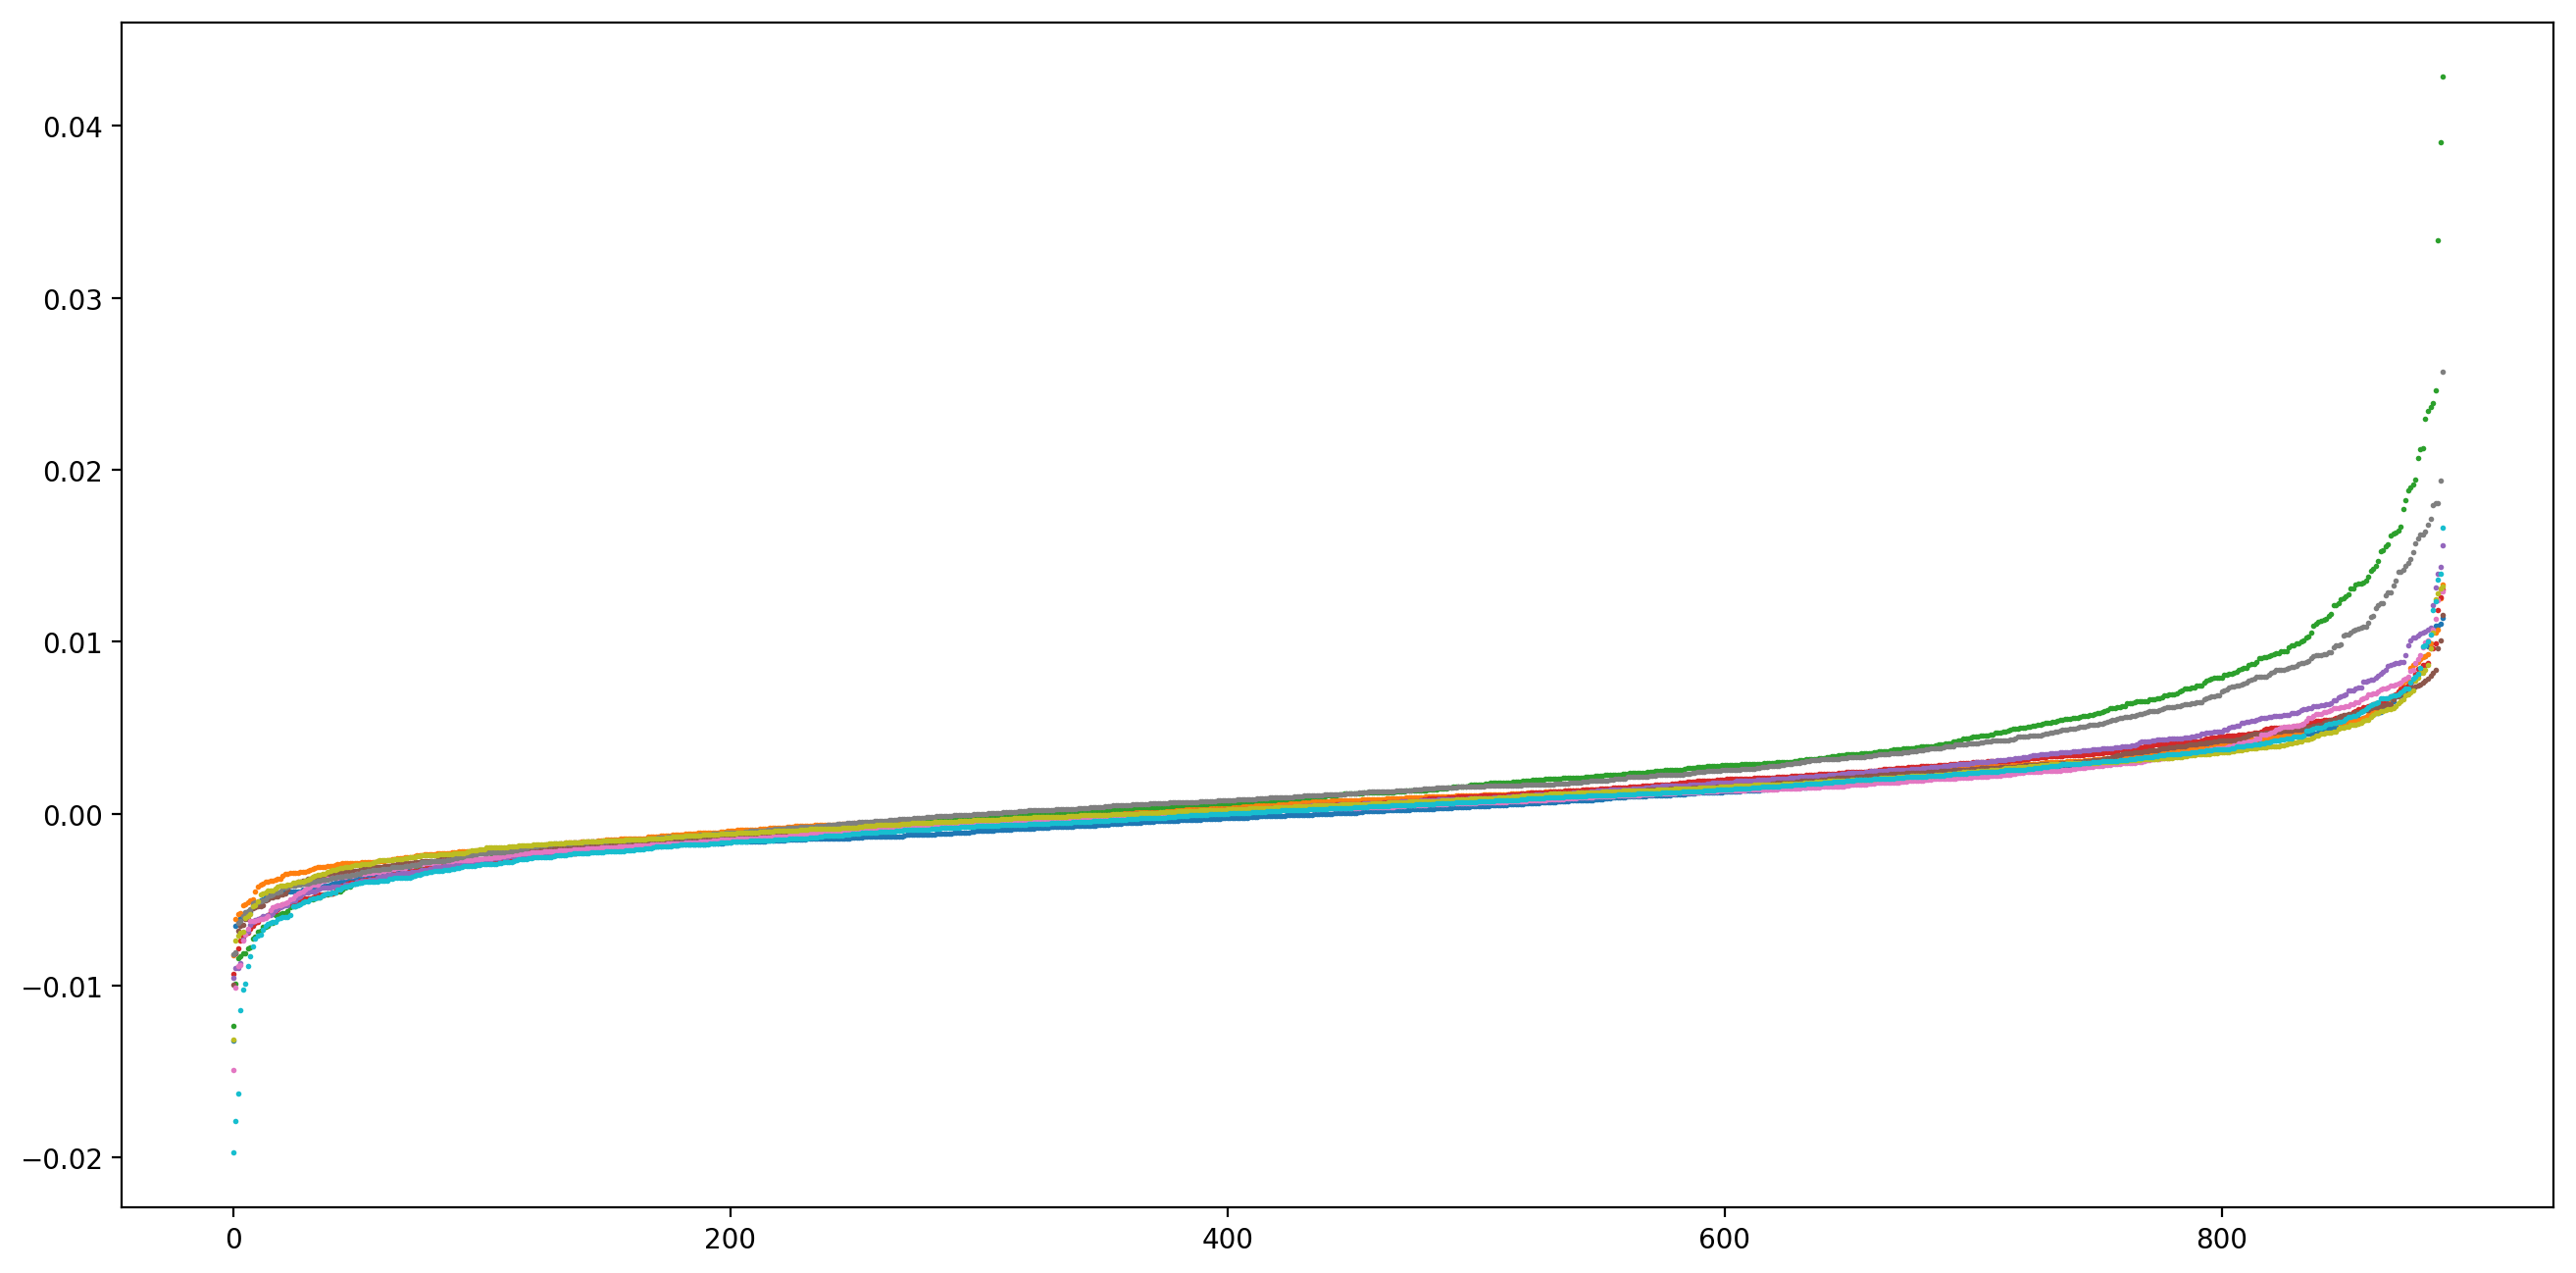

In [238]:
offdiag_means = np.stack([[np.diag(y, k=1) for y in stack_temporal_covariances(x, d.R, d.T, as_tensor=False)] for x in covs])
diag_means = np.stack([[np.diag(y, k=0) for y in stack_temporal_covariances(x, d.R, d.T, as_tensor=False)] for x in covs])
#np.argsort(offdiag_means)
xx = offdiag_means.mean(axis=(1,2))
rep_diag_means = dict()
for rep in np.arange(10):
    rep_diag_means[rep] = offdiag_means[:, rep, :]
    y = rep_diag_means[rep].mean(axis=1)
    plt.scatter(np.arange(rep_diag_means[rep].shape[0]), y[np.argsort(y)], s=1)

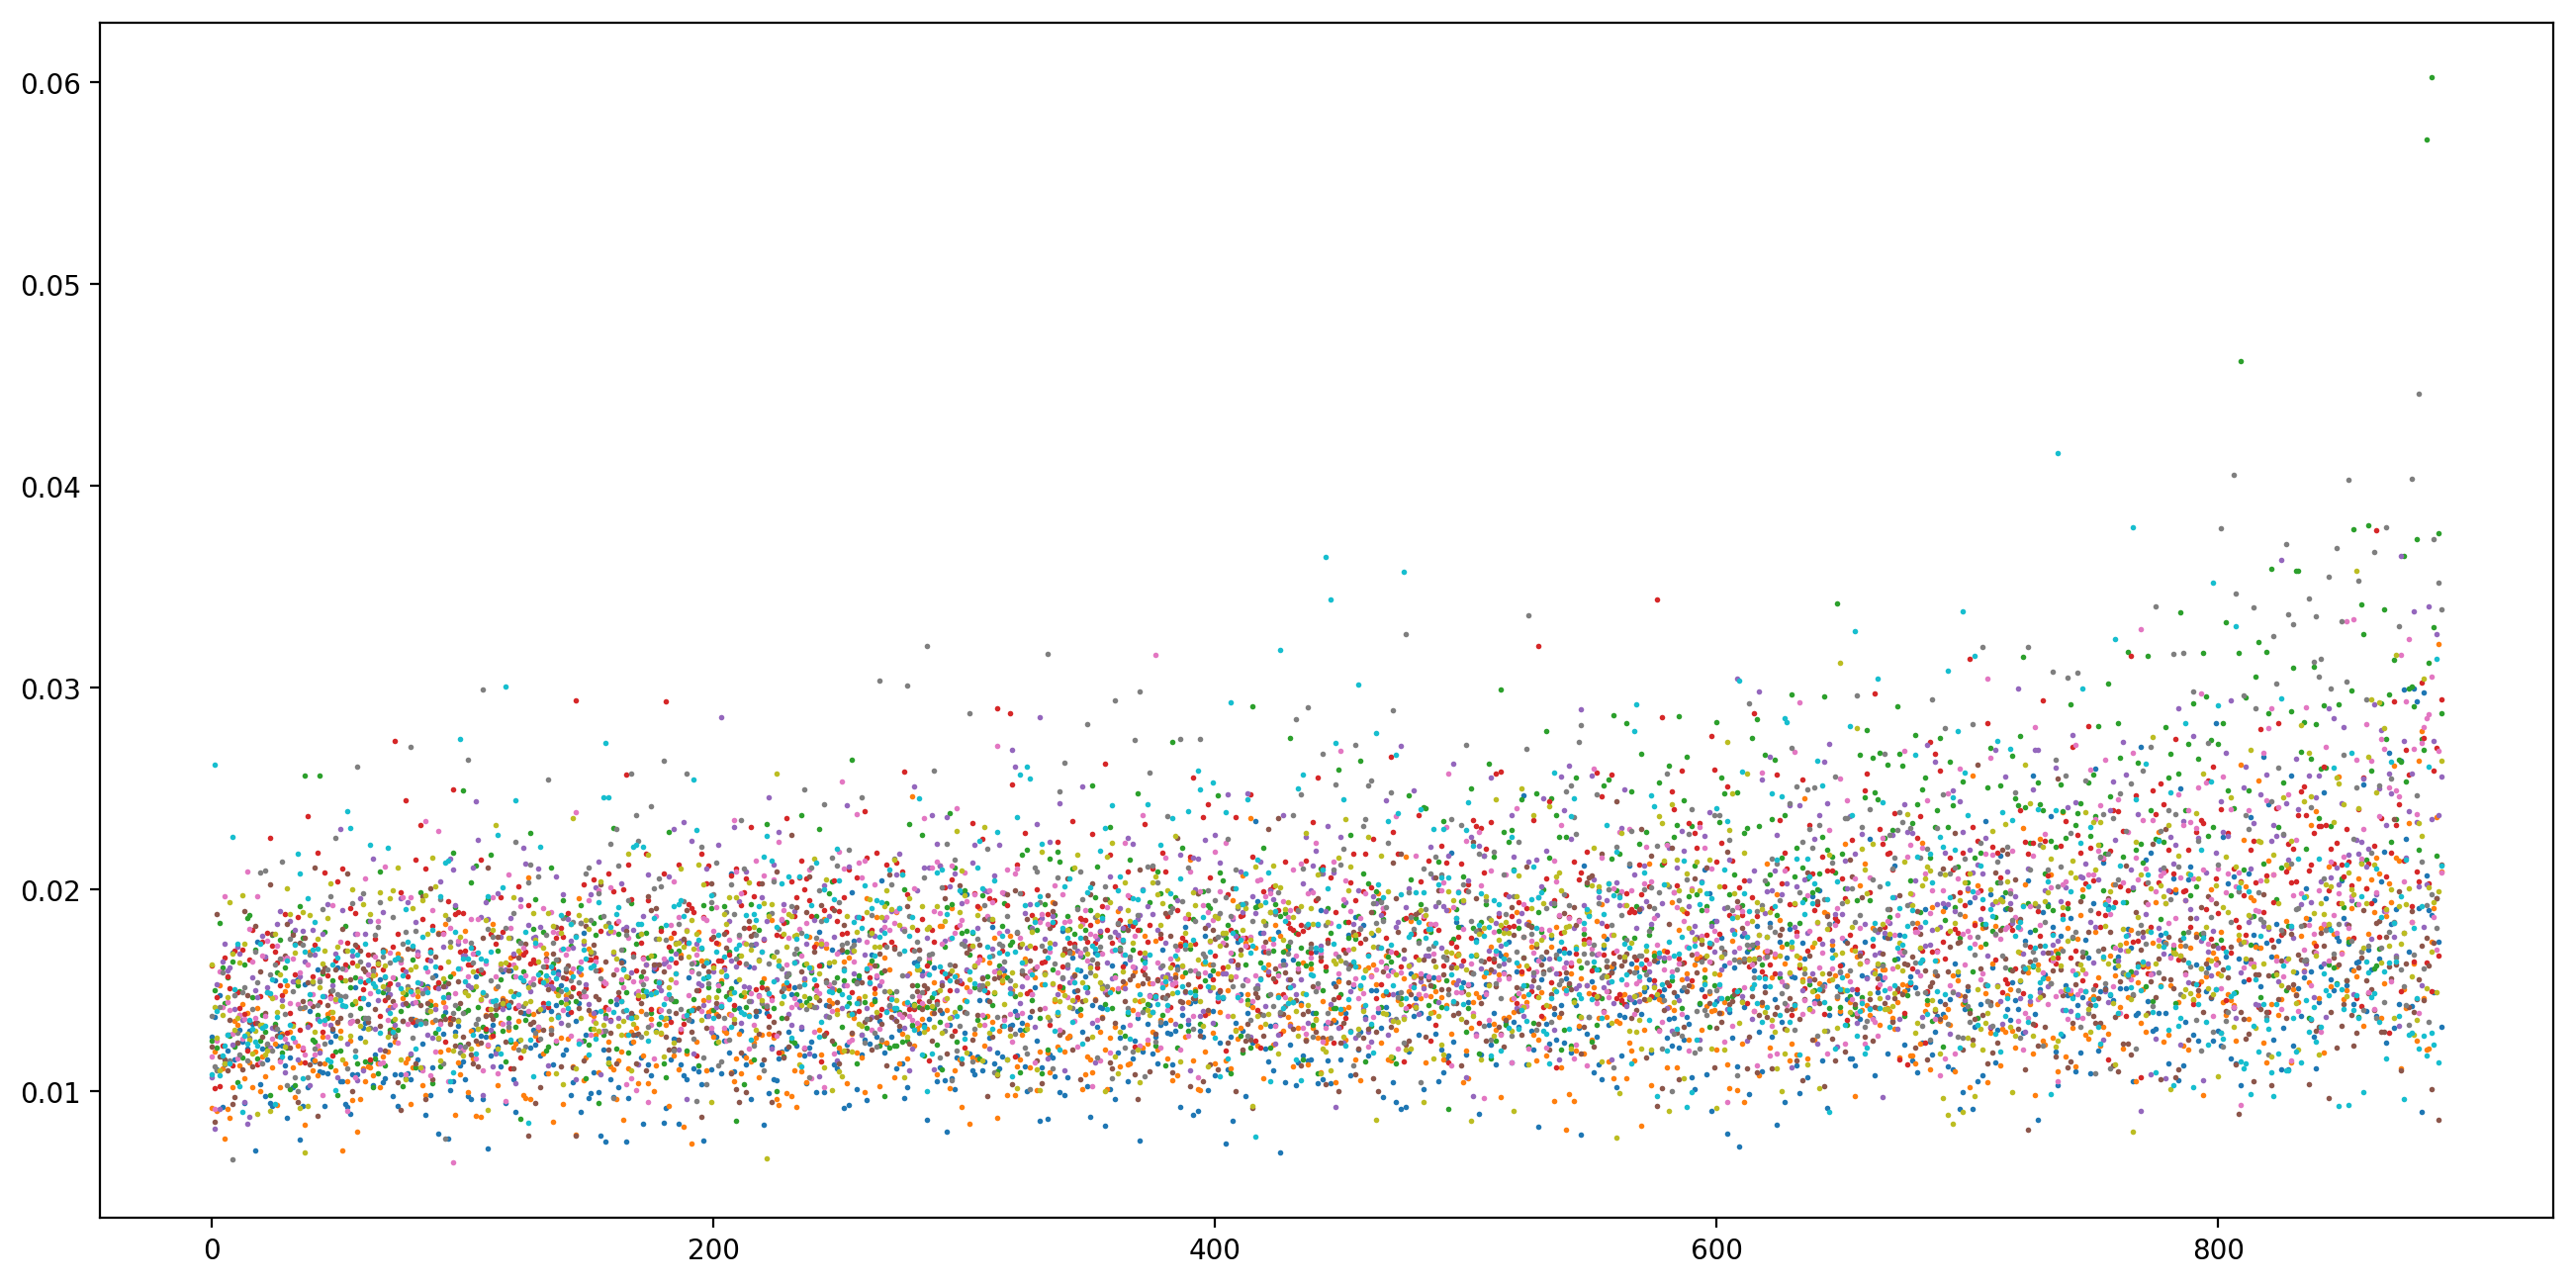

In [231]:
xx = diag_means.mean(axis=(1,2))
rep_diag_means = dict()
for rep in np.arange(10):
    rep_diag_means[rep] = diag_means[:, rep, :]
    y = rep_diag_means[rep].mean(axis=1)
    plt.scatter(np.arange(rep_diag_means[rep].shape[0]), y[np.argsort(xx)], s=1)

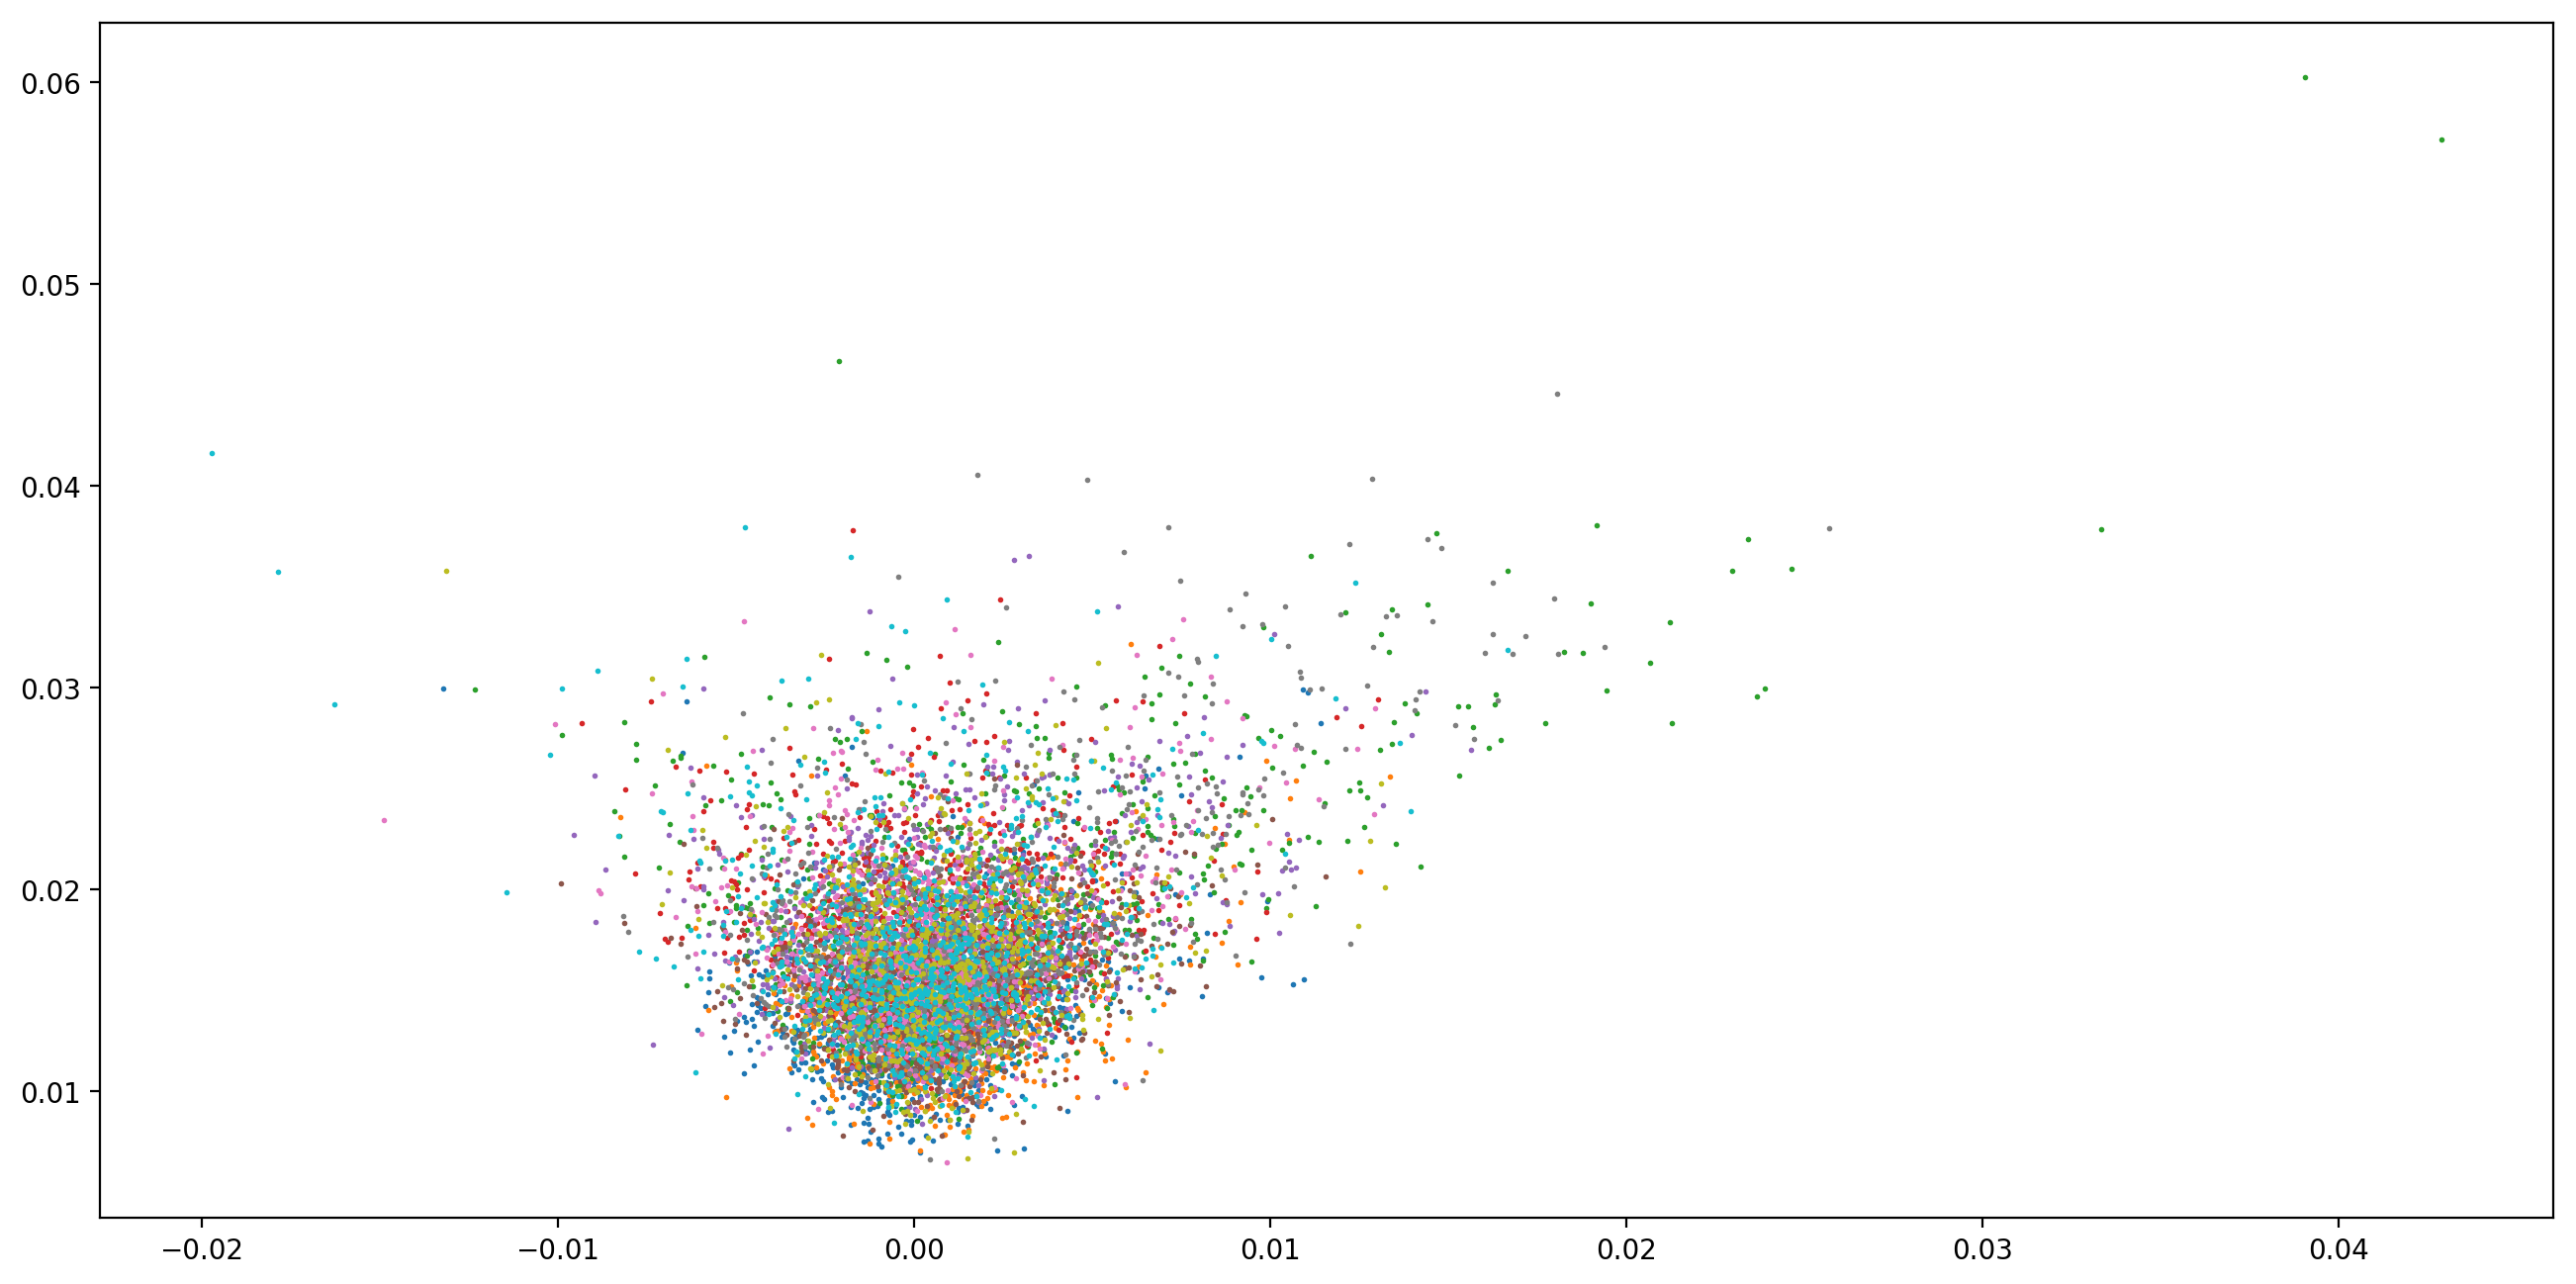

In [230]:
rep_diag_means = dict()
rep_offdiag_means = dict()
Ne_fits = dict()
for rep in np.arange(10):
    rep_offdiag_means[rep] = offdiag_means[:, rep, :].mean(axis=1)
    rep_diag_means[rep] = diag_means[:, rep, :].mean(axis=1)
    plt.scatter(rep_offdiag_means[rep], rep_diag_means[rep], s=1)
    
    diagdf = pd.DataFrame(dict(offdiag_means=rep_offdiag_means[rep], diag_means=rep_diag_means[rep]))
    fit = smf.ols('diag_means ~ offdiag_means', diagdf).fit()
    Ne_fits[rep] = fit
# Ne = 10/(2*fit.predict(dict(offdiag_means = 0)))
# Ne

## PyStan Stuff


In [305]:
import pystan as ps

code = """
data {
  int<lower=1> K;   // number of tiles
  int<lower=0> T;   // number of timepoints
  int<lower=T+1> L[K]; // number of loci
  cov_matrix[T] covs[K];
}

transformed data {
  cov_matrix[T] obs_covs[K]; // nloci multiplied by the sample covariance
  for (k in 1:K) {
    obs_covs[k] = L[K] * covs[k];
  }
}

parameters {
  vector[T] gw_alpha;
  vector[T] alpha[K];
  real<lower=0> logN;
  corr_matrix[T] Omega;    // correlation between alphas
  vector<lower=0>[T] tau;  // prior scale
}

transformed parameters {
  cov_matrix[T] Sigma[K];
  real<lower=0> N;
  N = 10^logN;
  for (k in 1:K) {
    Sigma[k] = (alpha[k] * alpha[k]') + diag_matrix(rep_vector(1, T)) / (2 * N);
  }
}

model {
  tau ~ cauchy(0, 2.5);
  Omega ~ lkj_corr(2);
  logN ~ lognormal(0, 1);
  gw_alpha ~ multi_normal(rep_vector(0, T), quad_form_diag(Omega, tau));
  for (k in 1:K) {
    alpha[k] ~ multi_normal(gw_alpha, quad_form_diag(Omega, tau));
    obs_covs[k] ~ wishart(L[k], Sigma[k]);
  }
}
"""
#sm = ps.StanModel(model_code=code)
chr3R = [i for i, seqid in enumerate(d.tile_df['seqid'].values) if seqid == '3R']
rep = 2

L, covs = zip(*[(int(covns[i].mean()), tile_tempcovs[i, :, :, rep]) for i in chr3R if np.all(np.linalg.eigvals(tile_tempcovs[i, :, :, rep]) > 0)])
covs = np.stack(covs)
K = len(L)
fit = sm.sampling(data=dict(T=6, K=K, L=L, covs=covs), iter=1000, chains=4, n_jobs=4)


/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [244]:
import pystan as ps

code = """
data {
  int<lower=0> T;
  int<lower=0> ntiles;
  int<lower=1> covs[ntiles, T, T];
  int<lower=1> nloci[ntiles];
}

parameters {
  vector[ntiles] alpha_t[T];
  row_vector[ntiles] alpha_s[T];
  real N;
}

transformed parameters {
  vector[ntiles] cov_matrix[T] Sigma;
  for (tile in 1:ntiles) {
    Sigma[tile] = alpha_t operator* alpha_s + diag_matrix(rep_vector(1/(2 * 10^N), T));
  }
}

model {
  alpha_t ~ product_normal(2, 0, 1);
  alpha_s ~ product_normal(2, 0, 1);
  N ~ exponential(0.5);
  for (tile in 1:ntiles) {
    alpha_t[tile, ] 
    covs[tile, 1:T, 1:T] ~ wishart(ntiles[tile], Sigma)
  }

}

"""

sm = ps.StanModel(model_code=code)
#fit = sm.sampling(data=tile_tempcovs, iter=1000, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_12e27f2a9c6b1810bc2a47ed8ab8805f NOW.
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpr9vtdrgf/stanfit4anon_model_12e27f2a9c6b1810bc2a47ed8ab8805f_1980184586641156803.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [37]:
d.tile_df['ld'] = np.stack([ldsmoothers[s](m) for s, m in zip(d.tile_df['seqid'], d.tile_df['cummidpoint'])])

KeyError: '4'

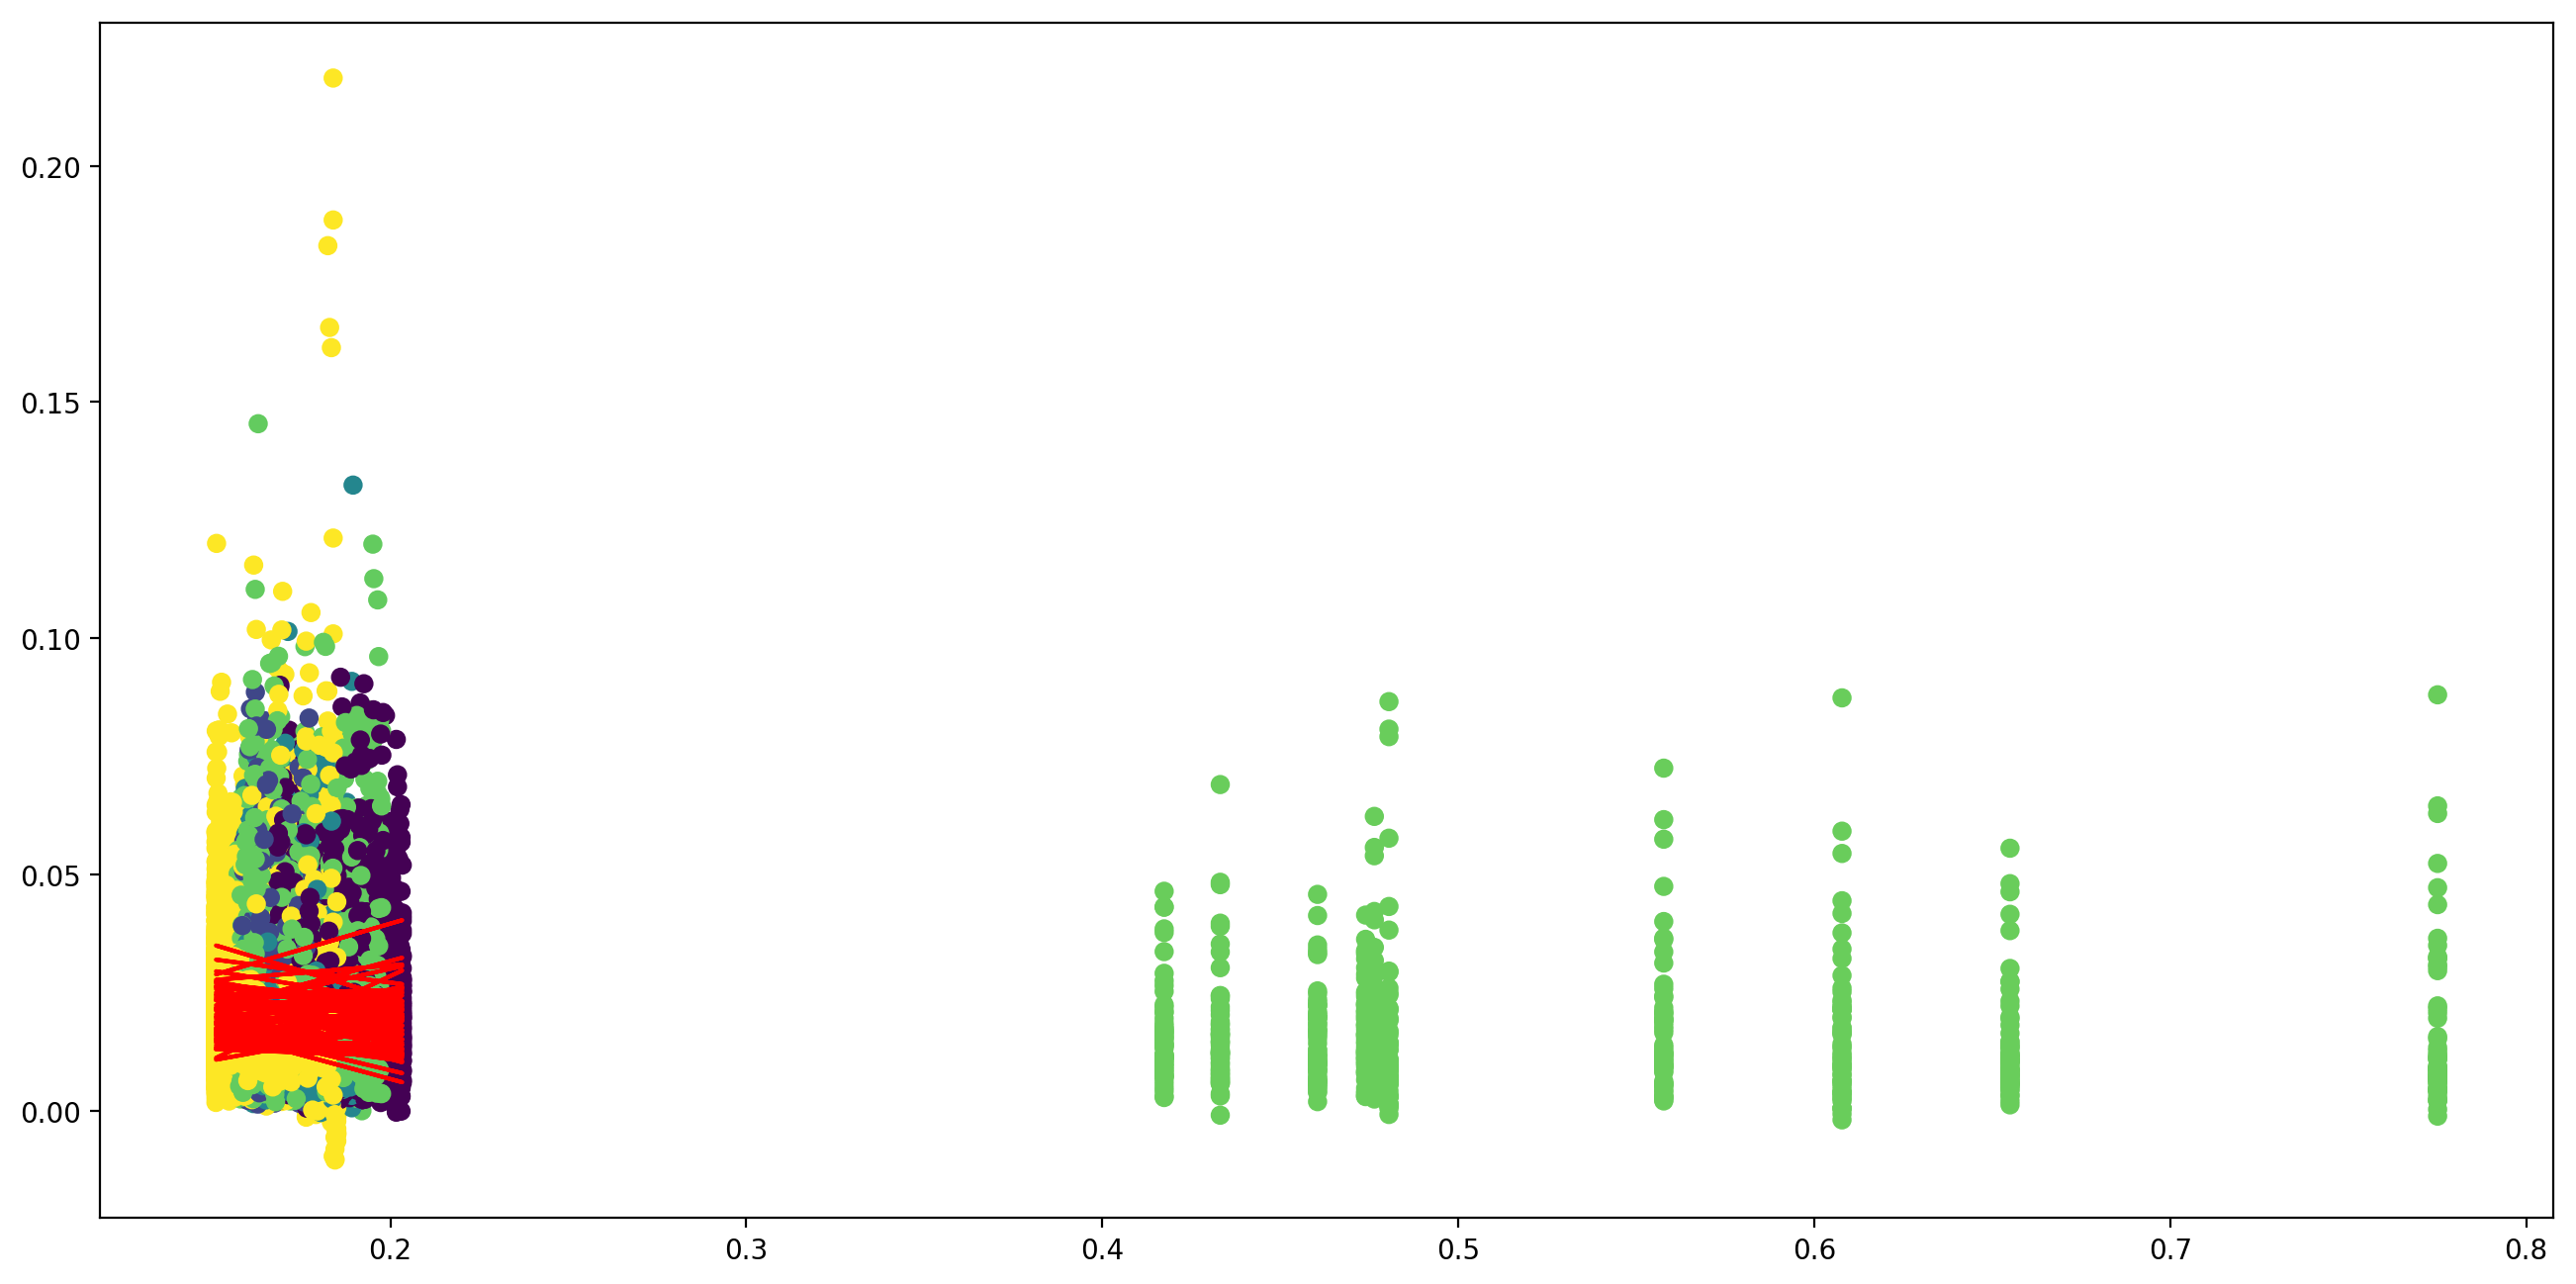

In [105]:

x = d.tile_df['ld'].values
y = tile_tempcovs


res = dict()

for time in np.arange(d.T):
    for rep in np.arange(d.R):
        #yy = np.mean(y[:, time, time, :], axis=1)
        yy = (y[:, time, time, rep])
        keep = np.logical_and(np.logical_and(np.isfinite(x), np.isfinite(yy)), x < 0.4)

        #plt.scatter(x, yy, c=integerize(d.tile_df['nloci'].values))
        plt.scatter(x, yy, c=integerize(d.tile_df['seqid'].values))
        #X = sm.add_constant(x[keep])
        #X = x[keep]
        xd = pd.DataFrame(dict(cov=yy[keep], r2mean=x[keep], exonic_bp=d.tile_df['r2mean'].values[keep]))
        #fit = smf.ols('cov ~ r2mean + exonic_bp', xd).fit()
        #ypred = fit.predict(dict(r2mean=xd['r2mean'], exonic_bp=np.repeat(xd['exonic_bp'].mean(), xd.shape[0])))
        fit = smf.ols('cov ~ r2mean + exonic_bp', xd, weights=d.tile_df['nloci'].values[keep]).fit()
        fit2 = smf.wls('cov ~ r2mean', xd, weights=d.tile_df['nloci'].values[keep]).fit()
        ypred = fit2.predict(dict(r2mean=xd['r2mean']))
        plt.plot(xd['r2mean'], ypred, '-', c='red')
        # fit = smf.OLS(yy[keep], X).fit()
        # ypred = fit.predict(X)
        # plt.plot(X[:, 1], ypred, '-', c='red')
        fit.summary()
        res[(time, rep)] = (fit.pvalues[1], fit.params[0], fit.params[1], fit)
             


NameError: name 'i' is not defined

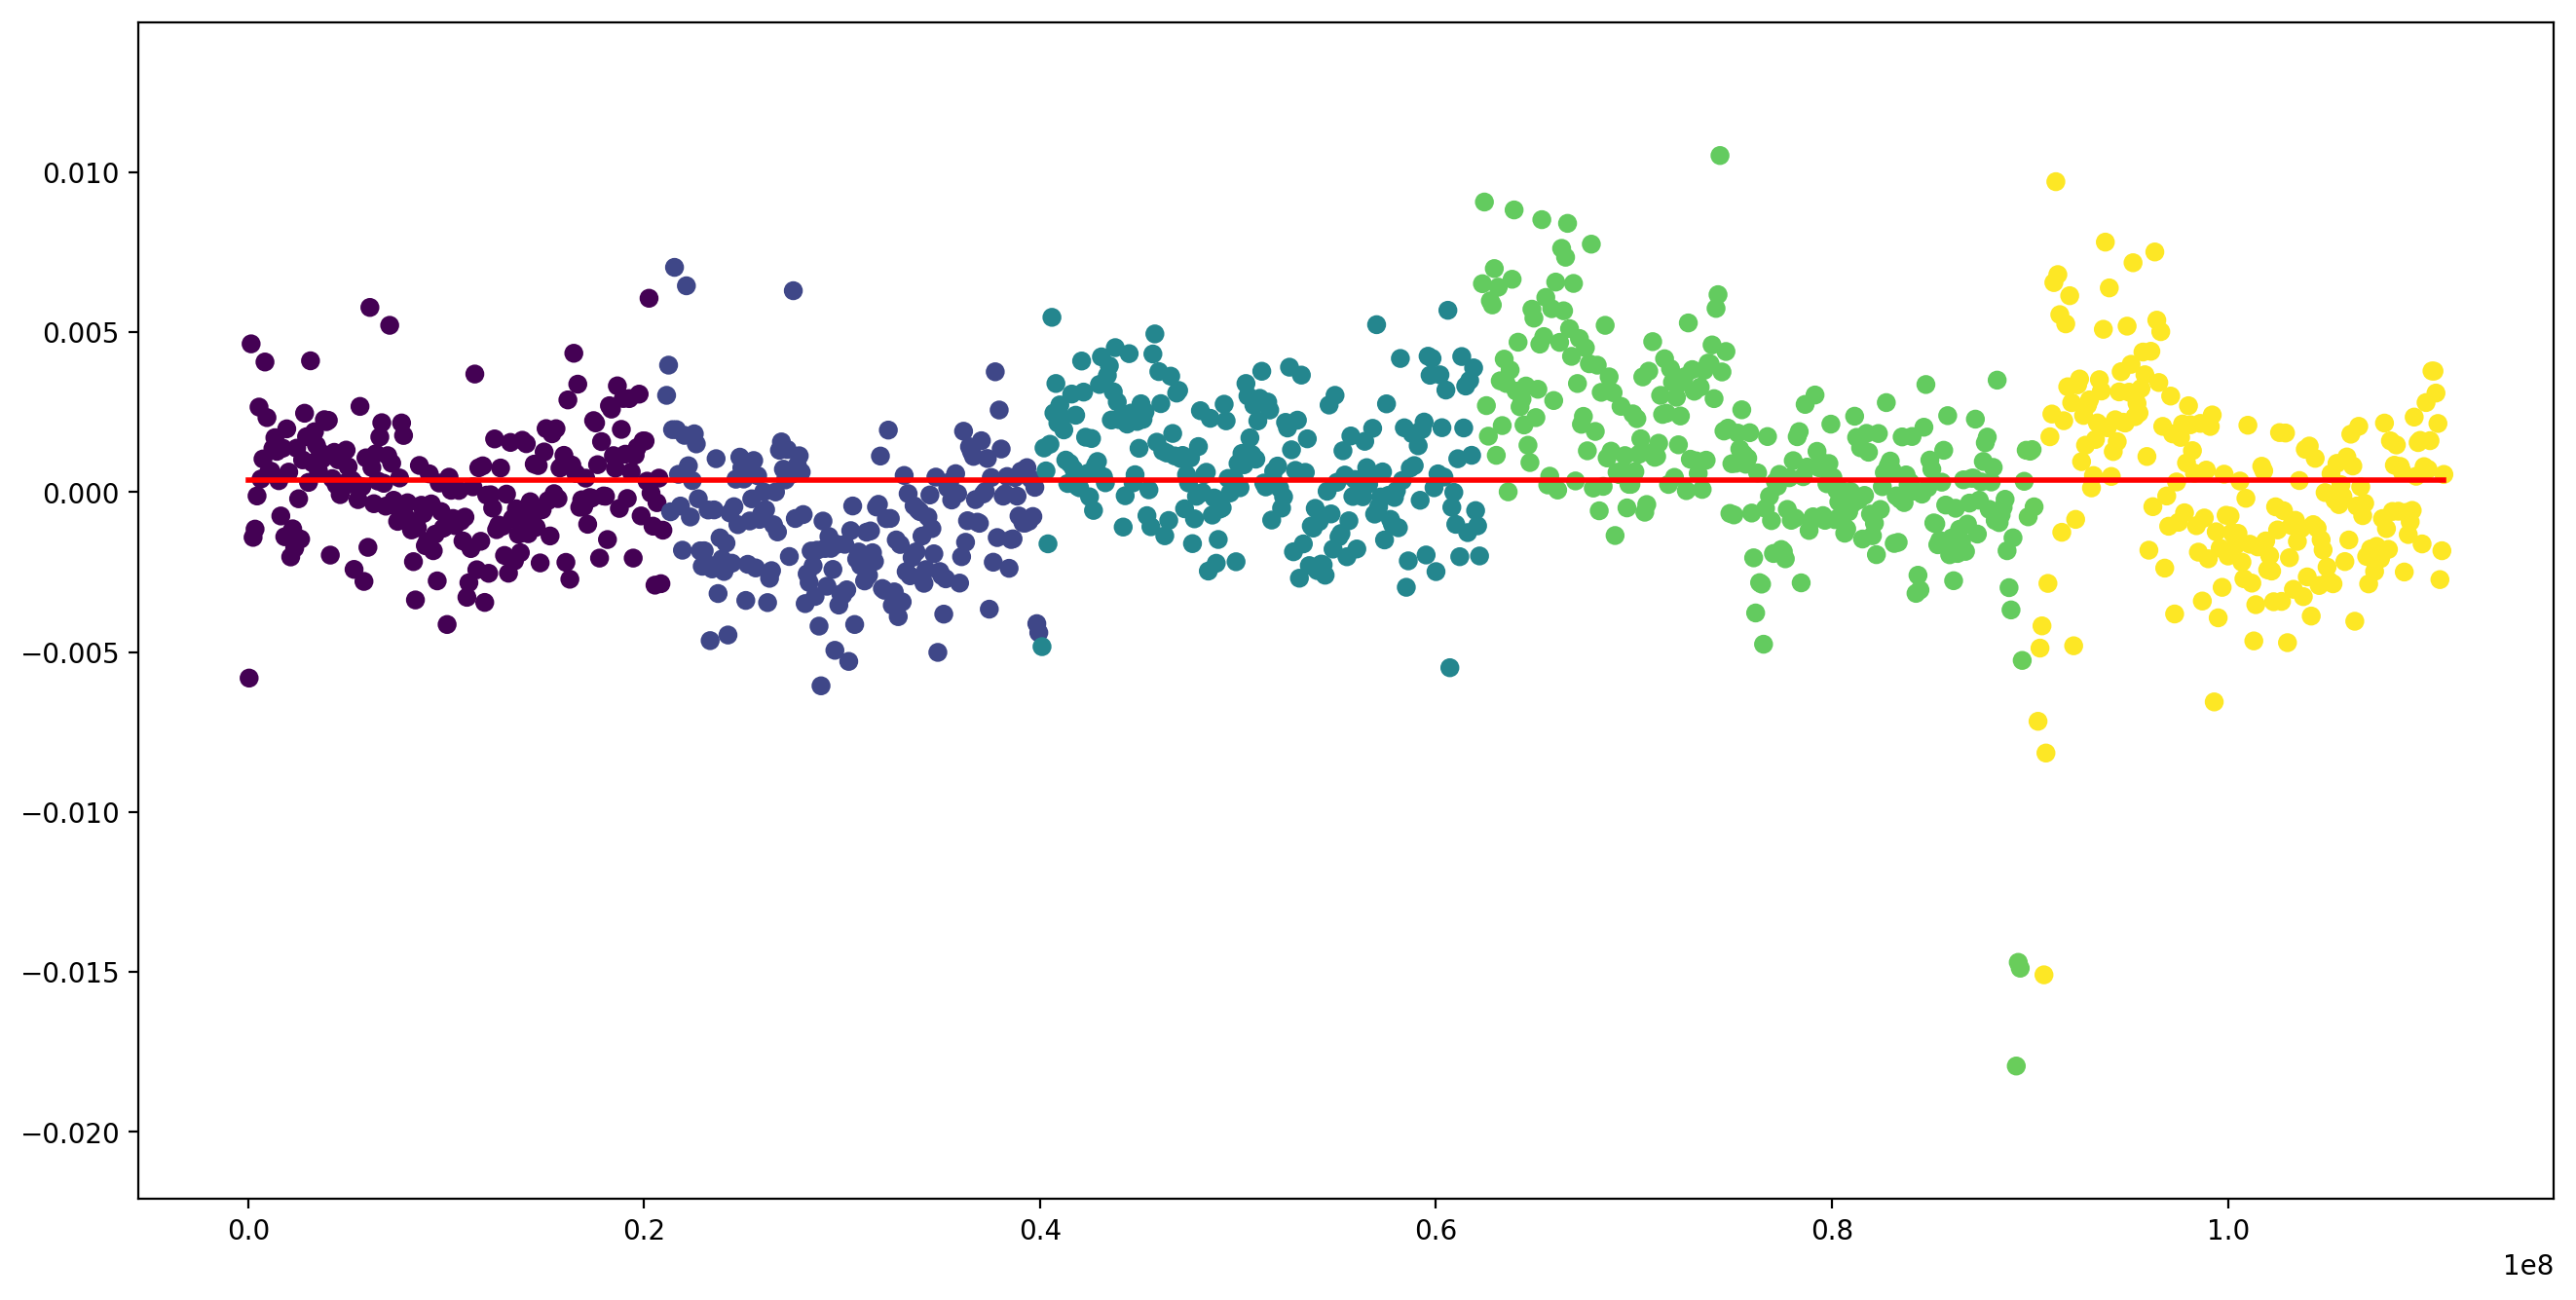

In [135]:
# ld tiles were 1e3, cov tiles 1e6
from matplotlib.animation import FuncAnimation

x = d.tile_df.cummidpoint.values
y = tile_tempcovs

refgen = 0


fig, ax = plt.subplots()

points = ax.scatter(x, np.nanmean(y[:, refgen, refgen+1, :], axis=1), c=integerize(d.tile_df['seqid']), zorder=2)
#line = ax.axhline(np.nanmean(y[:, refgen, refgen+1, :]), c='r', zorder=3, alpha=0.1)
lx = np.array([0, x.max()])
line, = ax.plot(lx, np.repeat(np.nanmean(y[:, refgen, refgen+1, :]), 2), 'r-', linewidth=2)
text = ax.text(9.5e7, 0.012, f"cov(Δp_{refgen}, Δp_{refgen+i})", fontsize=15)
ax.axhline(y=0, c='k')

def update(i):
    points.set_offsets(np.column_stack([x, np.nanmean(y[:, refgen, refgen+i, :], axis=1)]))
    new_mean_cov = np.nanmean(y[:, refgen, refgen+i, :])
    line.set_ydata([new_mean_cov, new_mean_cov])
    #ax.set_ylabel(f"cov(Δp_{refgen}, Δp_{refgen+i})")
    text.set_text(f"cov(Δp_{refgen}, Δp_{refgen+i})")
    return line, points
                     
anim = FuncAnimation(fig, update, frames=np.arange(refgen+1, d.T), interval=700)
anim.save(f"covs-{refgen}.gif", dpi=150, writer='imagemagick')
plt.show()
#plt.scatter(x, np.nanmean(y[:, refgen, refgen+i, :], axis=1), c=integerize(d.tile_df['seqid']), zorder=2)


#plt.scatter(x, y[:, 1, 2, 7], s=2, alpha=0.3, zorder=2)
#plt.axhline(np.nanmean(y[:, 1, 2, 7]), c='r', zorder=3, alpha=0.6)
#plt.axhline(y=0, c='k', zorder=1)
#plt.ylim(-0.5, 0.5)
#plt.legend()

In [40]:
d.tile_df['ld'] = np.stack([ldsmoothers.get(s, lambda x: np.nan)(m) for s, m in zip(d.tile_df['seqid'], d.tile_df['cummidpoint'])])

/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


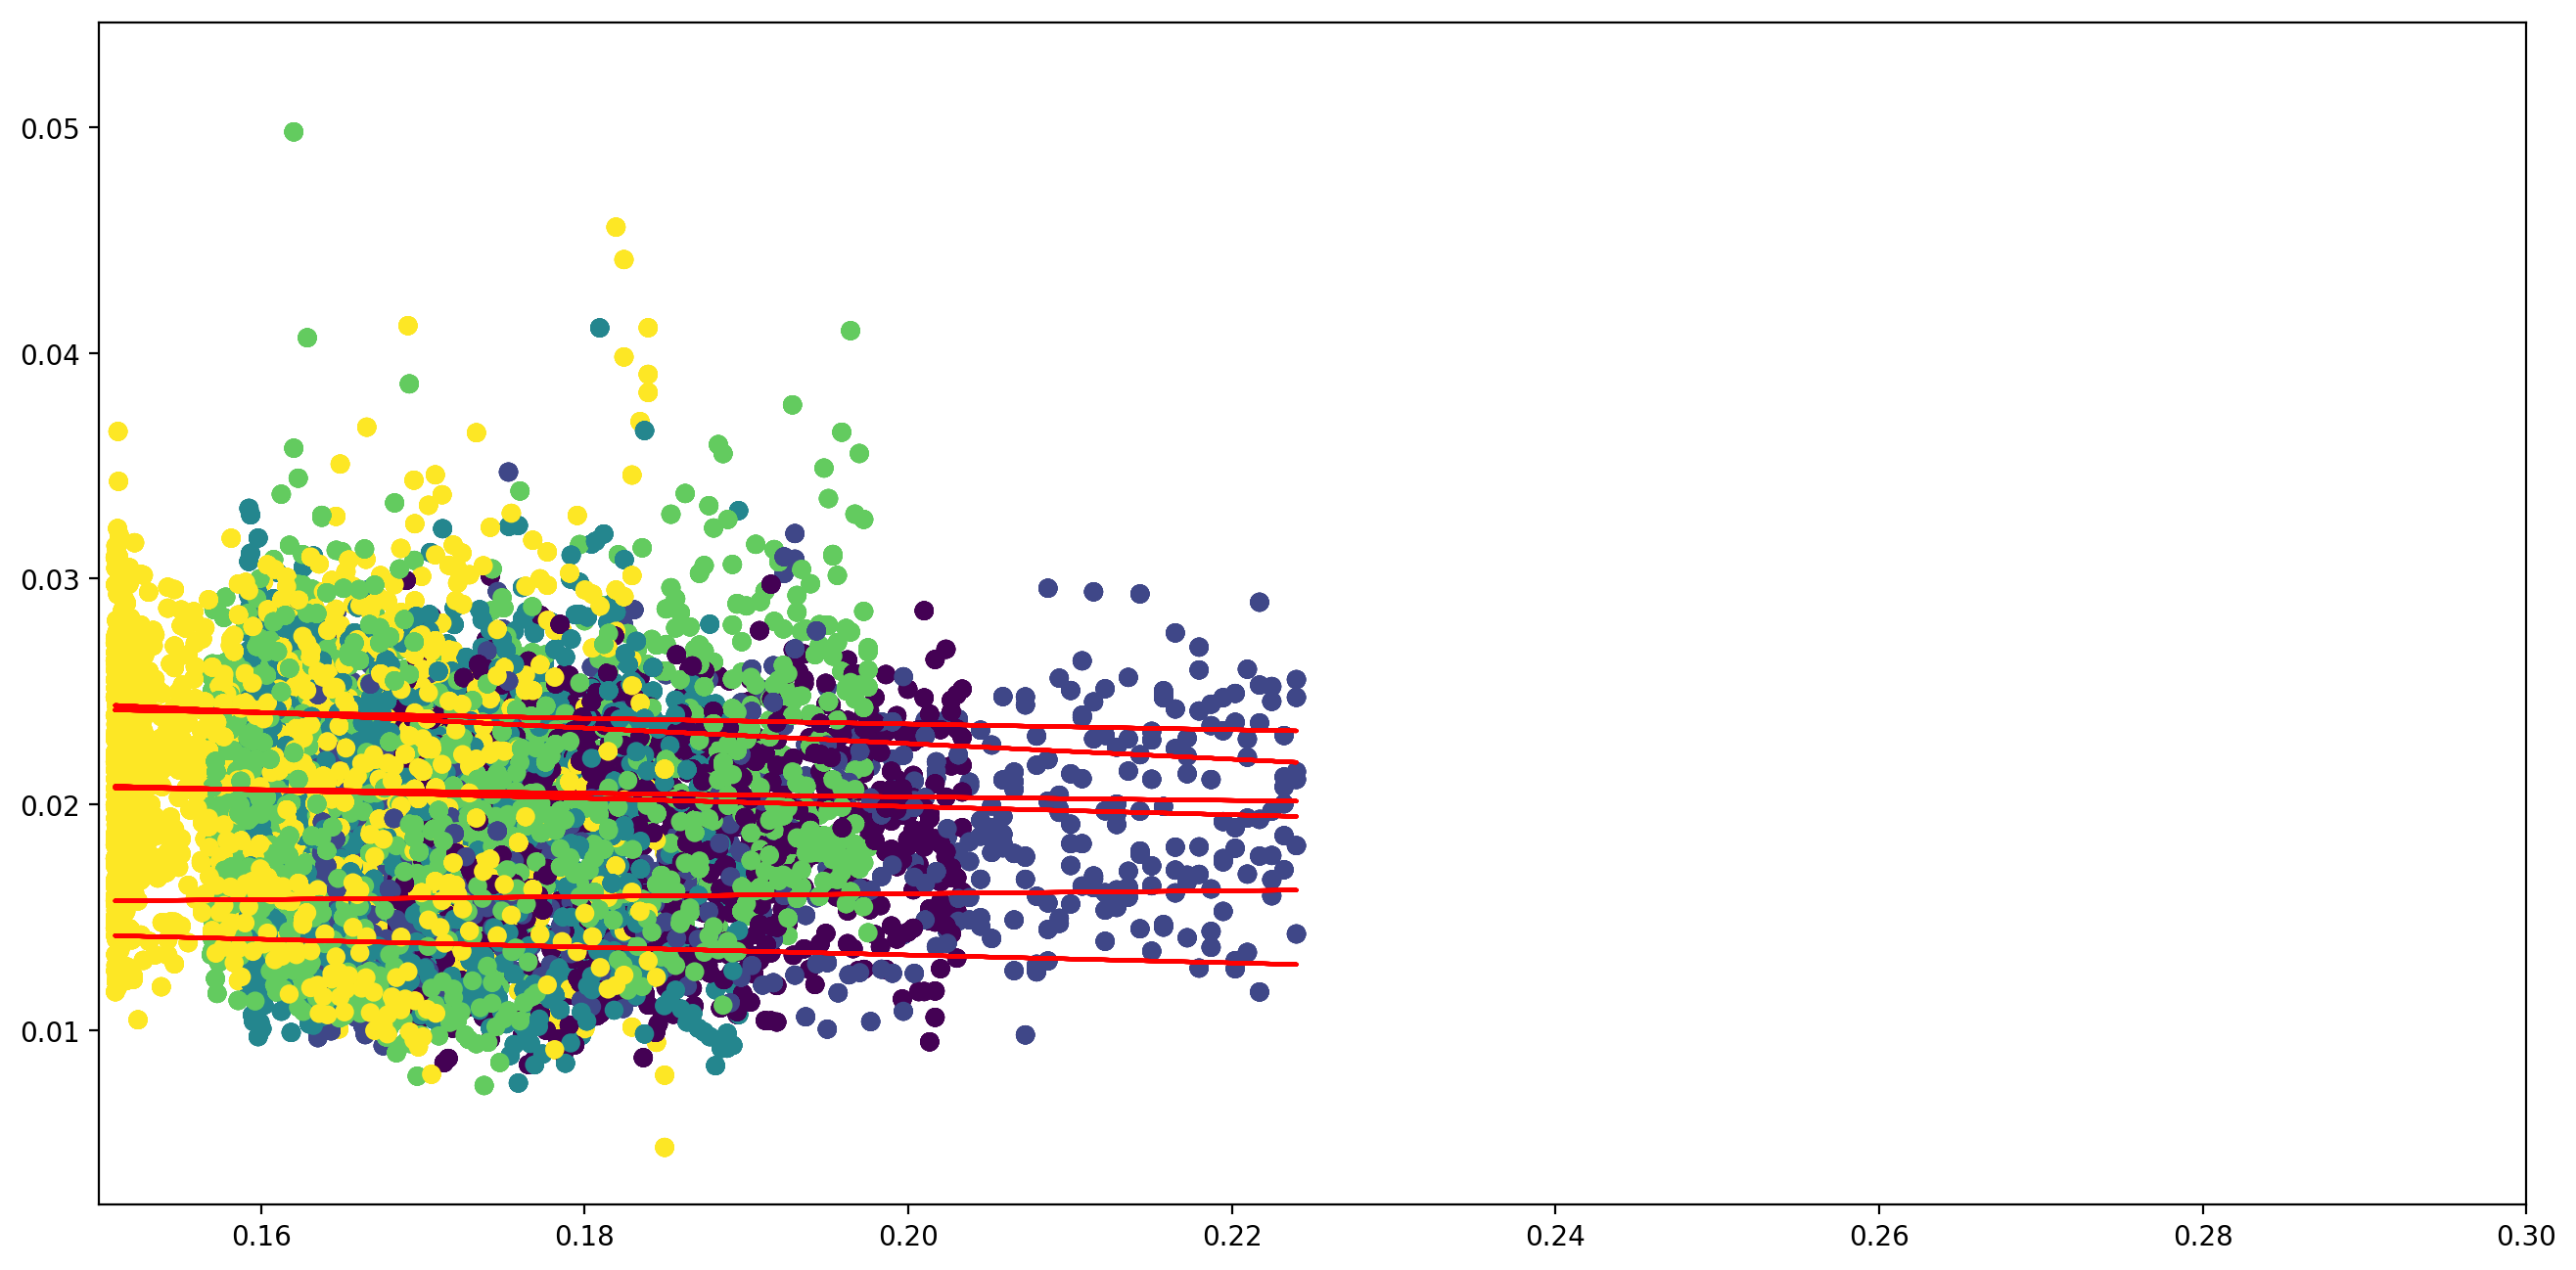

In [41]:
x = d.tile_df['ld'].values
y = tile_tempcovs
#from scipy.stats import rankdata

res = dict()
dfs = []
for time in np.arange(d.T):
    for s in np.arange(d.T):
        yy = np.mean(y[:, time, time, :], axis=1)
        keep = np.logical_and(np.logical_and(np.isfinite(x), np.isfinite(yy)), x < 0.3)

        #plt.scatter(x, yy, c=integerize(d.tile_df['nloci'].values))
        plt.scatter(x, yy, c=integerize(d.tile_df['seqid'].values))
        #X = sm.add_constant(x[keep])
        #X = x[keep]
        xd = pd.DataFrame(dict(t=time,
                               s=s,
                               chrom=d.tile_df['seqid'].values[keep],
                               cummidpoint = d.tile_df['cummidpoint'].values[keep],
                               midpoint = (d.tile_df['start'].values[keep] + d.tile_df['end'].values[keep])/2,
                               cov=yy[keep], r2mean=x[keep], exonic_bp=d.tile_df['exonic_bp'].values[keep]))
        dfs.append(xd)
        #fit = smf.ols('cov ~ r2mean + exonic_bp', xd).fit()
        #ypred = fit.predict(dict(r2mean=xd['r2mean'], exonic_bp=np.repeat(xd['exonic_bp'].mean(), xd.shape[0])))
        fit = smf.ols('cov ~ r2mean + exonic_bp', xd).fit()
        fit2 = smf.ols('cov ~ r2mean', xd).fit()
        ypred = fit2.predict(dict(r2mean=xd['r2mean']))
        plt.plot(xd['r2mean'], ypred, '-', c='red')
        plt.xlim(0.15,0.3)
        # fit = smf.OLS(yy[keep], X).fit()
        # ypred = fit.predict(X)
        # plt.plot(X[:, 1], ypred, '-', c='red')
        fit.summary()
        res[(time)] = (fit2.pvalues[1], fit2.params[0], fit2.params[1], fit2)
pd.concat(dfs, axis=0).to_csv('ld.csv', index=False)

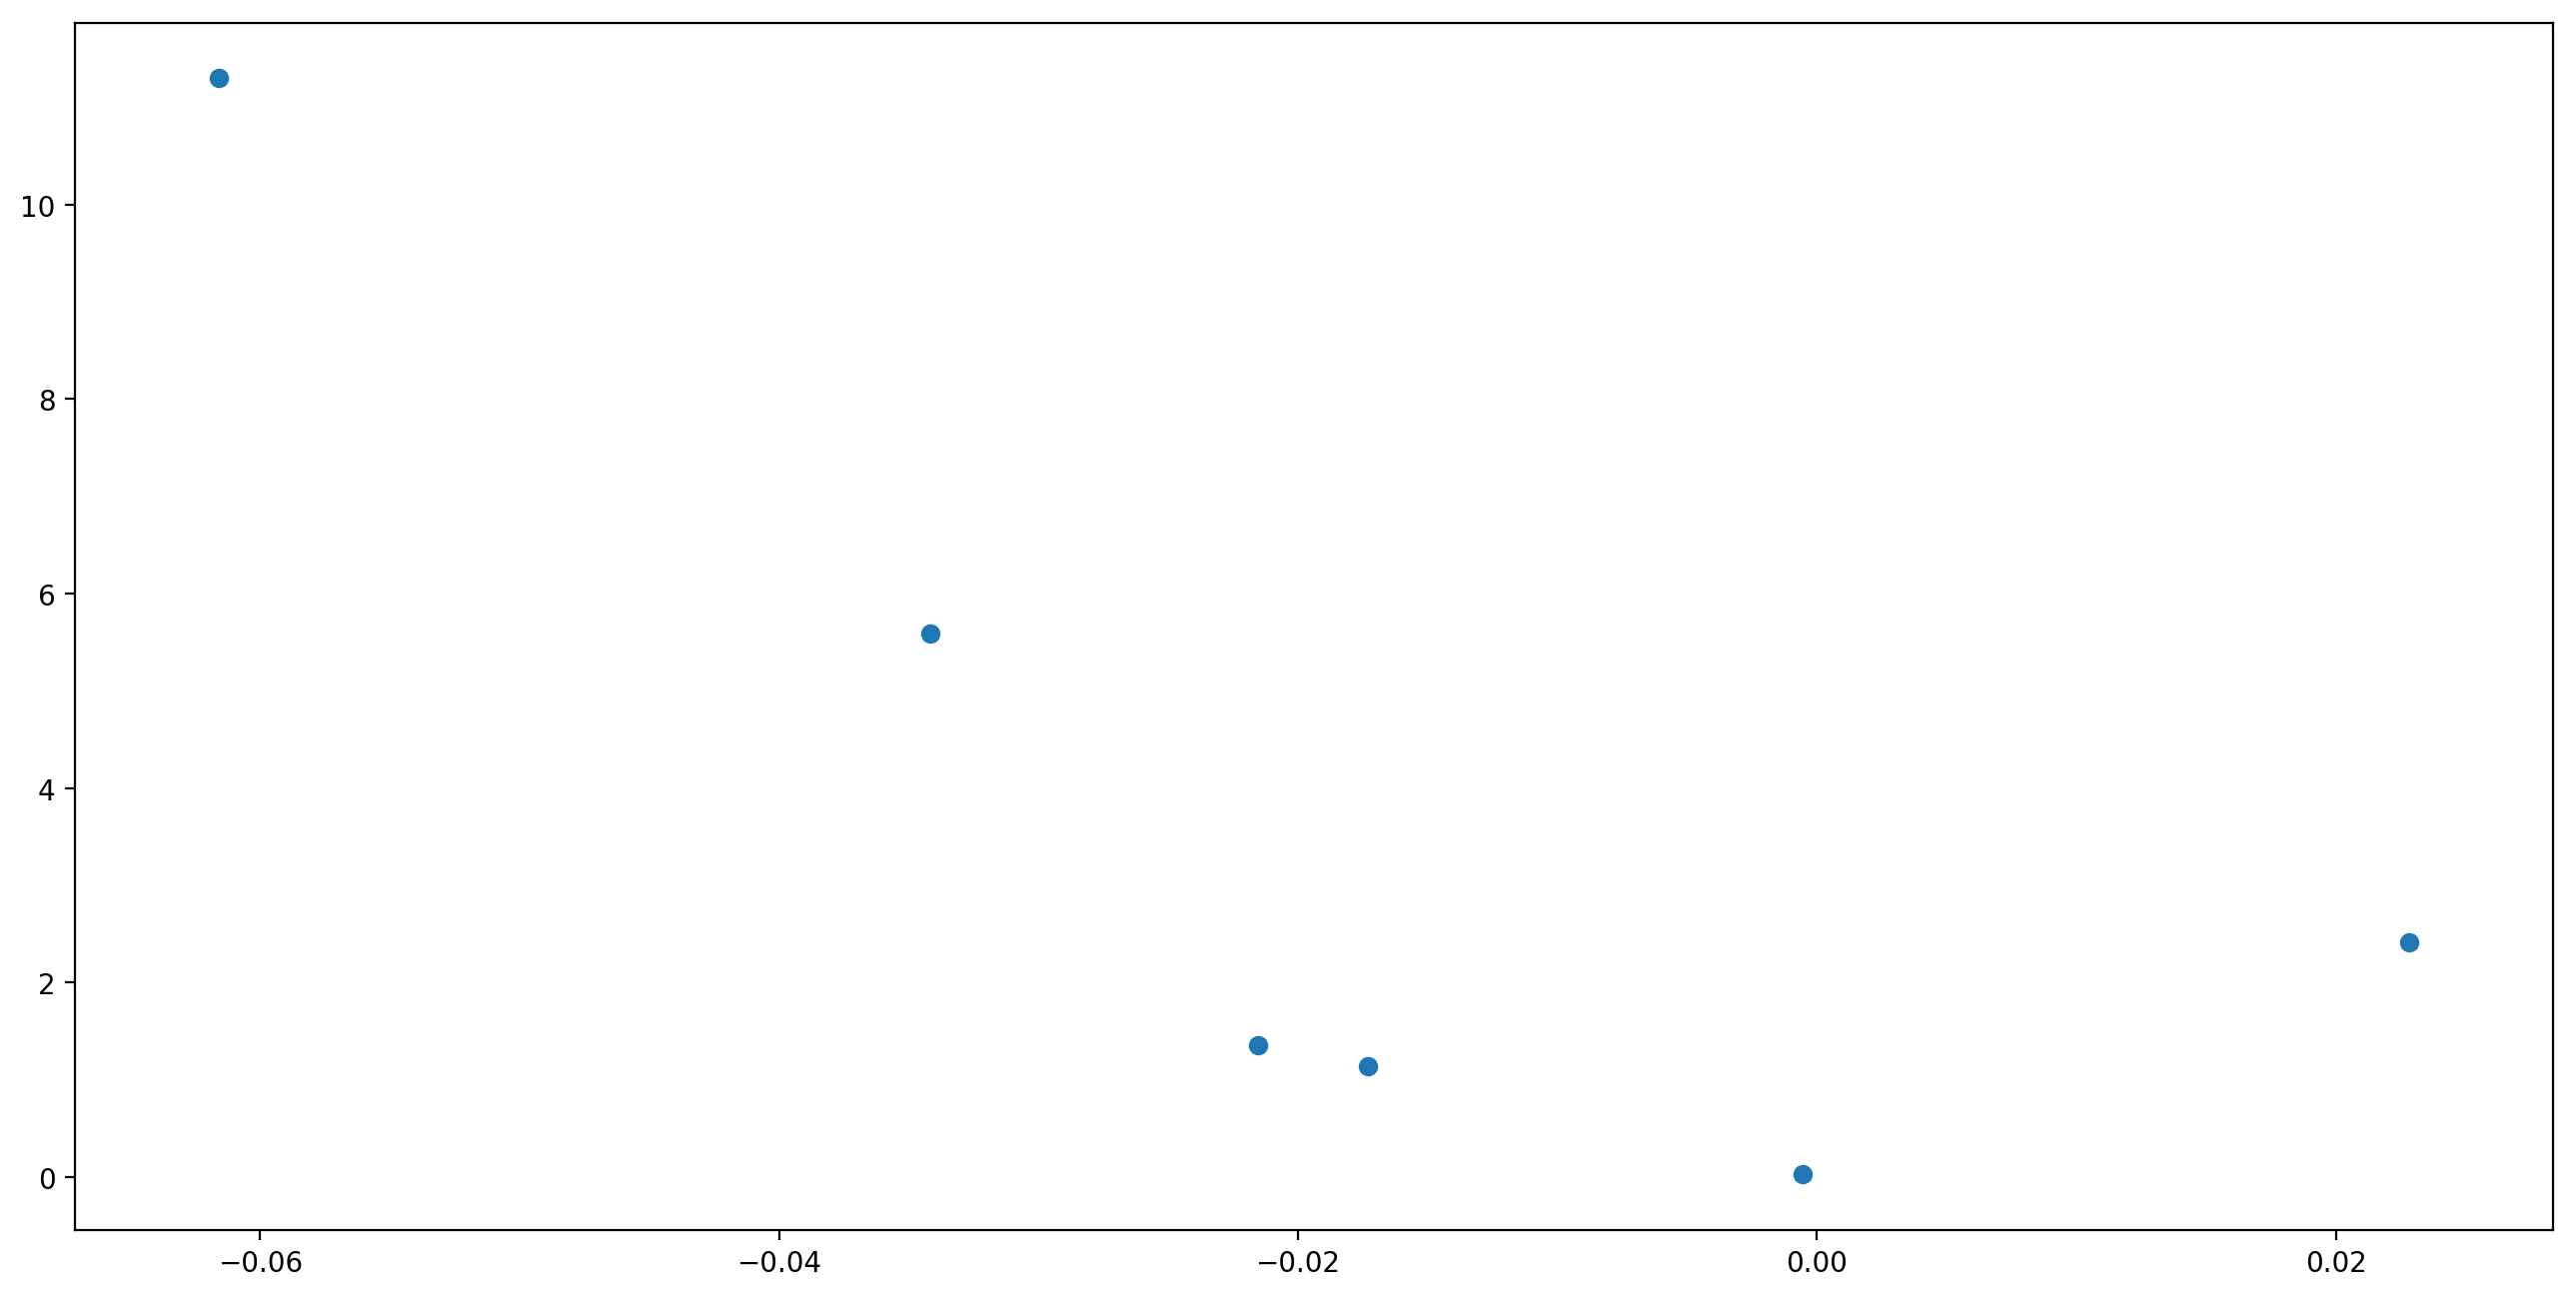

In [114]:
plt.scatter([r[2] for r in res.values()], [-np.log10(r[0]) for r in res.values()])

/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


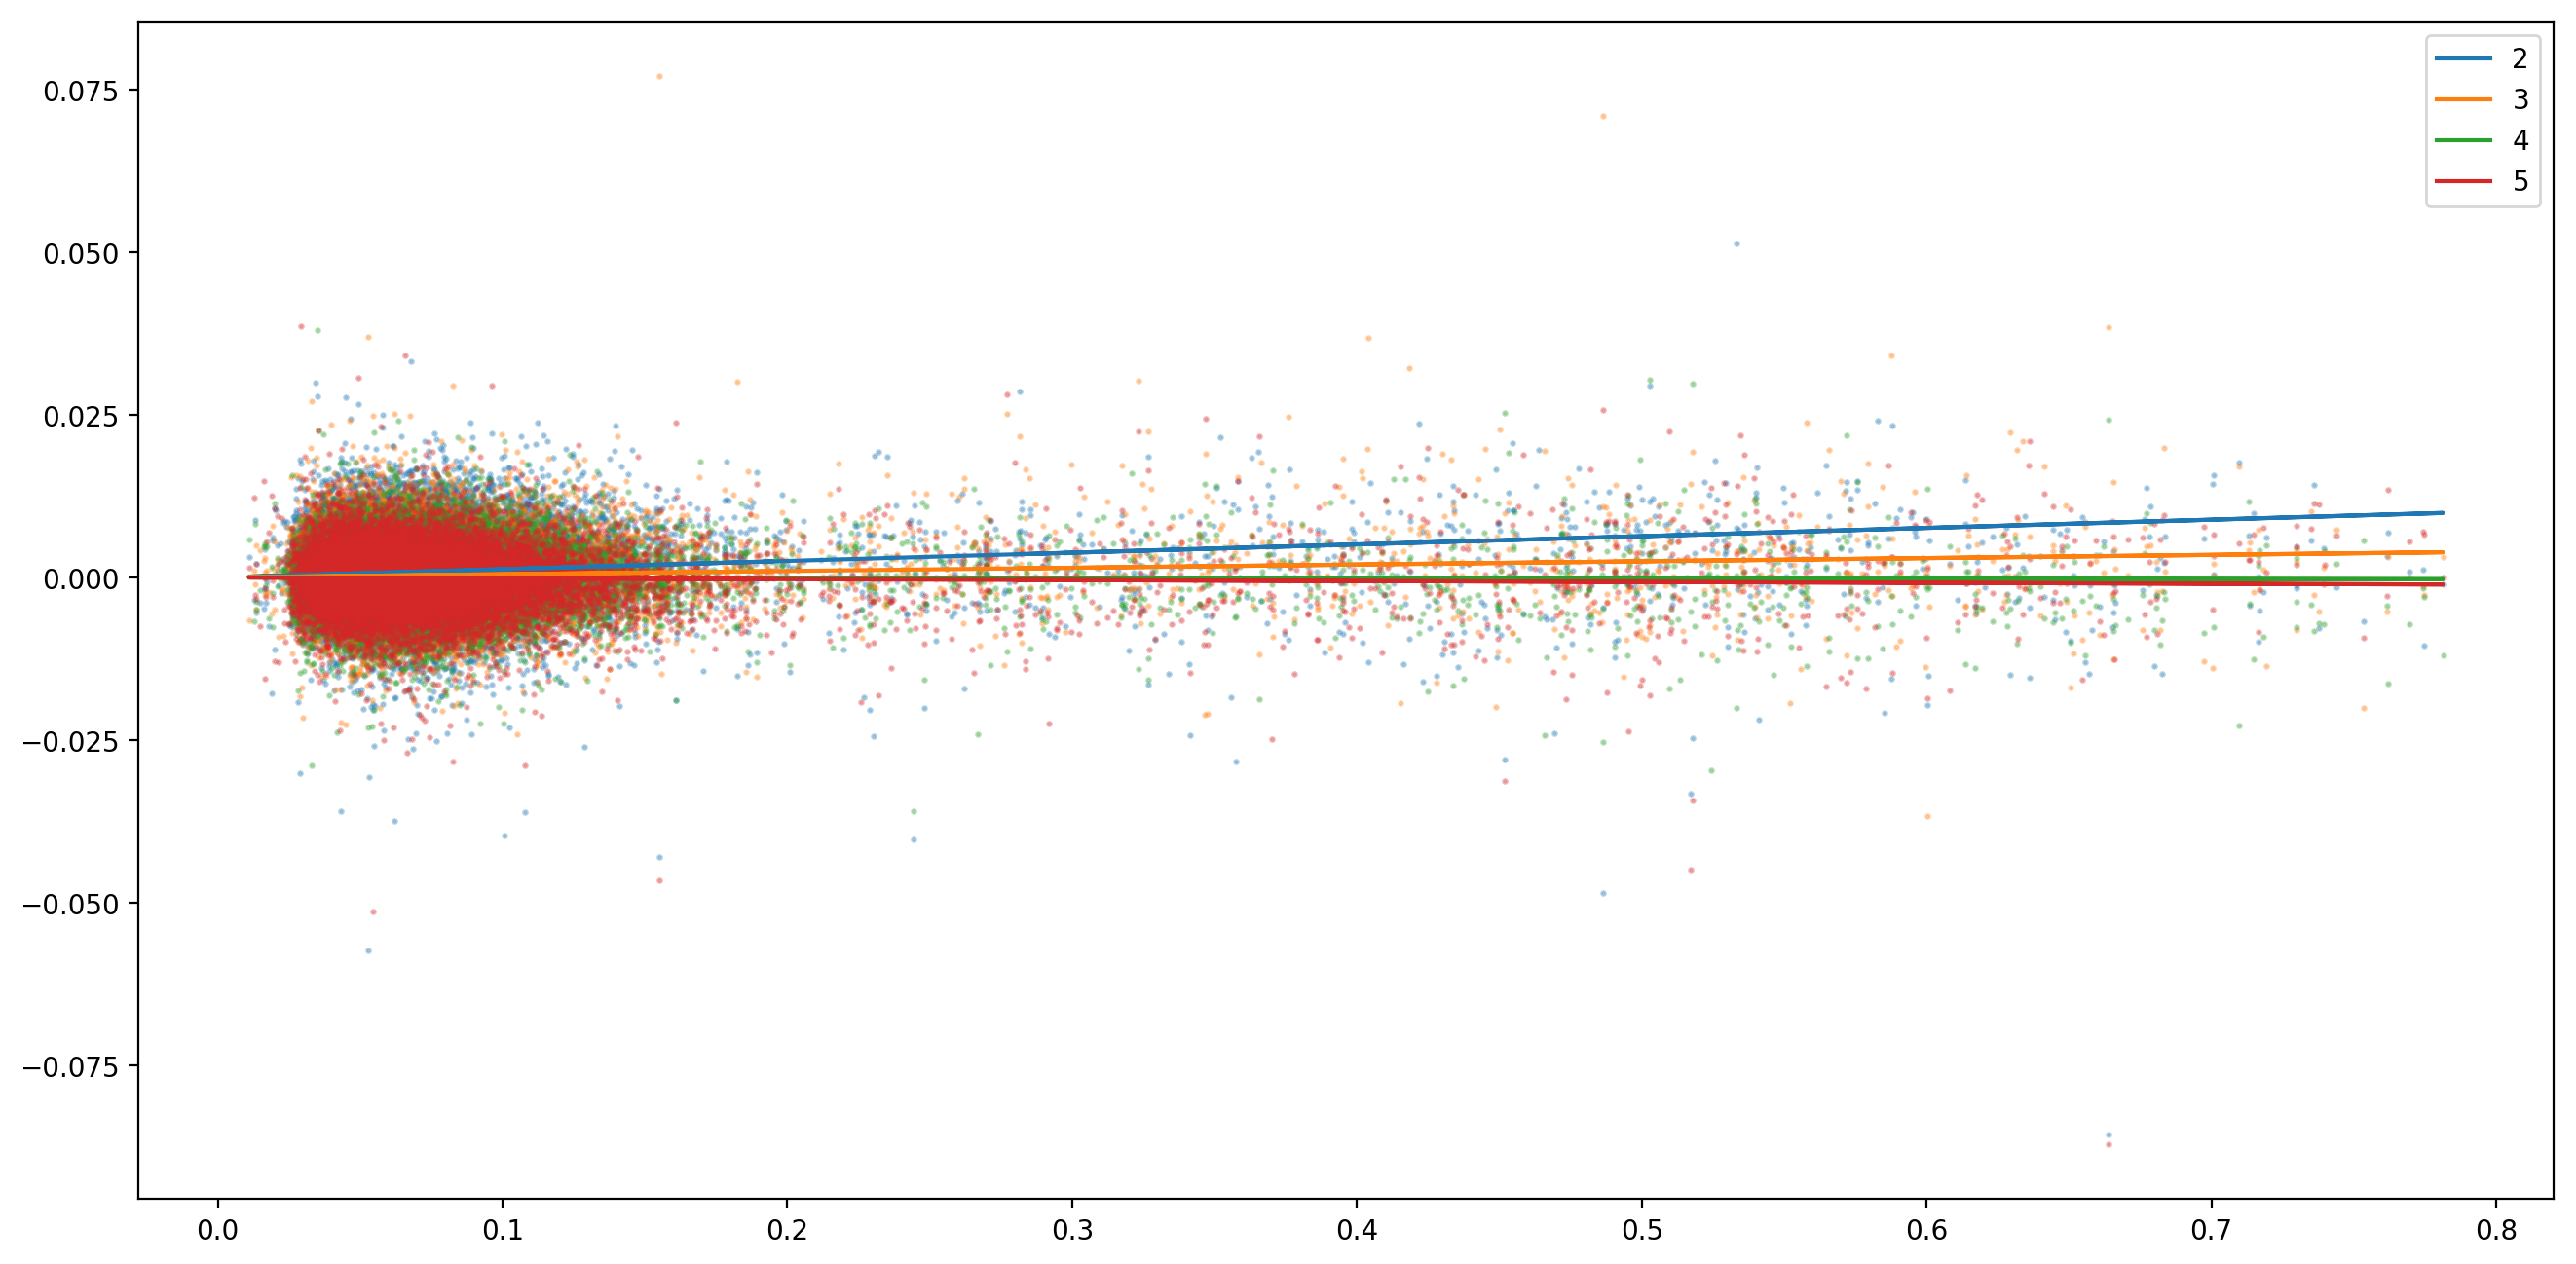

In [358]:
x = d.tile_df['r2mean'].values
y = tile_tempcovs

ld_filter = x<0.8
x = x[ld_filter]
y = y[ld_filter]
refgen = 1
res = dict()
for t in np.arange(refgen+1, 6):
    yy = np.mean(y[:, refgen, t, :], axis=1)
    keep = np.logical_and(np.isfinite(x), np.isfinite(yy))

    plt.scatter(x, yy, alpha=0.3, s=2)
    #X = sm.add_constant(x[keep])
    X = x[keep]
    fit = smf.OLS(yy[keep], X).fit()
    ypred = fit.predict(X)
    plt.plot(x[keep], ypred, '-', label=t)
    #fit.summary()
    #res[(refgen, t)] = np.array([[fit.pvalues[0], fit.params[0]], [fit.pvalues[1], fit.params[1]]])
    res[(refgen, t)] = (fit.params[0], fit.pvalues[0])
plt.legend()

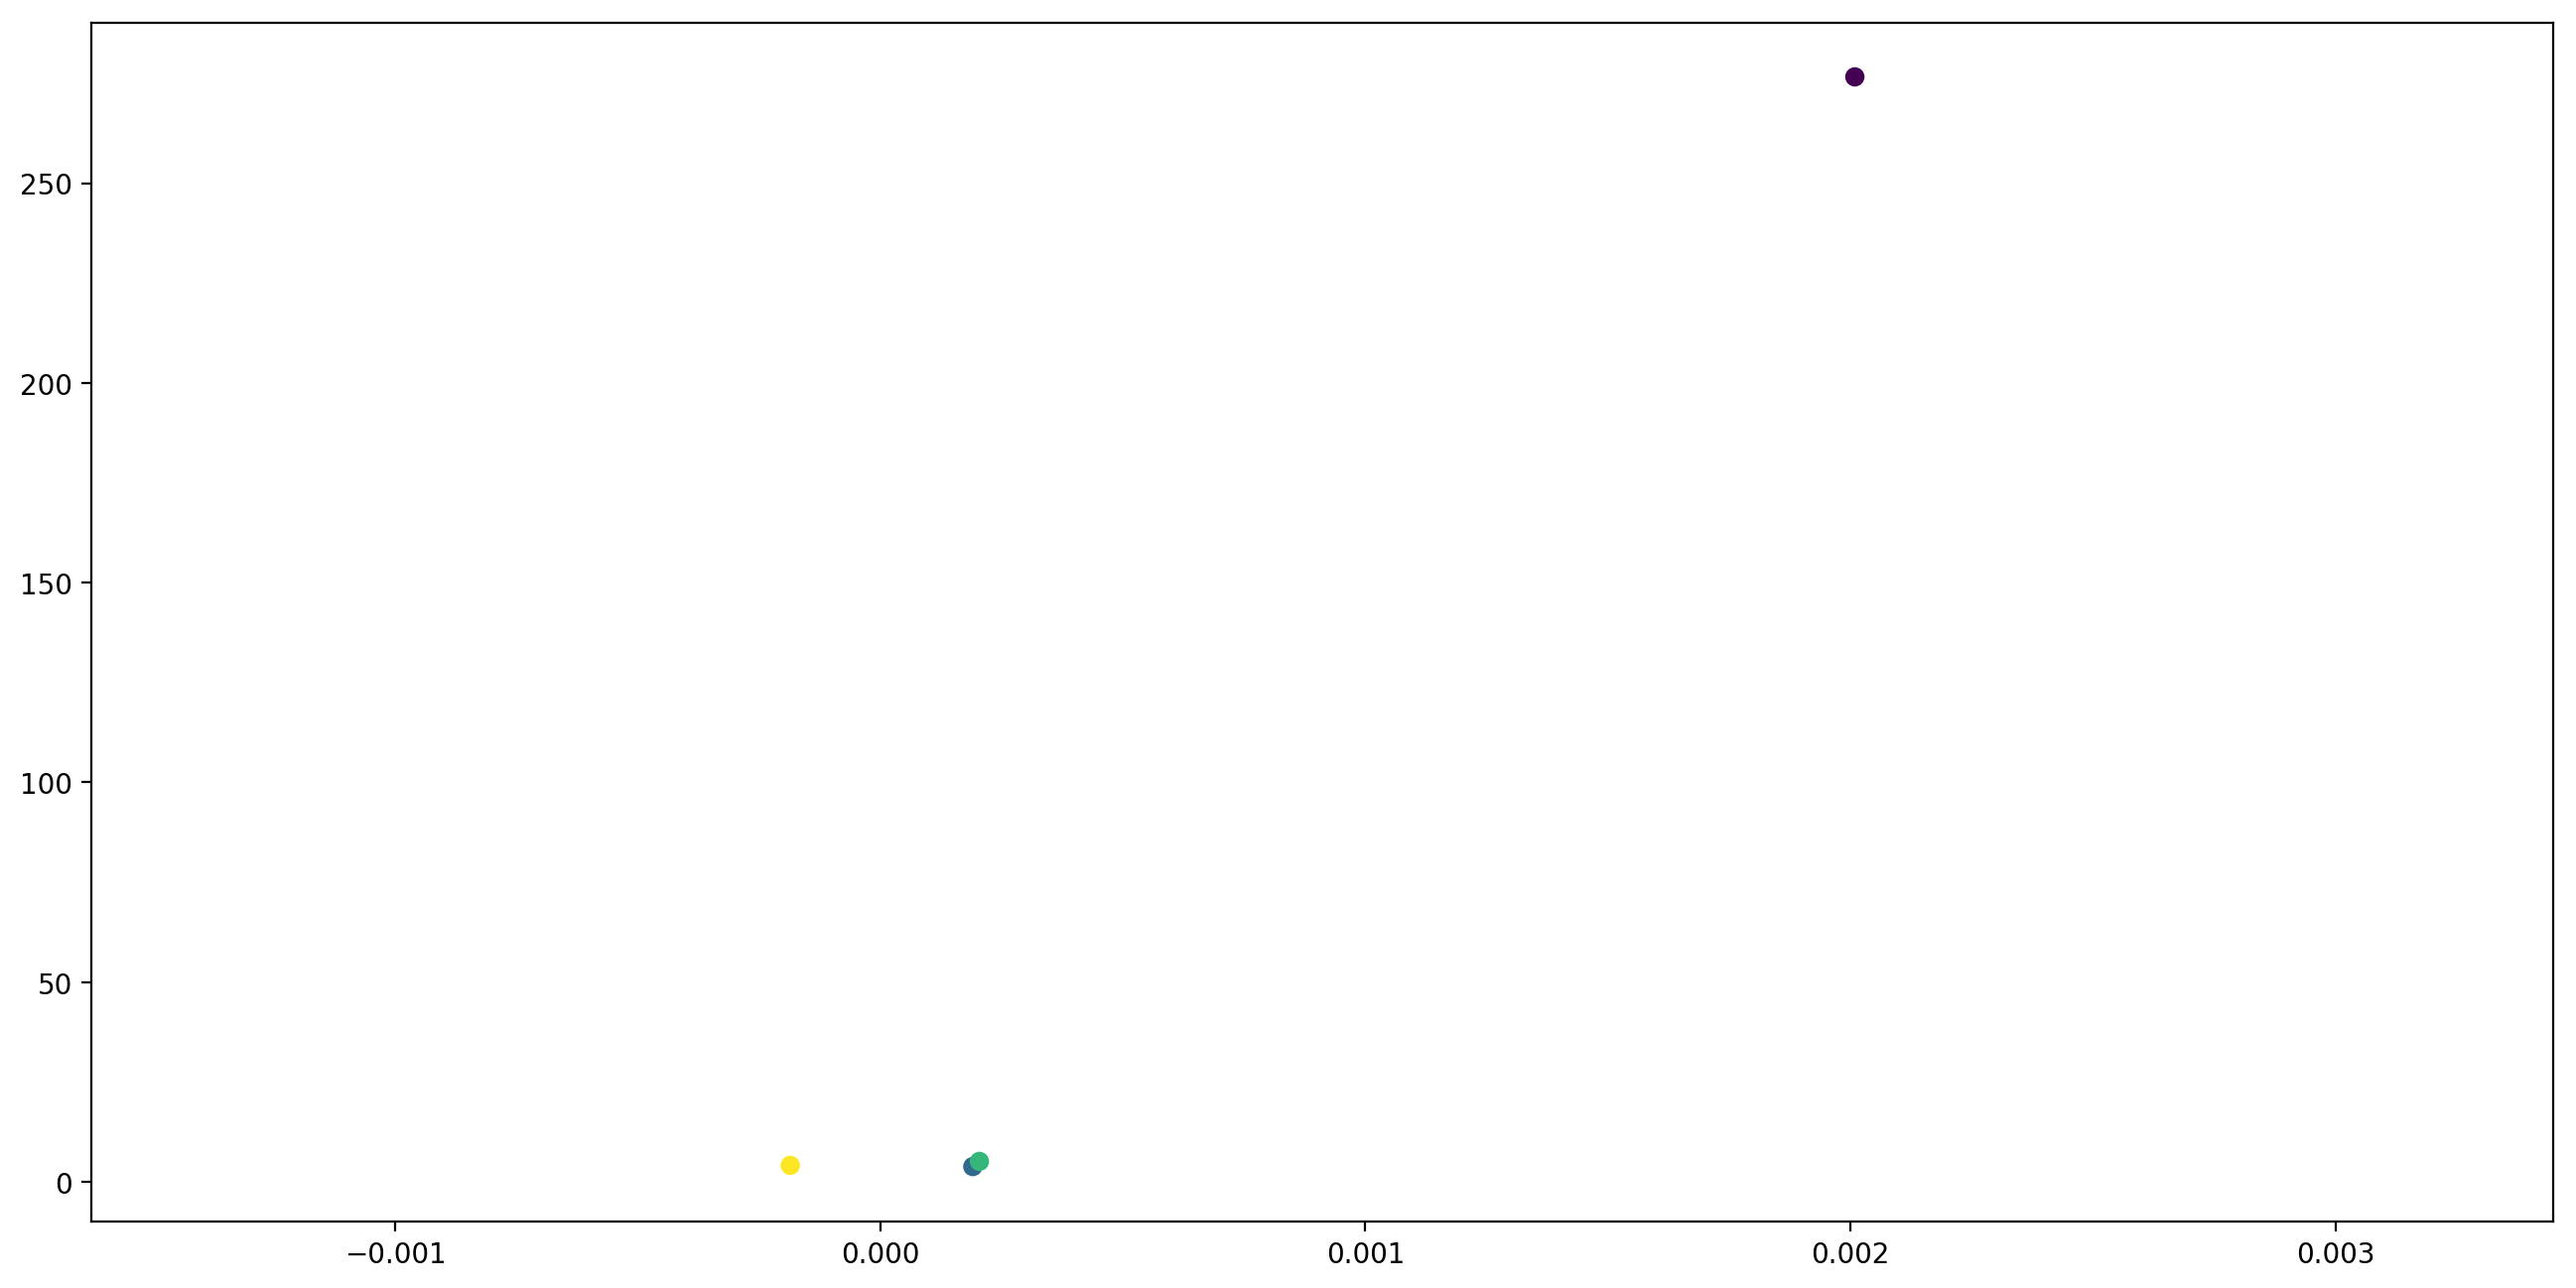

In [357]:
m = np.array(list(zip(*res.values())))
plt.scatter(m[0, :], -np.log10(m[1, :]), c=[t for r, t in res.keys()])

/home/vinceb/projects/optimshifttemp/cvtk/tempdata.py:144: RuntimeWarning: invalid value encountered in less_equal
  remove = np.logical_or(freqs <= min_af, freqs >= 1-min_af)
/home/vinceb/projects/optimshifttemp/cvtk/tempdata.py:144: RuntimeWarning: invalid value encountered in greater_equal
  remove = np.logical_or(freqs <= min_af, freqs >= 1-min_af)


removing 156617288 (44.0%) loci <= 0.1 or >= 0.9
removing 156617288 (44.0%) loci <= 0.1 or >= 0.9


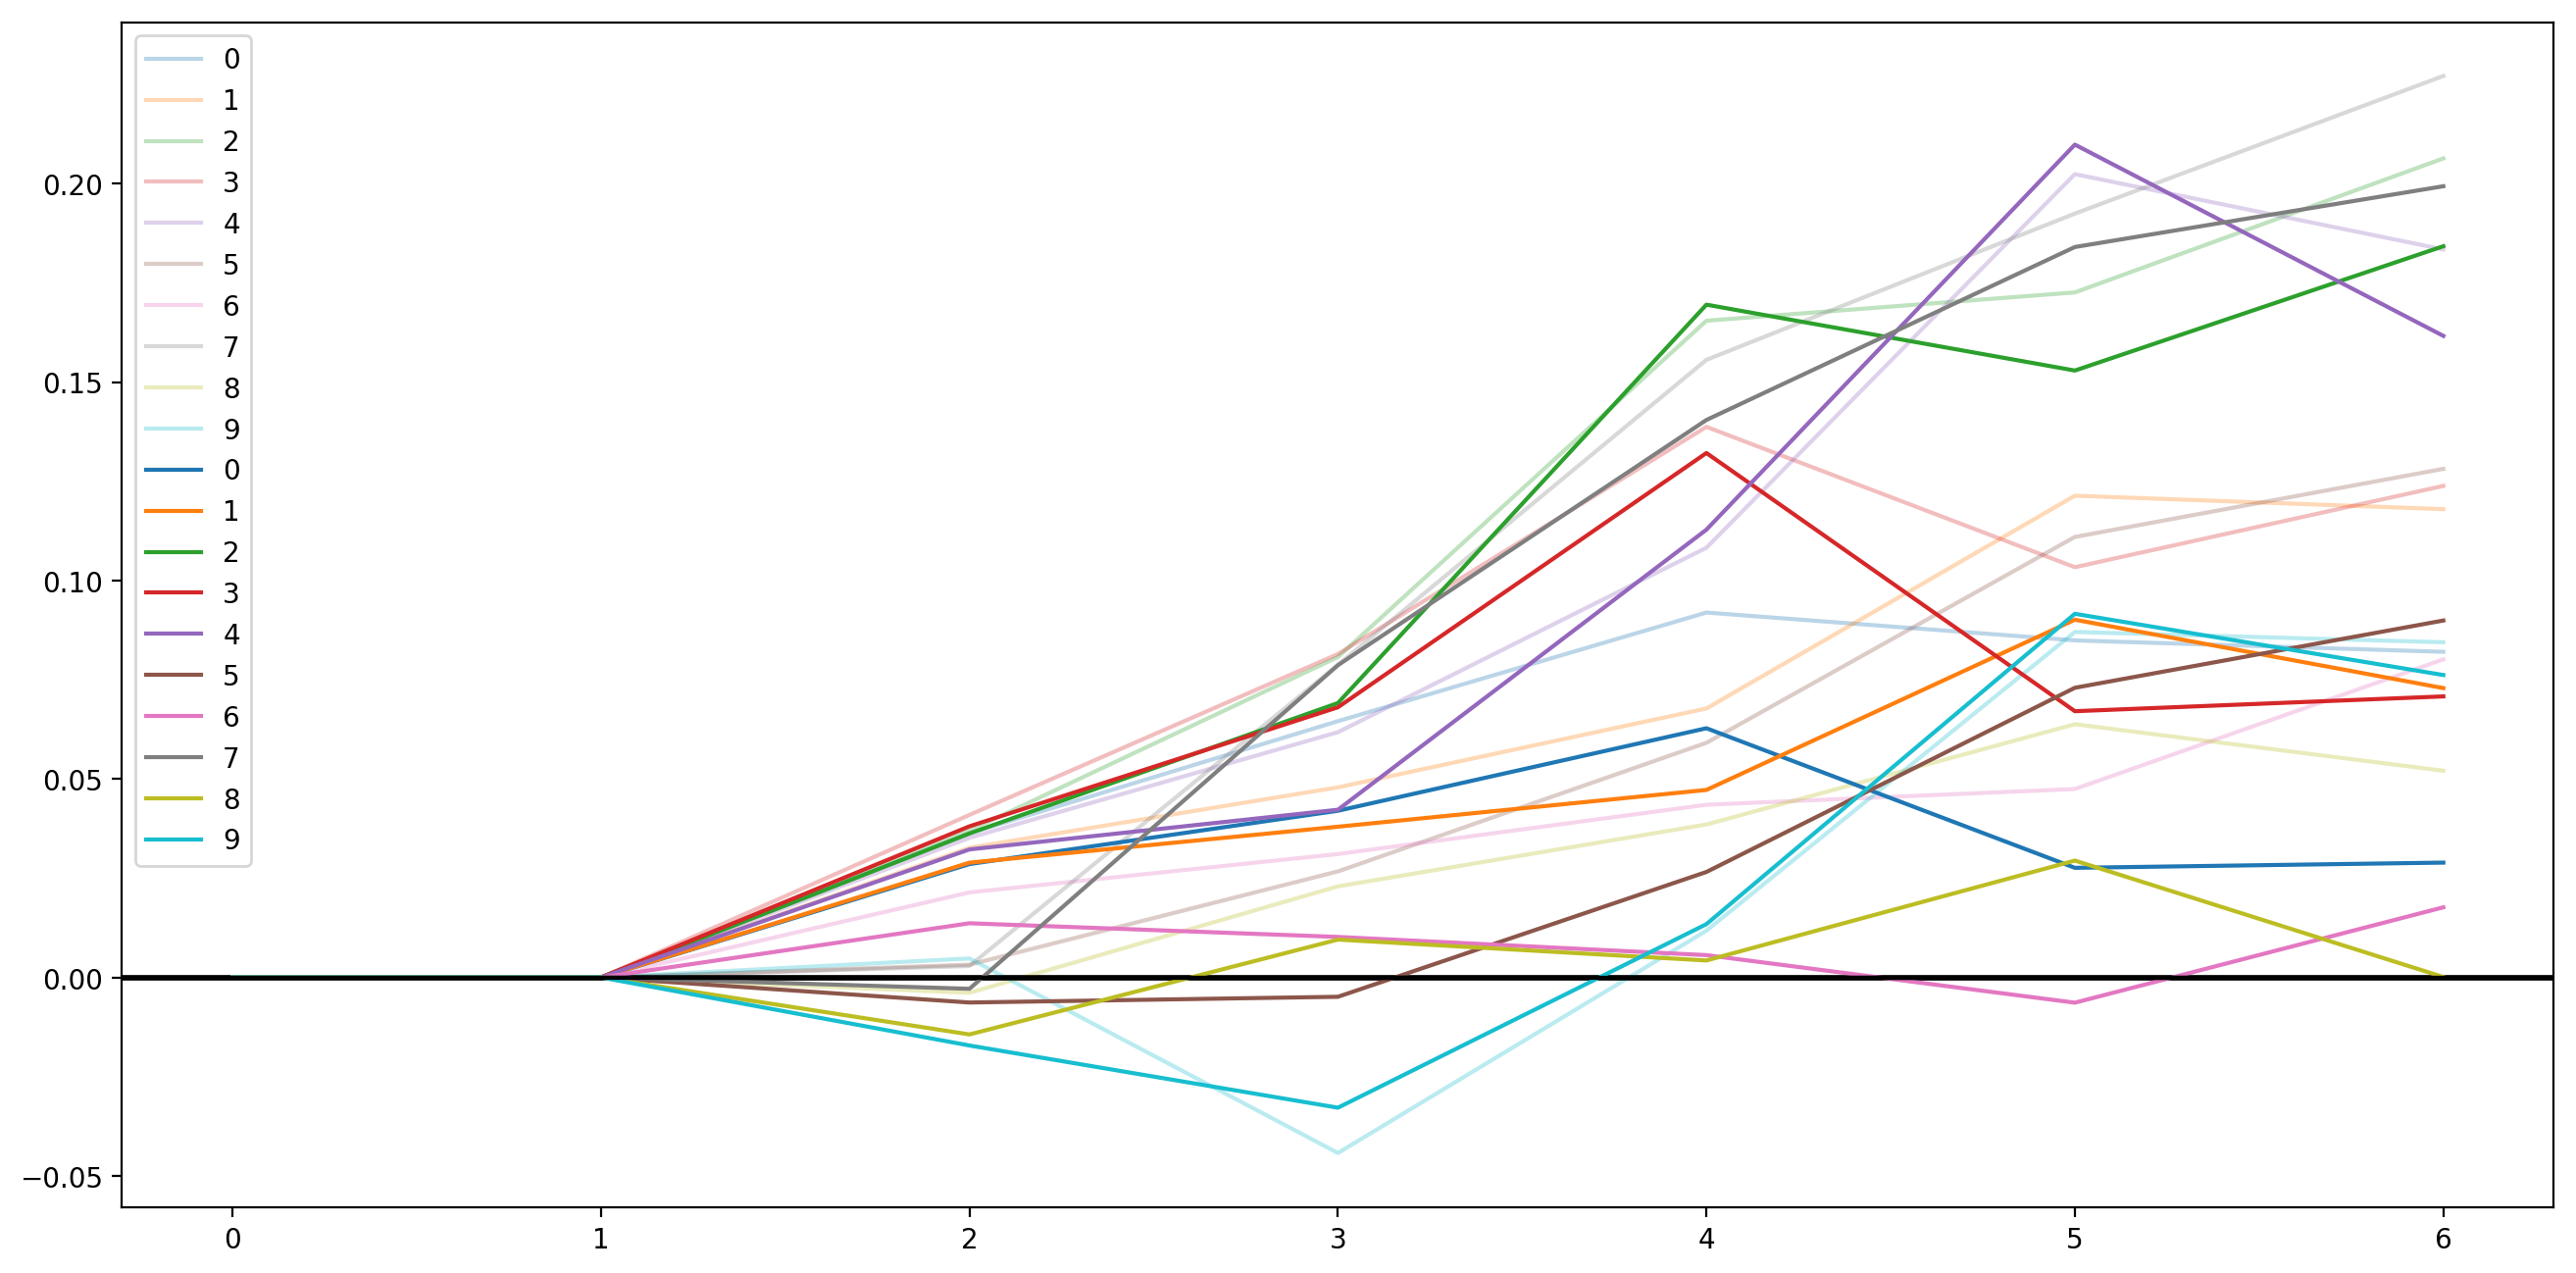

In [127]:
d.calc_covs(min_af=None)
reps = np.broadcast_to(np.arange(10), (7, 10))
G = np.stack([d._G(t) for t in np.arange(d.T+1)])

x = np.repeat(np.arange(7), 10).reshape((7, 10))
for rep in np.arange(d.R):
    plt.plot(x[:, rep], G[:, rep], '-', label=rep, alpha=0.3)
    plt.axhline(y=0, c='k')
#plt.legend(loc='upper left')

d.calc_covs(min_af=0.1, depth_limits=(100, 300), standardize=False)
reps = np.broadcast_to(np.arange(10), (7, 10))
G = np.stack([d._G(t) for t in np.arange(d.T+1)])

x = np.repeat(np.arange(7), 10).reshape((7, 10))
for rep in np.arange(d.R):
    plt.plot(x[:, rep], G[:, rep], '-', label=rep)
    plt.axhline(y=0, c='k')
plt.legend(loc='upper left')
plt.show()

removing 141150859 (40.0%) loci <= 0.05 or >= 0.95
removing 141150859 (40.0%) loci <= 0.05 or >= 0.95


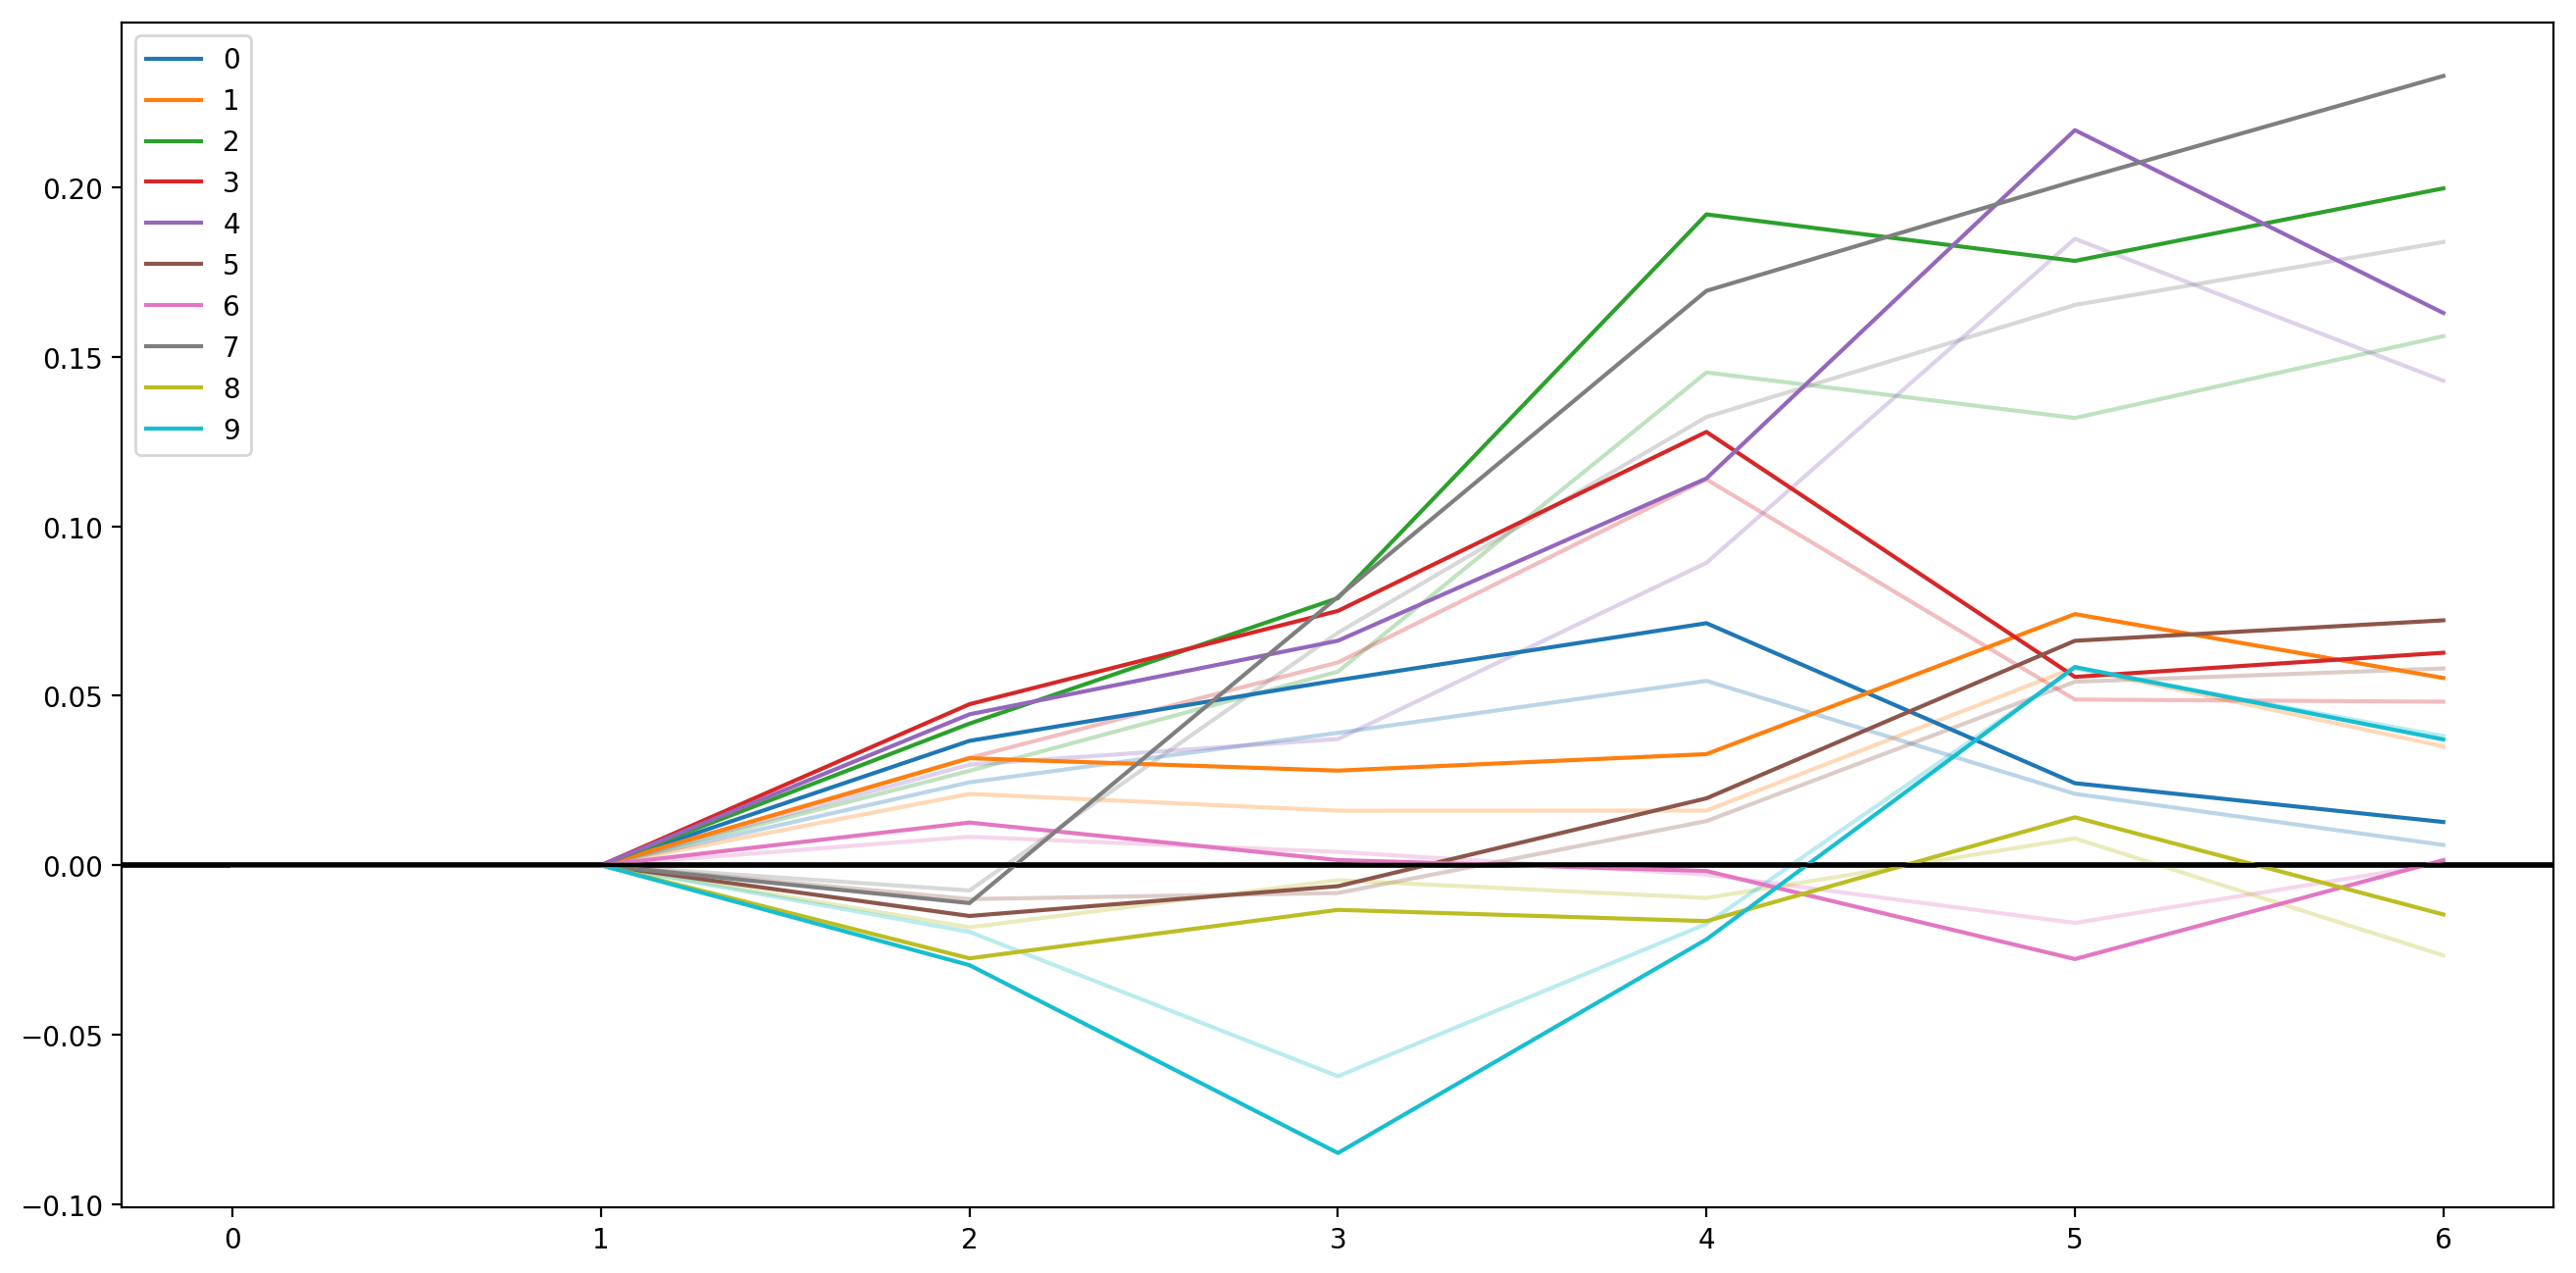

In [192]:
reps = np.broadcast_to(np.arange(10), (7, 10))
G = np.stack([d._G(t, double_offdiag=False) for t in np.arange(d.T+1)])
x = np.repeat(np.arange(7), 10).reshape((7, 10))
for rep in np.arange(d.R):
    plt.plot(x[:, rep], G[:, rep], '-', alpha=0.3)
    plt.axhline(y=0, c='k')

d.calc_covs(min_af=0.05)
reps = np.broadcast_to(np.arange(10), (7, 10))
G = np.stack([d._G(t, double_offdiag=True) for t in np.arange(d.T+1)])

x = np.repeat(np.arange(7), 10).reshape((7, 10))
for rep in np.arange(d.R):
    plt.plot(x[:, rep], G[:, rep], '-', label=rep)
    plt.axhline(y=0, c='k')
plt.legend(loc='upper left')
plt.show()

In [19]:
d.calc_covs(min_af=0.05)
reps = np.broadcast_to(np.arange(10), (7, 10))
G = np.stack([d._G(t) for t in np.arange(d.T+1)])

x = np.repeat(np.arange(7), 10).reshape((7, 10))
for rep in np.arange(d.R):
    plt.plot(x[:, rep], G[:, rep], '-', label=rep)
    plt.axhline(y=0, c='k')
plt.legend(loc='upper left')
plt.show()

removing 70181071 (20.0%) fixed or lost alleles


/home/vinceb/projects/optimshifttemp/cvtk/tempdata.py:137: RuntimeWarning: invalid value encountered in less
  remove = np.logical_or(freqs < min_af, freqs > 1-min_af)
/home/vinceb/projects/optimshifttemp/cvtk/tempdata.py:137: RuntimeWarning: invalid value encountered in greater
  remove = np.logical_or(freqs < min_af, freqs > 1-min_af)


removing 70681036 (20.0%) loci < 0.05 or > 0.95
removing 70181071 (20.0%) fixed or lost alleles
removing 70681036 (20.0%) loci < 0.05 or > 0.95
> /home/vinceb/projects/optimshifttemp/cvtk/tempdata.py(312)calc_covs()
-> loci_slice = slice_loci_by_seqids(self.gintervals.seqid, exclude_seqids)


(Pdb)  hets


array([[0.30581423, 0.30883297, 0.31156804, 0.31494319, 0.31647913,
        0.319414  , 0.32002544],
       [0.30582286, 0.30866879, 0.31311749, 0.3166041 , 0.31927607,
        0.32254603, 0.32322751],
       [0.30558653, 0.30941657, 0.31443857, 0.31953449, 0.32028462,
        0.32326997, 0.3243592 ],
       [0.30568342, 0.30934927, 0.31455008, 0.31954549, 0.32298729,
        0.3248438 , 0.32633001],
       [0.30548786, 0.31077476, 0.31465778, 0.31988579, 0.3208782 ,
        0.32358096, 0.32546619],
       [0.30588789, 0.30944272, 0.31220873, 0.31720699, 0.31957655,
        0.32157359, 0.32197966],
       [0.30581034, 0.30987365, 0.31432615, 0.31769606, 0.32078958,
        0.32281897, 0.32425759],
       [0.30588882, 0.31029479, 0.31350415, 0.3172932 , 0.32296888,
        0.32383579, 0.32604474],
       [0.30544906, 0.30924295, 0.31249858, 0.31596575, 0.3200715 ,
        0.32119437, 0.32338997],
       [0.30575363, 0.31097343, 0.31797567, 0.31531827, 0.31977805,
        0.32173561, 0.3

(Pdb)  freqs = filter_freqs(self.freqs, convert_fixations_to_nan=fixations_to_nan, min_af=None)


removing 70181071 (20.0%) fixed or lost alleles


(Pdb)  hets2 = calc_mean_hets(freqs)
(Pdb)  hets2


array([[0.22407871, 0.24159694, 0.24414985, 0.25747485, 0.25373675,
        0.26271999, 0.25553263],
       [0.22534375, 0.24060086, 0.25396894, 0.25841601, 0.2576199 ,
        0.26519949, 0.26380666],
       [0.22129861, 0.24748725, 0.24493931, 0.26214694, 0.25164528,
        0.26334163, 0.26731456],
       [0.22484472, 0.2417535 , 0.24907845, 0.26288002, 0.26077186,
        0.26278062, 0.2733838 ],
       [0.21986339, 0.24111275, 0.24735036, 0.2748282 , 0.25940343,
        0.26017415, 0.26611151],
       [0.22437428, 0.24315101, 0.24122373, 0.26577457, 0.26197864,
        0.26334262, 0.26532382],
       [0.22449838, 0.24005522, 0.24637355, 0.25323756, 0.25764688,
        0.26210284, 0.2619556 ],
       [0.22637052, 0.24378221, 0.2448733 , 0.2451753 , 0.26270781,
        0.26242022, 0.26156999],
       [0.22056891, 0.23954748, 0.25382031, 0.24655905, 0.2645796 ,
        0.25381314, 0.25520527],
       [0.22539472, 0.24286631, 0.28019384, 0.24863201, 0.25569149,
        0.25873427, 0.2

(Pdb)  exit


BdbQuit: 

In [76]:
d.calc_covs(min_af=0.1, min_N=30)
reps = np.broadcast_to(np.arange(10), (7, 10))
G = np.stack([d._G(t) for t in np.arange(d.T+1)])

x = np.repeat(np.arange(7), 10).reshape((7, 10))
for rep in np.arange(d.R):
    plt.plot(x[:, rep], G[:, rep], '-', label=rep)
    plt.axhline(y=0, c='k')
plt.legend(loc='upper left')
plt.show()

removing 187033802 (52.0%) loci < 0.1 or > 0.9
removing 187033802 (52.0%) loci < 0.1 or > 0.9


KeyboardInterrupt: 

In [18]:
cov_df = d.tile_cov_df(min_af=0.1)

AttributeError: 'TemporalFreqs' object has no attribute 'tile_cov_df'

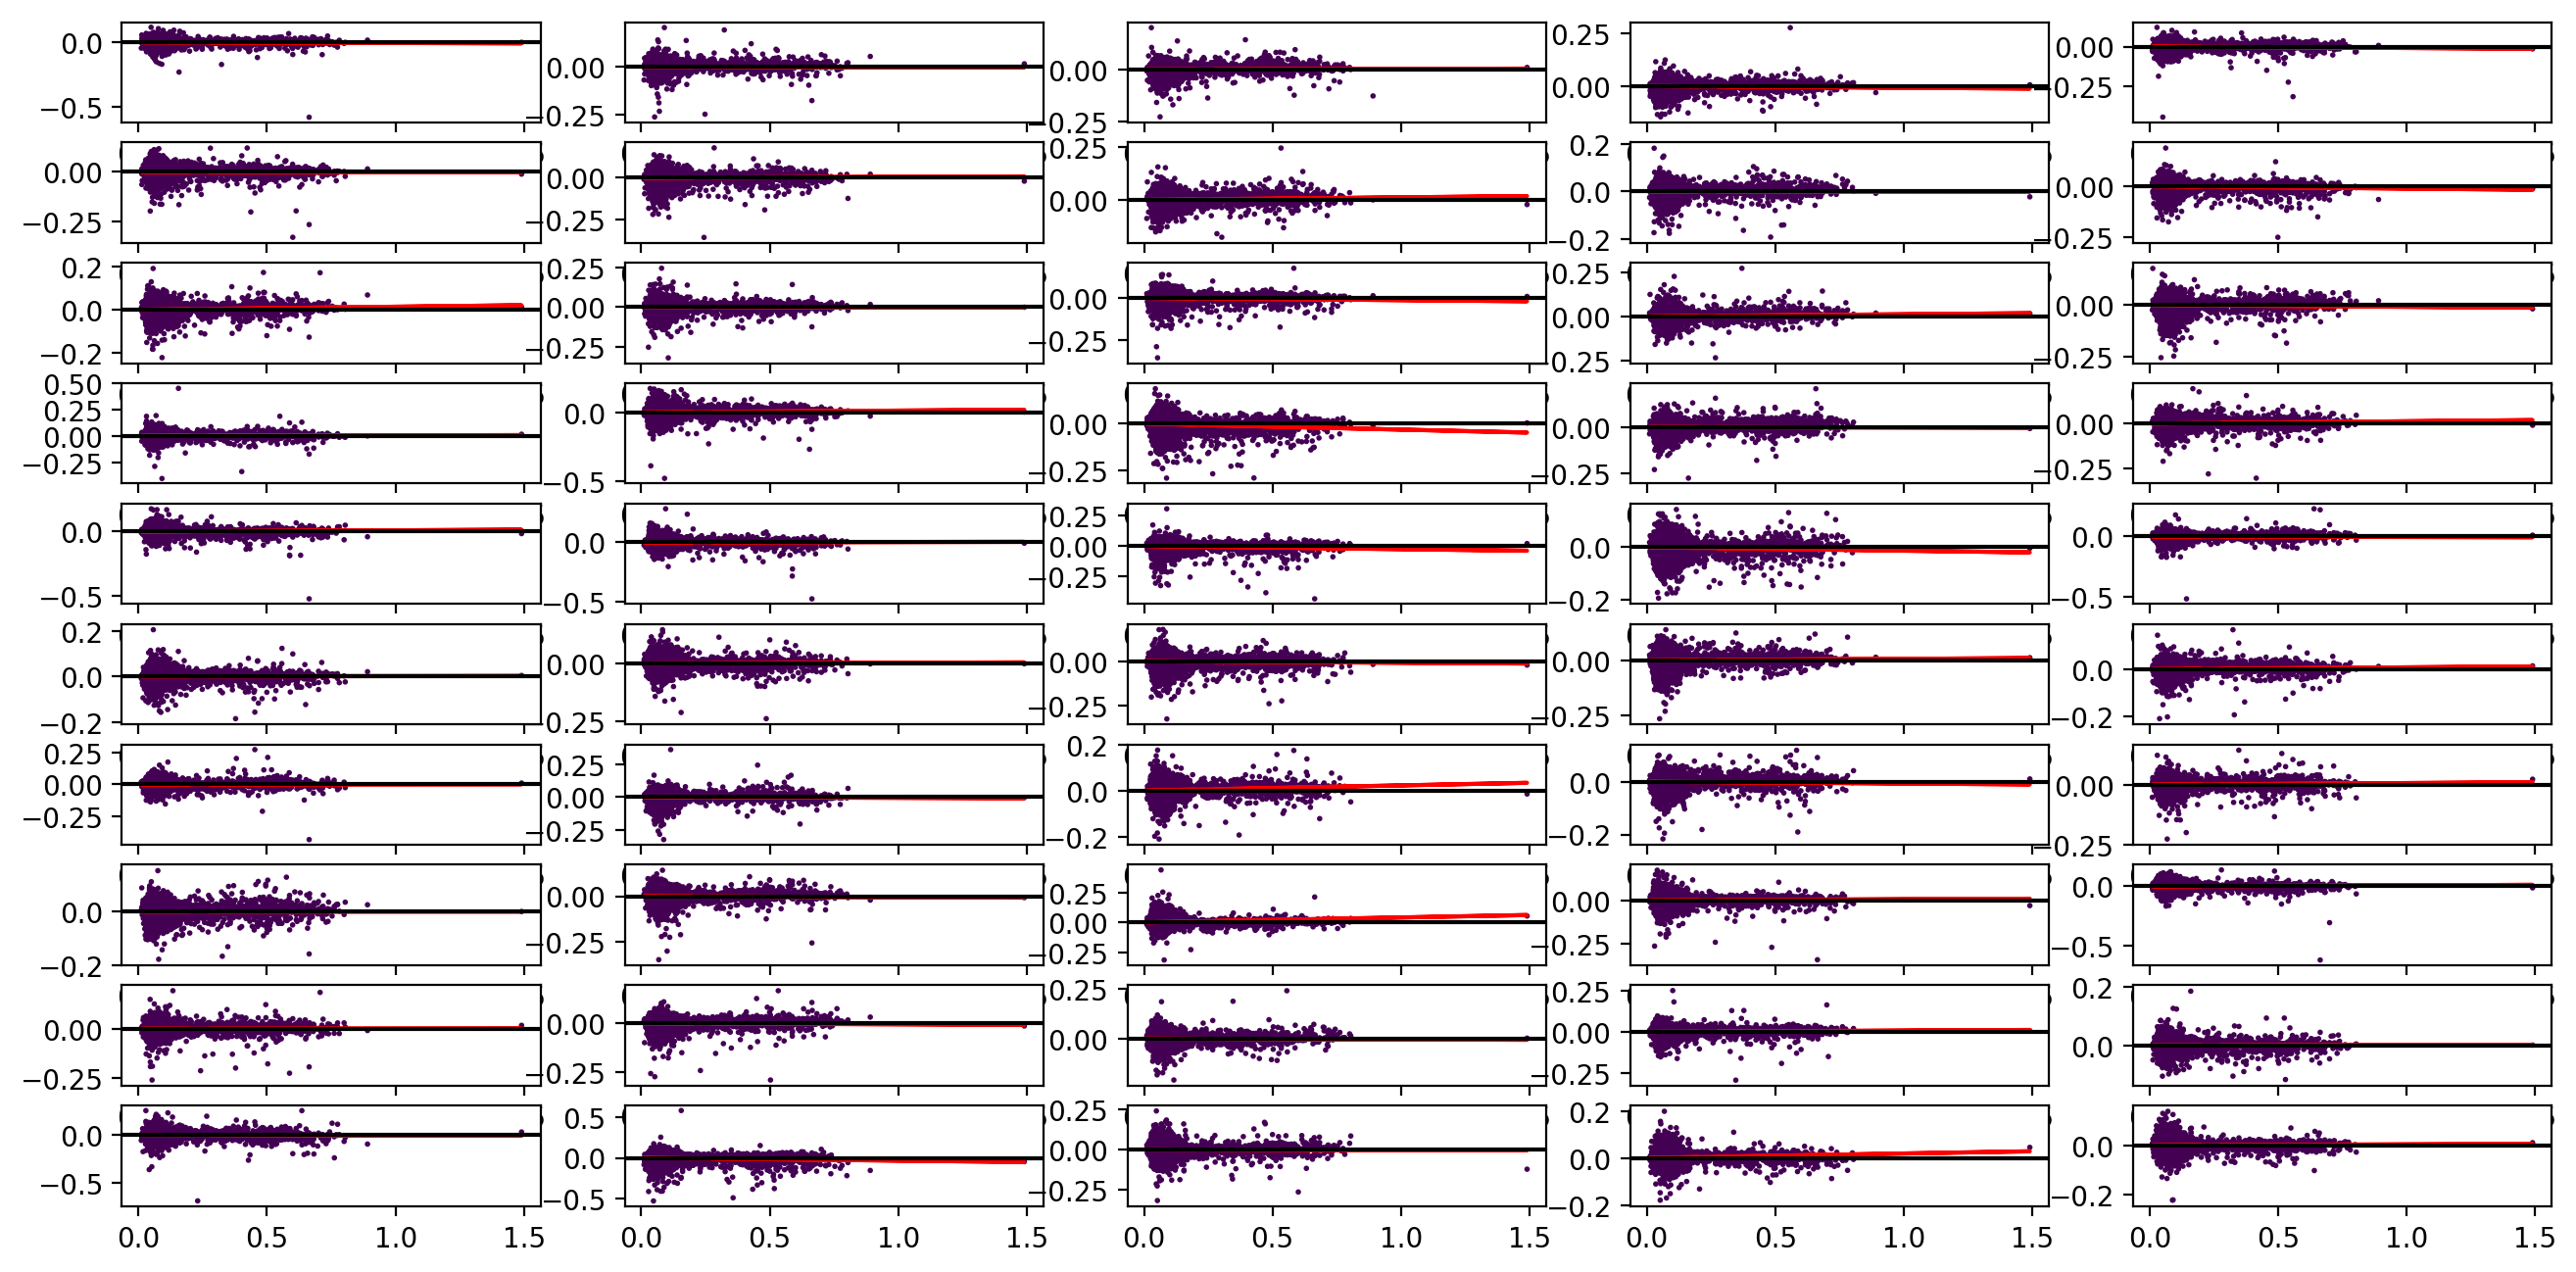

In [334]:
refgen=0
seqids = ['2L', '2R', '3L', '3R', 'X']
reps = np.arange(d.R)
refgens = np.arange(d.T-1)

fig, ax = plt.subplots(ncols=len(refgens), nrows=len(reps))

res = dict()
for i, rep in enumerate(reps):
    for j, refgen in enumerate(refgens):
        #this_cov = cov_df[(cov_df['s'] == refgen) & (cov_df['t'] == refgen) & (cov_df['seqid'] == seqid)].dropna()
        this_cov = cov_df[(cov_df['s'] == refgen) & (cov_df['t'] == refgen+1) & ((cov_df['rep_a'] == rep))].dropna()
        this_cov= this_cov[np.isfinite(this_cov['cov'])]
        #this_cov = cov_df[(cov_df['t'] == cov_df['s']+1)].dropna()
        R2sum, cov = this_cov['r2mean'].values, this_cov['cov'].values
        #plt.hist2d(R2sum, cov, 2000)
        ax[i, j].scatter(R2sum, cov, c=integerize(this_cov['seqid']), s=1)
        #X = sm.add_constant(R2sum)
        X = R2sum
        md = smf.OLS(cov, X).fit()
        res[(rep, refgen)] = (md.params[0], md.pvalues[0])
        cov_pred = md.predict(X)
        ax[i, j].plot(R2sum, cov_pred, '-', c='r')
        ax[i, j].axhline(y=0, c='k')

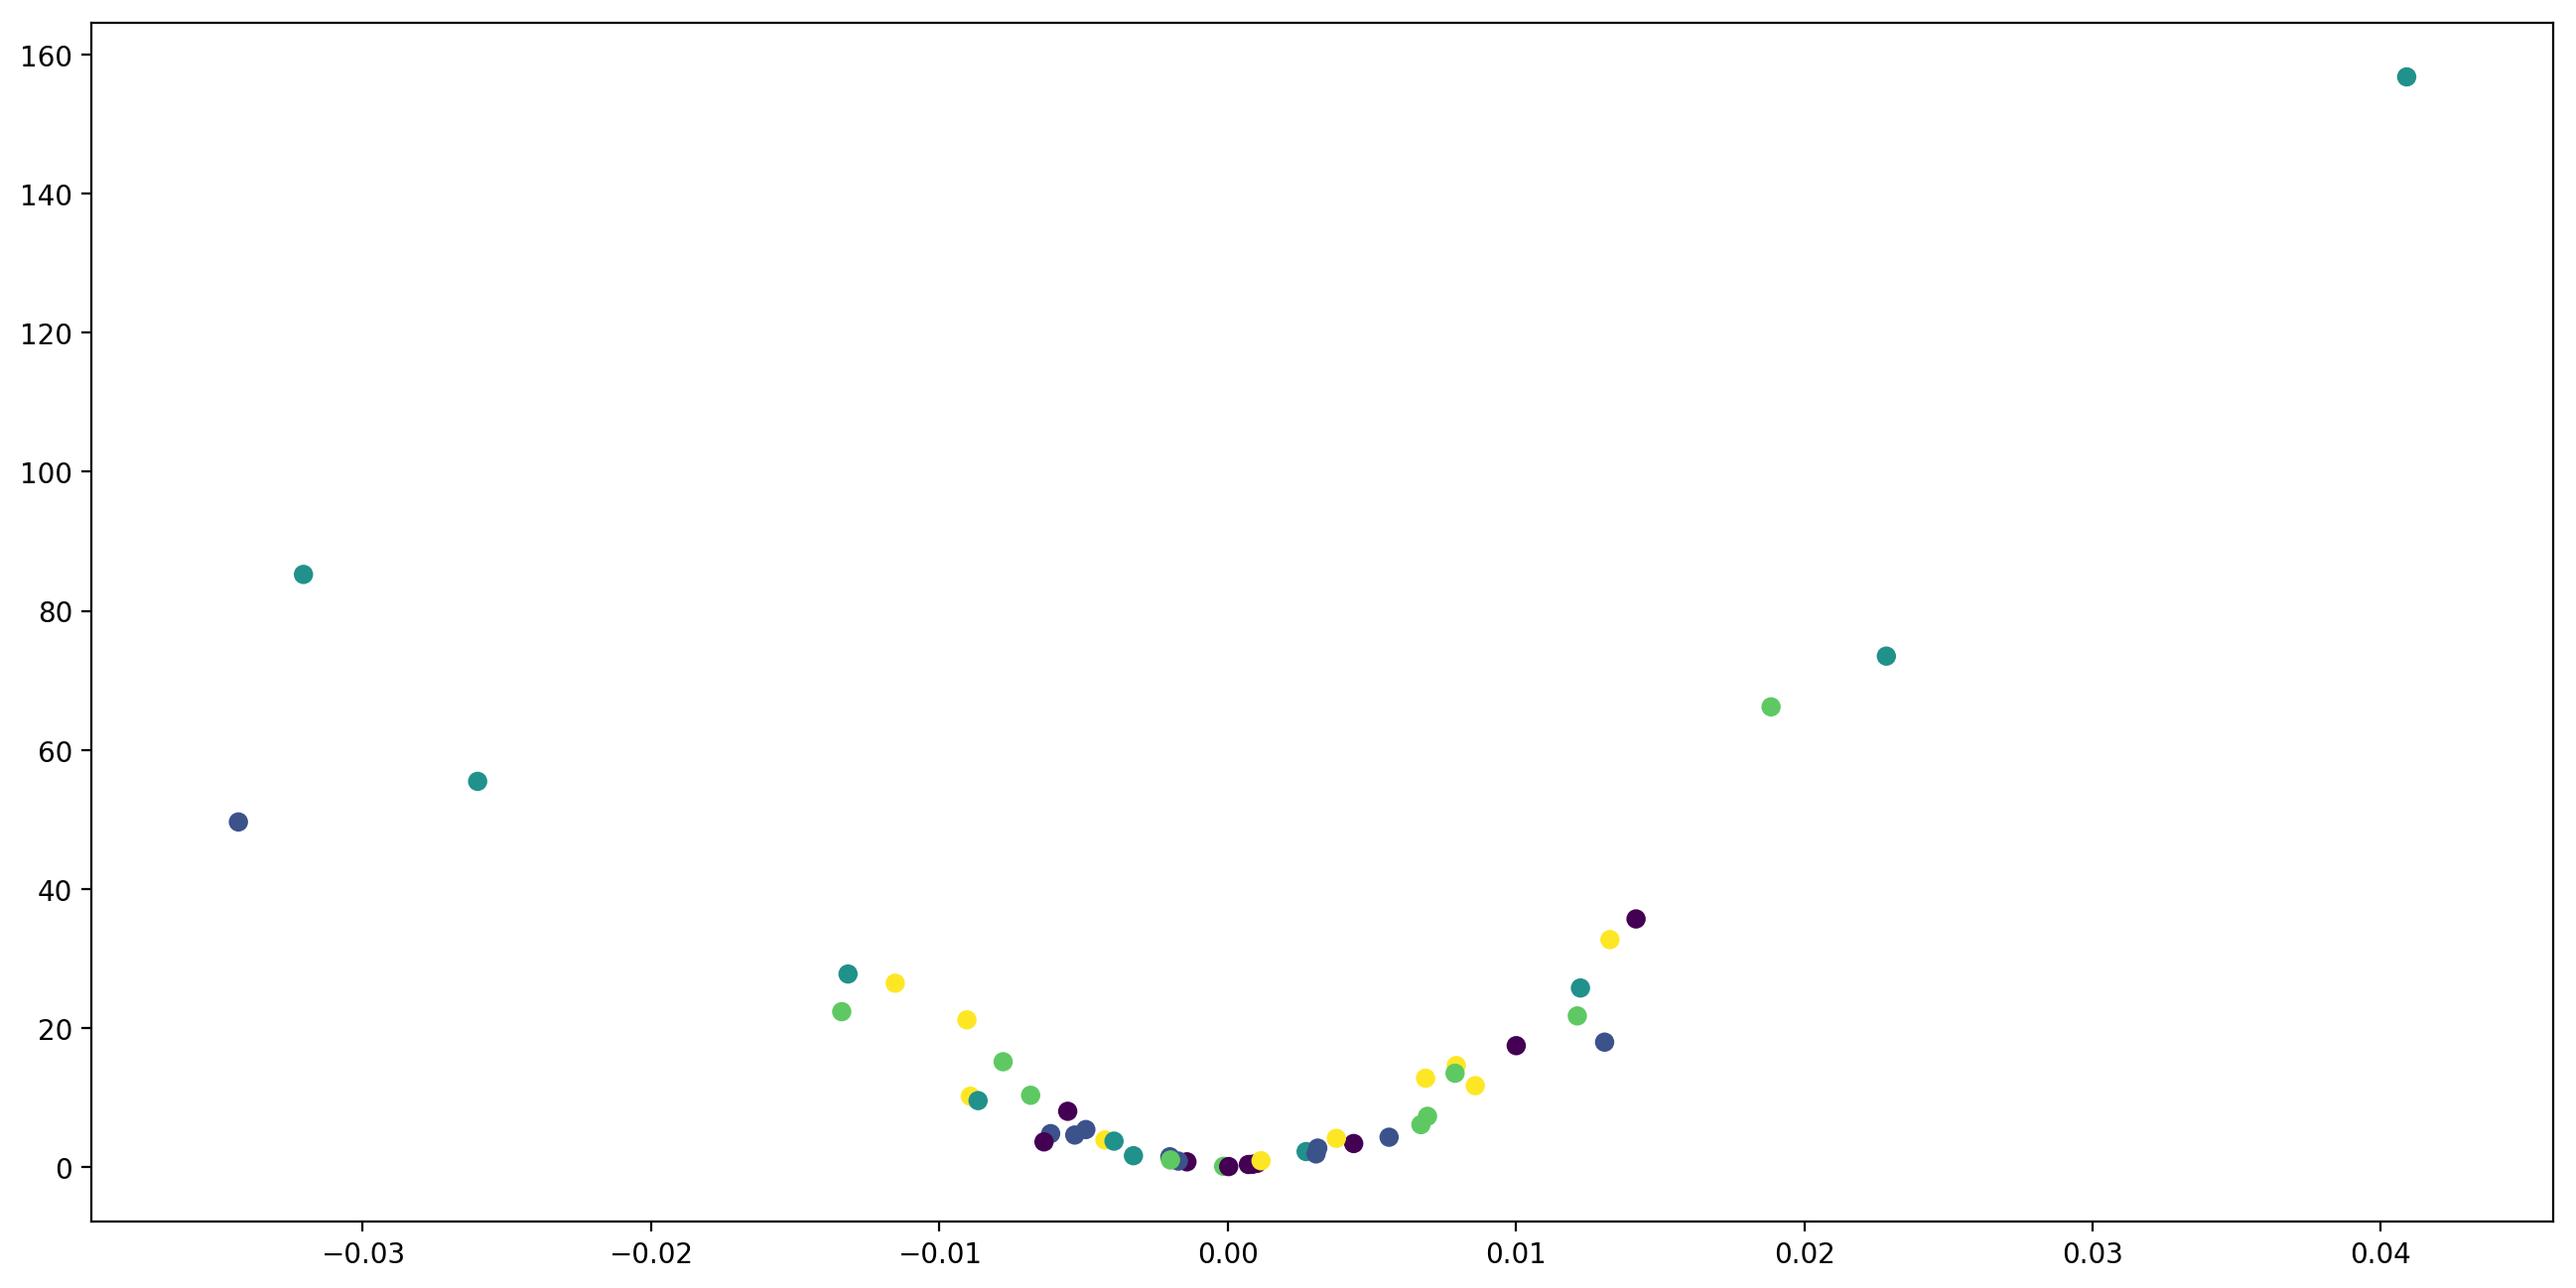

In [335]:
m = np.array(list(zip(*res.values())))
plt.scatter(m[0, :], -np.log10(m[1, :]), c=[t for r, t in res.keys()])

In [ ]:
d.dump('../data/barghi-2019-tiledtemporalfreqs-10k.pkl')

In [ ]:
plt.style.use('buffalo.mplstyle')
bins = np.linspace(-0.03, 0.03, 100)

mpl.rcParams['text.latex.preview'] = True

# average over all replicates
rep = slice(None)

# empirical null
k=4
empnull_k2 = list()
for row in range(0, d.T-k):
    empnull_k2.append(empcov_tile_stacked[:, :, row, row+k, :].ravel())

# k = 3 empirical null (not used)
empnull_k3 = list()
k=3
for row in range(0, d.T-k):
    empnull_k3.append(empcov_tile_stacked[:, :, row, row+k, :].ravel())

real_covs_diag_k2 = np.stack([[np.diag(stack_temporal_covariances(x, d.R, d.T, as_tensor=False)[rep], k=2) for x in covs] for rep in np.arange(d.R)]).ravel()
real_covs_diag_k3 = np.stack([[np.diag(stack_temporal_covariances(x, d.R, d.T, as_tensor=False)[rep], k=3) for x in covs] for rep in np.arange(d.R)]).ravel()

darj1 = [(1, 0, 0), (0, 0.627450980392157, 0.54117647058823), (0.949019607843137, 0.67843137254902, 0), (0.976470588235294, 0.517647058823529, 0), (0.356862745098039, 0.737254901960784, 0.83921568627451)]

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(real_covs_diag_k2, bins, alpha=0.3, density=True, label='observed covariances\ncov($\Delta p_t, \Delta p_{t+%s}$)' % 2, color=darj1[0])
#ax.hist(real_covs_diag_k3, bins, alpha=0.3, density=True, label='observed covariances k=3', color=darj1[0])
ax.hist(np.stack(empnull_k2).ravel(), bins, alpha=0.4, density=True, label='sign-permutation\nneutral null', color=darj1[1])
#ax.hist(np.stack(empnull_k3).ravel(), bins, alpha=0.4, density=True, label='sign-permutation\nneutral null', color=darj1[2])
ax.legend(loc=(0.6, 0.7), mode='expand')
ax.spines['bottom'].set_bounds(-0.03, 0.03)
ax.spines['left'].set_bounds(0, 100)
plt.savefig('images/barghi_et_al_2019/tile-averaged-rep-covdist.pdf')
plt.show()